# Load Libraries

In [1]:
# Standard libraries
import os
import json
import pickle
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated') # Known issue with PyTorch and DGL
import IPython

# Data handling
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Machine learning and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.cluster import HDBSCAN

# Neural Networks and Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import sigmoid

# Optuna for hyperparameter optimization
import optuna
from optuna.pruners import MedianPruner, HyperbandPruner

# Graph Neural Networks
import dgl
import dgl.nn as dglnn
from dgl import batch
from dgl.data.utils import save_graphs, load_graphs
from dgl.nn import GATConv

# Cheminformatics
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from dgllife.utils import mol_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer, mol_to_graph
from chembl_structure_pipeline import standardizer

# Network analysis
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


check if GPU is aviable and the device

In [2]:
import torch
print("PyTorch version:", torch.__version__)
print("Is CUDA Supported?", torch.cuda.is_available())

PyTorch version: 2.1.2
Is CUDA Supported? True


In [3]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name(0)

(True, 1, 'Tesla T4')

# Data Preprocessing

load dataset

In [4]:
# load json data from data_mvi folder
chemdiv = pd.read_json('data_mvi/chemdiv_df.json')
enamine = pd.read_json('data_mvi/enamine_df.json')
enmine_protein = pd.read_json('data_mvi/enamine_protein_df.json')
life_chemicals = pd.read_json('data_mvi/life_chemicals_df.json')
robin = pd.read_json('data_mvi/robin_df.json')

# add 'source column'
chemdiv['source'] = 'chemdiv'
enamine['source'] = 'enamine'
enmine_protein['source'] = 'enmine_protein'
life_chemicals['source'] = 'life_chemicals'
robin['source'] = 'robin'

# combine all dataframes
df = pd.concat([chemdiv, enamine, enmine_protein, life_chemicals, robin], ignore_index=True)

# delte 'mol' column and ECFp6 column
df = df.drop(['mol', 'ECFP6'], axis=1)

# create 'mol' column and use SMILES column to create mol object
df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))

# create 'ECFP6' column and use mol object to create ECFP6 fingerprint
# df['ECFP6'] = df['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 3, nBits=2048))

# check for duplicates using 'SMILES' column
df.duplicated(subset=['SMILES']).sum()
# create column for labels, if 'rna' == 1 - molecule binds to the RNA, else - Protein

# create 'rna' column and if in column 'source' is 'enmine_protein' set 'rna' to 0 else 1
df['rna'] = df['source'].apply(lambda x: 0 if x == 'enmine_protein' else 1)

# divide data back to 5 dataframes
chemdiv = df[df['source'] == 'chemdiv']
enamine = df[df['source'] == 'enamine']
enmine_protein = df[df['source'] == 'enmine_protein']
life_chemicals = df[df['source'] == 'life_chemicals']
robin = df[df['source'] == 'robin']


smiles_to_delete = [
    "COc1ccc(-c2n(-c3ccccn3)c3ccccc3[n+]2-c2ccccn2)cc1.[O-][Cl+3]([O-])([O-])[O-]",
    "[O-][Cl+3]([O-])([O-])[O-].c1ccc(-c2[se]c3nccc[n+]3c2-c2ccccc2)cc1",
    "OC1CSc2n(-c3ccccc3)c(-c3ccccc3)c(-c3ccccc3)[n+]2C1.[O-][Cl+3]([O-])([O-])[O-]",
    "[O-][Cl+3]([O-])([O-])[O-].c1ccc(-c2ccc(-c3n(-c4ccccn4)c4ccccc4[n+]3-c3ccccn3)cc2)cc1",
    "COc1ccc(-c2cc(=Nc3cccc(C)c3C)c3cc(C)ccc3o2)cc1.[O-][Cl+3]([O-])([O-])O",
    "CN(C)c1ccc(/C=C/c2cc(-c3ccccc3)c3ccccc3[o+]2)cc1.[O-][Cl+3]([O-])([O-])[O-]"
]

# delete from enamine using 'SMILES' column
enamine = enamine[~enamine['SMILES'].isin(smiles_to_delete)]
picked_molecules = pd.read_json('data_mvi/picked_molecules.json')

# # combine all df
df_small = pd.concat([chemdiv, enamine, picked_molecules, life_chemicals, robin], ignore_index=True)


In [5]:
df_small.reset_index(inplace=True, drop=True)
df_small['original_index'] = df_small.index

In [6]:
df_small

,source,SMILES,mol,rna,ECFP6,original_index
0,chemdiv,O=C(Nc1ccc2ccccc2c1)c1ccc2c(c1)C(=O)N(c1cccc(N...,<rdkit.Chem.rdchem.Mol object at 0x7f240111eac0>,1,NaN,0
1,chemdiv,O=C(CSc1nnc(-c2ccccc2Cl)n1-c1ccccc1)c1ccc2c(c1...,<rdkit.Chem.rdchem.Mol object at 0x7f240111ec10>,1,NaN,1
2,chemdiv,Cc1ccc(-n2c(=O)c3c4c(sc3n3c(SCC(=O)c5ccccc5)nn...,<rdkit.Chem.rdchem.Mol object at 0x7f240111eb30>,1,NaN,2
3,chemdiv,O=C(Nc1ccc(C(=O)c2ccccc2)cc1)c1ccc(Oc2ccc(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x7f240111ec80>,1,NaN,3
4,chemdiv,O=C(Nc1ccc(Oc2cccc(Oc3ccc(NC(=O)c4ccccc4Cl)cc3...,<rdkit.Chem.rdchem.Mol object at 0x7f240111ecf0>,1,NaN,4
...,...,...,...,...,...,...
73857,robin,C=CC(=O)Nc1cccc(Nc2nc(N[C@H]3CC[C@H](N(C)C)CC3...,<rdkit.Chem.rdchem.Mol object at 0x7f23cf00c190>,1,NaN,73857
73858,robin,N#C/C(C(=O)c1ccc(Cl)cc1Cl)=C1\NC(=O)c2ccc(Cl)c...,<rdkit.Chem.rdchem.Mol object at 0x7f23cf00c200>,1,NaN,73858
73859,robin,C[C@H](N[C@H]1C[C@H]1c1ccccc1)c1ccc2c(c1)OCCO2,<rdkit.Chem.rdchem.Mol object at 0x7f23cf00c270>,1,NaN,73859
73860,robin,NCCC[C@@H](N)CC(=O)N[C@H]1CNC(=O)[C@@H]([C@@H]...,<rdkit.Chem.rdchem.Mol object at 0x7f23cf00c2e0>,1,NaN,73860


Check for the inconsistency


In [7]:
# Load the graphs
loaded_graphs_orig, _ = dgl.load_graphs('data_mvi/molecule_graphs_orig.bin')

# Load the labels and additional information
with open('graph_labels.json', 'r') as f:
    loaded_graph_labels = json.load(f)

# You can now reconstruct a DataFrame or directly use the loaded data
reconstructed_df = pd.DataFrame(loaded_graph_labels)


In [12]:
# V2
# Assuming loaded_graphs_orig and reconstructed_df are already loaded

# Add indices to reconstructed_df to keep track of original positions
reconstructed_df['original_index'] = reconstructed_df.index

# Split indices into training and test sets with stratification to maintain class distribution
train_indices, test_indices = train_test_split(
    reconstructed_df['original_index'],
    test_size=0.2,
    random_state=42,
    stratify=reconstructed_df['rna']  # Ensures proportional class distribution
)

# Prepare labels for stratification in further splitting of the training set
# This step ensures that stratification is based on the 'rna' labels
train_labels_for_stratification = reconstructed_df.loc[train_indices, 'rna']

# Further split the training indices into training and validation sets with stratification
train_indices, val_indices = train_test_split(
    train_indices,
    test_size=0.2,  # 20% of the training set for validation
    random_state=42,
    stratify=train_labels_for_stratification  # Ensures proportional class distribution in train and validation sets
)

# Use indices to select the corresponding graphs and labels
train_graphs = [loaded_graphs_orig[i] for i in train_indices]
val_graphs = [loaded_graphs_orig[i] for i in val_indices]
test_graphs = [loaded_graphs_orig[i] for i in test_indices]

# Extract labels using the indices
train_labels = reconstructed_df.loc[train_indices, 'rna'].values
val_labels = reconstructed_df.loc[val_indices, 'rna'].values
test_labels = reconstructed_df.loc[test_indices, 'rna'].values

# Combine training and validation sets for some use cases
# Note: Directly using train_indices and val_indices lists to form train_val_indices
train_val_indices = list(train_indices) + list(val_indices)

# Use the combined indices to select the corresponding graphs
train_graphs_all = [loaded_graphs_orig[i] for i in train_val_indices]

# Combine the labels for training and validation sets
# Note: 'train_labels_all' is created by concatenating 'train_labels' and 'val_labels' directly
train_labels_all = list(train_labels) + list(val_labels)




In [13]:
# count 0 and 1 in train_labels val_labels and test_labels and train_labels_all
for i in [train_labels, val_labels, test_labels, train_labels_all]:
    print(np.bincount(i))
    

[23635 23636]
[5909 5909]
[7387 7386]
[29544 29545]


there was a problem with few isolated nodes in few graphs so I added loops to each node to have information at least about themselfs

# Graph Attention Networks (GAT)

In [17]:
class GATClassifier(nn.Module):
    def __init__(self, in_feats, hidden_size, num_heads=1):
        super(GATClassifier, self).__init__()
        
        # Only one GAT layer is used
        self.layer = dgl.nn.GATConv(in_feats, hidden_size, num_heads=num_heads, allow_zero_in_degree=True)
        
        # Linear layer for final prediction. Adjusted for the number of heads in the GAT layer
        self.fc = nn.Linear(hidden_size * num_heads, 1)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, g, features, get_attention=False):
        if get_attention:
            # If attention weights are needed, modify this accordingly
            h, attn_weight = self.layer(g, features, get_attention=True)
        else:
            h = self.layer(g, features)

        # Apply dropout directly after GAT layer
        h = self.dropout(h)

        # Reshape to concatenate head outputs for next layer input
        h = h.view(h.size(0), -1)
        
        # Apply activation function
        h = F.elu(h)

        # Aggregate node features across the graph
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')

        # Final linear transformation
        y = self.fc(hg)

        return (torch.sigmoid(y), attn_weight) if get_attention else torch.sigmoid(y)

# Best trial: {'num_heads': 16, 'hidden_size': 140, 'lr': 0.003180083105277109}

In [18]:
# V2
def objective(trial):
    print(f"Running trial number: {trial.number + 1}")

    # Define hyperparameter search space
    num_heads = trial.suggest_categorical('num_heads', [1, 2, 4, 8, 10, 12, 14, 15, 16, 18, 20])
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64 , 128, 140, 148, 180, 200, 256])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    
    print(f"Hyperparameters: num_heads={num_heads}, hidden_size={hidden_size}, lr={lr}")

    in_feats = train_graphs[0].ndata['h'].shape[1]

    # Initialize the model with suggested hyperparameters
    model = GATClassifier(in_feats, hidden_size=hidden_size, num_heads=num_heads).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(50):  # Adjusted to 50 epochs as sufficient for evaluation
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy, _, _, _ = validate(model, val_loader, criterion, device)
        
        # Print epoch details
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Report validation loss to Optuna for potential early pruning
        trial.report(val_loss, epoch)

        # Check if the trial should be pruned based on the reported val_loss
        if trial.should_prune():
            print("Pruning trial")
            raise optuna.exceptions.TrialPruned()

    return val_loss


In [19]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    for batch_graphs, batch_labels in data_loader:
        batch_graphs = batch_graphs.to(device)
        batch_labels = batch_labels.to(device)
        batch_features = batch_graphs.ndata['h']

        optimizer.zero_grad()
        outputs = model(batch_graphs, batch_features).squeeze()  # Adjust for binary classification
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_labels.size(0)

        # Calculate accuracy
        predicted = (outputs.sigmoid() > 0.5).long()  # Assuming outputs are logits and binary classification
        total_correct += (predicted == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


In [20]:
def validate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    y_true = []
    y_pred = []
    y_pred_proba = []
    with torch.no_grad():
        for graphs, labels in data_loader:
            graphs = graphs.to(device)
            features = graphs.ndata['h'].to(device)
            labels = labels.to(device)
            outputs = model(graphs, features)
            if outputs.dim() == 2 and outputs.shape[1] == 1:  # Check for single output per sample
                outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predicted = (outputs.sigmoid() > 0.5).long()  # Convert to binary predictions

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_proba.extend(outputs.sigmoid().cpu().numpy())  # Use sigmoid if outputs are logits
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(y_true, y_pred)  # Calculate accuracy

    return avg_loss, accuracy, y_true, y_pred, y_pred_proba


In [21]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.002):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.epochs_no_improve = 0
        self.early_stop = False
        self.stopped_epoch = 0  # Attribute to store the epoch number

    def __call__(self, val_loss, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
                self.stopped_epoch = epoch  # Store the epoch number


In [23]:
from torch.utils.data import DataLoader, Dataset

class GraphDataset(Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        # Ensure labels are stored in a format that supports simple indexing
        self.labels = labels  # labels can be a numpy array or a list

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        # Access the graph and label by index directly without .iloc
        graph = self.graphs[idx]
        label = self.labels[idx]  # Direct indexing
        return graph, label

def collate_graphs(samples):
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    labels = torch.tensor(labels)
    return batched_graph, labels

# Assuming you've defined your datasets
train_dataset = GraphDataset(train_graphs, train_labels)
val_dataset = GraphDataset(val_graphs, val_labels)
test_dataset = GraphDataset(test_graphs, test_labels)

# Example DataLoader setup
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4, collate_fn=collate_graphs)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4, collate_fn=collate_graphs)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, collate_fn=collate_graphs)


In [25]:

batch_size = 512
num_workers = 20

## Instance of the the GAT Model

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [28]:
# Initialize Optuna study with a Hyperband pruner
pruner = HyperbandPruner(min_resource=5, max_resource=50, reduction_factor=3)
study = optuna.create_study(direction='minimize', pruner=pruner)


[I 2024-02-17 23:32:30,193] A new study created in memory with name: no-name-a5888a5c-b9c9-4fdd-a22d-11993071502c


In [ ]:
# Run the optimization
study.optimize(objective, n_trials=100)  # 1 hour (3600 seconds , timeout=3600)

# Output the results
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


Running trial number: 1
Hyperparameters: num_heads=18, hidden_size=256, lr=0.0003664123474442469


Epoch 1, Train Loss: 0.6884, Val Loss: 0.6729, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6585, Val Loss: 0.6553, Val Accuracy: 0.4928


Epoch 3, Train Loss: 0.6460, Val Loss: 0.6493, Val Accuracy: 0.4970


Epoch 4, Train Loss: 0.6417, Val Loss: 0.6469, Val Accuracy: 0.5058


Epoch 5, Train Loss: 0.6396, Val Loss: 0.6452, Val Accuracy: 0.5173


Epoch 6, Train Loss: 0.6387, Val Loss: 0.6441, Val Accuracy: 0.5319


Epoch 7, Train Loss: 0.6376, Val Loss: 0.6434, Val Accuracy: 0.5389


Epoch 8, Train Loss: 0.6370, Val Loss: 0.6429, Val Accuracy: 0.5480


Epoch 9, Train Loss: 0.6367, Val Loss: 0.6422, Val Accuracy: 0.5574


Epoch 10, Train Loss: 0.6361, Val Loss: 0.6426, Val Accuracy: 0.5551


Epoch 11, Train Loss: 0.6360, Val Loss: 0.6418, Val Accuracy: 0.5644


Epoch 12, Train Loss: 0.6359, Val Loss: 0.6414, Val Accuracy: 0.5743


Epoch 13, Train Loss: 0.6354, Val Loss: 0.6423, Val Accuracy: 0.5647


Epoch 14, Train Loss: 0.6352, Val Loss: 0.6411, Val Accuracy: 0.5760


Epoch 15, Train Loss: 0.6351, Val Loss: 0.6410, Val Accuracy: 0.5828


Epoch 16, Train Loss: 0.6350, Val Loss: 0.6408, Val Accuracy: 0.5861


Epoch 17, Train Loss: 0.6349, Val Loss: 0.6408, Val Accuracy: 0.5843


Epoch 18, Train Loss: 0.6347, Val Loss: 0.6407, Val Accuracy: 0.5848


Epoch 19, Train Loss: 0.6345, Val Loss: 0.6411, Val Accuracy: 0.5819


Epoch 20, Train Loss: 0.6345, Val Loss: 0.6413, Val Accuracy: 0.5819


Epoch 21, Train Loss: 0.6343, Val Loss: 0.6417, Val Accuracy: 0.5813


Epoch 22, Train Loss: 0.6340, Val Loss: 0.6420, Val Accuracy: 0.5805


Epoch 23, Train Loss: 0.6341, Val Loss: 0.6404, Val Accuracy: 0.5897


Epoch 24, Train Loss: 0.6337, Val Loss: 0.6398, Val Accuracy: 0.5965


Epoch 25, Train Loss: 0.6336, Val Loss: 0.6396, Val Accuracy: 0.5968


Epoch 26, Train Loss: 0.6339, Val Loss: 0.6395, Val Accuracy: 0.5981


Epoch 27, Train Loss: 0.6334, Val Loss: 0.6398, Val Accuracy: 0.6110


Epoch 28, Train Loss: 0.6332, Val Loss: 0.6392, Val Accuracy: 0.5958


Epoch 29, Train Loss: 0.6331, Val Loss: 0.6390, Val Accuracy: 0.5976


Epoch 30, Train Loss: 0.6330, Val Loss: 0.6387, Val Accuracy: 0.6011


Epoch 31, Train Loss: 0.6327, Val Loss: 0.6384, Val Accuracy: 0.5995


Epoch 32, Train Loss: 0.6325, Val Loss: 0.6398, Val Accuracy: 0.5831


Epoch 33, Train Loss: 0.6328, Val Loss: 0.6387, Val Accuracy: 0.6076


Epoch 34, Train Loss: 0.6324, Val Loss: 0.6385, Val Accuracy: 0.5855


Epoch 35, Train Loss: 0.6318, Val Loss: 0.6375, Val Accuracy: 0.5958


Epoch 36, Train Loss: 0.6316, Val Loss: 0.6392, Val Accuracy: 0.5755


Epoch 37, Train Loss: 0.6315, Val Loss: 0.6368, Val Accuracy: 0.5859


Epoch 38, Train Loss: 0.6309, Val Loss: 0.6370, Val Accuracy: 0.5764


Epoch 39, Train Loss: 0.6311, Val Loss: 0.6361, Val Accuracy: 0.5843


Epoch 40, Train Loss: 0.6304, Val Loss: 0.6357, Val Accuracy: 0.5769


Epoch 41, Train Loss: 0.6299, Val Loss: 0.6364, Val Accuracy: 0.5660


Epoch 42, Train Loss: 0.6300, Val Loss: 0.6353, Val Accuracy: 0.5691


Epoch 43, Train Loss: 0.6297, Val Loss: 0.6345, Val Accuracy: 0.5717


Epoch 44, Train Loss: 0.6289, Val Loss: 0.6341, Val Accuracy: 0.5701


Epoch 45, Train Loss: 0.6286, Val Loss: 0.6334, Val Accuracy: 0.5624


Epoch 46, Train Loss: 0.6283, Val Loss: 0.6329, Val Accuracy: 0.5602


Epoch 47, Train Loss: 0.6276, Val Loss: 0.6324, Val Accuracy: 0.5571


Epoch 48, Train Loss: 0.6275, Val Loss: 0.6327, Val Accuracy: 0.5470


Epoch 49, Train Loss: 0.6277, Val Loss: 0.6325, Val Accuracy: 0.5489


[I 2024-02-12 17:43:07,758] Trial 0 finished with value: 0.631944133956373 and parameters: {'num_heads': 18, 'hidden_size': 256, 'lr': 0.0003664123474442469}. Best is trial 0 with value: 0.631944133956373.


Epoch 50, Train Loss: 0.6270, Val Loss: 0.6319, Val Accuracy: 0.5637
Running trial number: 2
Hyperparameters: num_heads=14, hidden_size=180, lr=0.0002325570076779766


Epoch 1, Train Loss: 0.6963, Val Loss: 0.6886, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6758, Val Loss: 0.6699, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6608, Val Loss: 0.6607, Val Accuracy: 0.4926


Epoch 4, Train Loss: 0.6518, Val Loss: 0.6535, Val Accuracy: 0.4928


Epoch 5, Train Loss: 0.6464, Val Loss: 0.6502, Val Accuracy: 0.4938


Epoch 6, Train Loss: 0.6437, Val Loss: 0.6484, Val Accuracy: 0.4964


Epoch 7, Train Loss: 0.6419, Val Loss: 0.6469, Val Accuracy: 0.5011


Epoch 8, Train Loss: 0.6407, Val Loss: 0.6459, Val Accuracy: 0.5061


Epoch 9, Train Loss: 0.6398, Val Loss: 0.6453, Val Accuracy: 0.5103


Epoch 10, Train Loss: 0.6391, Val Loss: 0.6446, Val Accuracy: 0.5164


Epoch 11, Train Loss: 0.6384, Val Loss: 0.6443, Val Accuracy: 0.5206


Epoch 12, Train Loss: 0.6380, Val Loss: 0.6436, Val Accuracy: 0.5294


Epoch 13, Train Loss: 0.6375, Val Loss: 0.6435, Val Accuracy: 0.5316


Epoch 14, Train Loss: 0.6372, Val Loss: 0.6430, Val Accuracy: 0.5369


Epoch 15, Train Loss: 0.6369, Val Loss: 0.6430, Val Accuracy: 0.5382


Epoch 16, Train Loss: 0.6367, Val Loss: 0.6424, Val Accuracy: 0.5471


Epoch 17, Train Loss: 0.6363, Val Loss: 0.6426, Val Accuracy: 0.5455


Epoch 18, Train Loss: 0.6362, Val Loss: 0.6423, Val Accuracy: 0.5498


Epoch 19, Train Loss: 0.6360, Val Loss: 0.6419, Val Accuracy: 0.5553


Epoch 20, Train Loss: 0.6358, Val Loss: 0.6417, Val Accuracy: 0.5574


Epoch 21, Train Loss: 0.6358, Val Loss: 0.6423, Val Accuracy: 0.5536


Epoch 22, Train Loss: 0.6355, Val Loss: 0.6415, Val Accuracy: 0.5616


Epoch 23, Train Loss: 0.6354, Val Loss: 0.6414, Val Accuracy: 0.5657


Epoch 24, Train Loss: 0.6352, Val Loss: 0.6413, Val Accuracy: 0.5649


Epoch 25, Train Loss: 0.6352, Val Loss: 0.6413, Val Accuracy: 0.5653


Epoch 26, Train Loss: 0.6350, Val Loss: 0.6410, Val Accuracy: 0.5710


Epoch 27, Train Loss: 0.6349, Val Loss: 0.6410, Val Accuracy: 0.5706


Epoch 28, Train Loss: 0.6350, Val Loss: 0.6412, Val Accuracy: 0.5823


Epoch 29, Train Loss: 0.6348, Val Loss: 0.6413, Val Accuracy: 0.5705


Epoch 30, Train Loss: 0.6347, Val Loss: 0.6410, Val Accuracy: 0.5740


Epoch 31, Train Loss: 0.6346, Val Loss: 0.6408, Val Accuracy: 0.5770


Epoch 32, Train Loss: 0.6345, Val Loss: 0.6406, Val Accuracy: 0.5790


Epoch 33, Train Loss: 0.6344, Val Loss: 0.6405, Val Accuracy: 0.5789


Epoch 34, Train Loss: 0.6342, Val Loss: 0.6404, Val Accuracy: 0.5814


Epoch 35, Train Loss: 0.6342, Val Loss: 0.6403, Val Accuracy: 0.5850


Epoch 36, Train Loss: 0.6340, Val Loss: 0.6402, Val Accuracy: 0.5888


Epoch 37, Train Loss: 0.6342, Val Loss: 0.6403, Val Accuracy: 0.5846


Epoch 38, Train Loss: 0.6340, Val Loss: 0.6401, Val Accuracy: 0.5910


Epoch 39, Train Loss: 0.6339, Val Loss: 0.6401, Val Accuracy: 0.5871


Epoch 40, Train Loss: 0.6339, Val Loss: 0.6399, Val Accuracy: 0.5919


Epoch 41, Train Loss: 0.6338, Val Loss: 0.6400, Val Accuracy: 0.5880


Epoch 42, Train Loss: 0.6337, Val Loss: 0.6398, Val Accuracy: 0.5889


Epoch 43, Train Loss: 0.6336, Val Loss: 0.6402, Val Accuracy: 0.5840


Epoch 44, Train Loss: 0.6335, Val Loss: 0.6396, Val Accuracy: 0.5930


Epoch 45, Train Loss: 0.6336, Val Loss: 0.6396, Val Accuracy: 0.5923


Epoch 46, Train Loss: 0.6334, Val Loss: 0.6398, Val Accuracy: 0.5862


Epoch 47, Train Loss: 0.6332, Val Loss: 0.6395, Val Accuracy: 0.5883


Epoch 48, Train Loss: 0.6333, Val Loss: 0.6398, Val Accuracy: 0.5853


Epoch 49, Train Loss: 0.6331, Val Loss: 0.6393, Val Accuracy: 0.5894


[I 2024-02-12 19:16:06,280] Trial 1 finished with value: 0.639129191939652 and parameters: {'num_heads': 14, 'hidden_size': 180, 'lr': 0.0002325570076779766}. Best is trial 0 with value: 0.631944133956373.


Epoch 50, Train Loss: 0.6329, Val Loss: 0.6391, Val Accuracy: 0.5934
Running trial number: 3
Hyperparameters: num_heads=12, hidden_size=64, lr=0.0015045459433333014


Epoch 1, Train Loss: 0.6790, Val Loss: 0.6608, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6474, Val Loss: 0.6480, Val Accuracy: 0.5011


Epoch 3, Train Loss: 0.6405, Val Loss: 0.6446, Val Accuracy: 0.5204


Epoch 4, Train Loss: 0.6382, Val Loss: 0.6430, Val Accuracy: 0.5417


Epoch 5, Train Loss: 0.6374, Val Loss: 0.6421, Val Accuracy: 0.5521


Epoch 6, Train Loss: 0.6361, Val Loss: 0.6418, Val Accuracy: 0.5565


Epoch 7, Train Loss: 0.6356, Val Loss: 0.6411, Val Accuracy: 0.5668


Epoch 8, Train Loss: 0.6349, Val Loss: 0.6408, Val Accuracy: 0.5778


Epoch 9, Train Loss: 0.6348, Val Loss: 0.6405, Val Accuracy: 0.5825


Epoch 10, Train Loss: 0.6344, Val Loss: 0.6415, Val Accuracy: 0.5778


Epoch 11, Train Loss: 0.6339, Val Loss: 0.6400, Val Accuracy: 0.5865


Epoch 12, Train Loss: 0.6337, Val Loss: 0.6443, Val Accuracy: 0.5721


Epoch 13, Train Loss: 0.6335, Val Loss: 0.6401, Val Accuracy: 0.5844


Epoch 14, Train Loss: 0.6331, Val Loss: 0.6393, Val Accuracy: 0.5910


Epoch 15, Train Loss: 0.6329, Val Loss: 0.6418, Val Accuracy: 0.5768


Epoch 16, Train Loss: 0.6323, Val Loss: 0.6389, Val Accuracy: 0.5867


Epoch 17, Train Loss: 0.6326, Val Loss: 0.6380, Val Accuracy: 0.6029


Epoch 18, Train Loss: 0.6317, Val Loss: 0.6375, Val Accuracy: 0.5978


Epoch 19, Train Loss: 0.6315, Val Loss: 0.6422, Val Accuracy: 0.5681


Epoch 20, Train Loss: 0.6308, Val Loss: 0.6381, Val Accuracy: 0.5754


Epoch 21, Train Loss: 0.6312, Val Loss: 0.6466, Val Accuracy: 0.5591


Epoch 22, Train Loss: 0.6302, Val Loss: 0.6418, Val Accuracy: 0.5612


Epoch 23, Train Loss: 0.6297, Val Loss: 0.6371, Val Accuracy: 0.5637


Epoch 24, Train Loss: 0.6290, Val Loss: 0.6358, Val Accuracy: 0.5619


Epoch 25, Train Loss: 0.6281, Val Loss: 0.6401, Val Accuracy: 0.5480


Epoch 26, Train Loss: 0.6276, Val Loss: 0.6485, Val Accuracy: 0.5367


Epoch 27, Train Loss: 0.6271, Val Loss: 0.6380, Val Accuracy: 0.5463


Epoch 28, Train Loss: 0.6274, Val Loss: 0.6397, Val Accuracy: 0.5440


Epoch 29, Train Loss: 0.6273, Val Loss: 0.6423, Val Accuracy: 0.5492


Epoch 30, Train Loss: 0.6266, Val Loss: 0.6408, Val Accuracy: 0.5445


Epoch 31, Train Loss: 0.6258, Val Loss: 0.6415, Val Accuracy: 0.5399


Epoch 32, Train Loss: 0.6253, Val Loss: 0.6381, Val Accuracy: 0.5436


Epoch 33, Train Loss: 0.6245, Val Loss: 0.6348, Val Accuracy: 0.5465


Epoch 34, Train Loss: 0.6244, Val Loss: 0.6324, Val Accuracy: 0.5506


Epoch 35, Train Loss: 0.6240, Val Loss: 0.6420, Val Accuracy: 0.5342


Epoch 36, Train Loss: 0.6244, Val Loss: 0.6338, Val Accuracy: 0.5472


Epoch 37, Train Loss: 0.6233, Val Loss: 0.6341, Val Accuracy: 0.5446


Epoch 38, Train Loss: 0.6232, Val Loss: 0.6323, Val Accuracy: 0.5447


Epoch 39, Train Loss: 0.6224, Val Loss: 0.6329, Val Accuracy: 0.5447


Epoch 40, Train Loss: 0.6217, Val Loss: 0.6274, Val Accuracy: 0.5518


Epoch 41, Train Loss: 0.6227, Val Loss: 0.6395, Val Accuracy: 0.5382


Epoch 42, Train Loss: 0.6213, Val Loss: 0.6326, Val Accuracy: 0.5415


Epoch 43, Train Loss: 0.6218, Val Loss: 0.6272, Val Accuracy: 0.5583


Epoch 44, Train Loss: 0.6206, Val Loss: 0.6285, Val Accuracy: 0.5505


Epoch 45, Train Loss: 0.6213, Val Loss: 0.6309, Val Accuracy: 0.5514


Epoch 46, Train Loss: 0.6204, Val Loss: 0.6306, Val Accuracy: 0.5468


Epoch 47, Train Loss: 0.6200, Val Loss: 0.6294, Val Accuracy: 0.5457


Epoch 48, Train Loss: 0.6190, Val Loss: 0.6263, Val Accuracy: 0.5563


Epoch 49, Train Loss: 0.6191, Val Loss: 0.6291, Val Accuracy: 0.5492


[I 2024-02-12 20:47:53,863] Trial 2 finished with value: 0.6333406039816734 and parameters: {'num_heads': 12, 'hidden_size': 64, 'lr': 0.0015045459433333014}. Best is trial 0 with value: 0.631944133956373.


Epoch 50, Train Loss: 0.6183, Val Loss: 0.6333, Val Accuracy: 0.5409
Running trial number: 4
Hyperparameters: num_heads=12, hidden_size=128, lr=0.0015121795036562105


Epoch 1, Train Loss: 0.6716, Val Loss: 0.6537, Val Accuracy: 0.4936


Epoch 2, Train Loss: 0.6425, Val Loss: 0.6466, Val Accuracy: 0.5248


Epoch 3, Train Loss: 0.6385, Val Loss: 0.6433, Val Accuracy: 0.5380


Epoch 4, Train Loss: 0.6369, Val Loss: 0.6424, Val Accuracy: 0.5512


Epoch 5, Train Loss: 0.6357, Val Loss: 0.6414, Val Accuracy: 0.5662


Epoch 6, Train Loss: 0.6358, Val Loss: 0.6417, Val Accuracy: 0.5711


Epoch 7, Train Loss: 0.6349, Val Loss: 0.6403, Val Accuracy: 0.5960


Epoch 8, Train Loss: 0.6347, Val Loss: 0.6400, Val Accuracy: 0.6052


Epoch 9, Train Loss: 0.6340, Val Loss: 0.6433, Val Accuracy: 0.5817


Epoch 10, Train Loss: 0.6344, Val Loss: 0.6395, Val Accuracy: 0.6139


Epoch 11, Train Loss: 0.6339, Val Loss: 0.6434, Val Accuracy: 0.5844


Epoch 12, Train Loss: 0.6336, Val Loss: 0.6393, Val Accuracy: 0.6216


Epoch 13, Train Loss: 0.6330, Val Loss: 0.6383, Val Accuracy: 0.6071


Epoch 14, Train Loss: 0.6325, Val Loss: 0.6396, Val Accuracy: 0.5887


Epoch 15, Train Loss: 0.6320, Val Loss: 0.6372, Val Accuracy: 0.5985


Epoch 16, Train Loss: 0.6315, Val Loss: 0.6368, Val Accuracy: 0.6055


Epoch 17, Train Loss: 0.6308, Val Loss: 0.6383, Val Accuracy: 0.5723


Epoch 18, Train Loss: 0.6302, Val Loss: 0.6342, Val Accuracy: 0.5811


Epoch 19, Train Loss: 0.6289, Val Loss: 0.6340, Val Accuracy: 0.5611


Epoch 20, Train Loss: 0.6286, Val Loss: 0.6333, Val Accuracy: 0.5651


Epoch 21, Train Loss: 0.6291, Val Loss: 0.6322, Val Accuracy: 0.5800


Epoch 22, Train Loss: 0.6260, Val Loss: 0.6305, Val Accuracy: 0.5555


Epoch 23, Train Loss: 0.6253, Val Loss: 0.6301, Val Accuracy: 0.5662


Epoch 24, Train Loss: 0.6239, Val Loss: 0.6285, Val Accuracy: 0.5460


Epoch 25, Train Loss: 0.6233, Val Loss: 0.6269, Val Accuracy: 0.5430


Epoch 26, Train Loss: 0.6232, Val Loss: 0.6284, Val Accuracy: 0.5744


Epoch 27, Train Loss: 0.6223, Val Loss: 0.6258, Val Accuracy: 0.5635


Epoch 28, Train Loss: 0.6219, Val Loss: 0.6244, Val Accuracy: 0.5620


Epoch 29, Train Loss: 0.6203, Val Loss: 0.6231, Val Accuracy: 0.5534


Epoch 30, Train Loss: 0.6196, Val Loss: 0.6218, Val Accuracy: 0.5441


Epoch 31, Train Loss: 0.6195, Val Loss: 0.6282, Val Accuracy: 0.5788


Epoch 32, Train Loss: 0.6202, Val Loss: 0.6294, Val Accuracy: 0.5889


Epoch 33, Train Loss: 0.6180, Val Loss: 0.6222, Val Accuracy: 0.5667


Epoch 34, Train Loss: 0.6178, Val Loss: 0.6217, Val Accuracy: 0.5657


Epoch 35, Train Loss: 0.6175, Val Loss: 0.6197, Val Accuracy: 0.5503


Epoch 36, Train Loss: 0.6180, Val Loss: 0.6274, Val Accuracy: 0.6016


Epoch 37, Train Loss: 0.6163, Val Loss: 0.6253, Val Accuracy: 0.5803


Epoch 38, Train Loss: 0.6155, Val Loss: 0.6176, Val Accuracy: 0.5558


Epoch 39, Train Loss: 0.6158, Val Loss: 0.6202, Val Accuracy: 0.5845


Epoch 40, Train Loss: 0.6152, Val Loss: 0.6176, Val Accuracy: 0.5664


Epoch 41, Train Loss: 0.6158, Val Loss: 0.6302, Val Accuracy: 0.6157


Epoch 42, Train Loss: 0.6158, Val Loss: 0.6172, Val Accuracy: 0.5795


Epoch 43, Train Loss: 0.6142, Val Loss: 0.6195, Val Accuracy: 0.5833


Epoch 44, Train Loss: 0.6136, Val Loss: 0.6167, Val Accuracy: 0.5690


Epoch 45, Train Loss: 0.6135, Val Loss: 0.6162, Val Accuracy: 0.5758


Epoch 46, Train Loss: 0.6140, Val Loss: 0.6162, Val Accuracy: 0.5793


Epoch 47, Train Loss: 0.6127, Val Loss: 0.6217, Val Accuracy: 0.5940


Epoch 48, Train Loss: 0.6132, Val Loss: 0.6359, Val Accuracy: 0.6247


Epoch 49, Train Loss: 0.6141, Val Loss: 0.6203, Val Accuracy: 0.6051


[I 2024-02-12 22:19:50,667] Trial 3 finished with value: 0.622791424993836 and parameters: {'num_heads': 12, 'hidden_size': 128, 'lr': 0.0015121795036562105}. Best is trial 3 with value: 0.622791424993836.


Epoch 50, Train Loss: 0.6129, Val Loss: 0.6228, Val Accuracy: 0.6081
Running trial number: 5
Hyperparameters: num_heads=4, hidden_size=64, lr=0.004111317584546454


Epoch 1, Train Loss: 0.6720, Val Loss: 0.6518, Val Accuracy: 0.4943


Epoch 2, Train Loss: 0.6416, Val Loss: 0.6443, Val Accuracy: 0.5242


Epoch 3, Train Loss: 0.6370, Val Loss: 0.6417, Val Accuracy: 0.5402


Epoch 4, Train Loss: 0.6357, Val Loss: 0.6406, Val Accuracy: 0.5685


Epoch 5, Train Loss: 0.6348, Val Loss: 0.6401, Val Accuracy: 0.5814


Epoch 6, Train Loss: 0.6341, Val Loss: 0.6417, Val Accuracy: 0.5743


Epoch 7, Train Loss: 0.6345, Val Loss: 0.6397, Val Accuracy: 0.6053


Epoch 8, Train Loss: 0.6339, Val Loss: 0.6408, Val Accuracy: 0.5888


Epoch 9, Train Loss: 0.6332, Val Loss: 0.6436, Val Accuracy: 0.5793


Epoch 10, Train Loss: 0.6332, Val Loss: 0.6508, Val Accuracy: 0.5676


Epoch 11, Train Loss: 0.6329, Val Loss: 0.6453, Val Accuracy: 0.5852


Epoch 12, Train Loss: 0.6322, Val Loss: 0.6389, Val Accuracy: 0.5960


Epoch 13, Train Loss: 0.6322, Val Loss: 0.6423, Val Accuracy: 0.5916


Epoch 14, Train Loss: 0.6316, Val Loss: 0.6450, Val Accuracy: 0.5851


Epoch 15, Train Loss: 0.6312, Val Loss: 0.6417, Val Accuracy: 0.5883


[I 2024-02-12 22:48:42,440] Trial 4 pruned. 


Epoch 16, Train Loss: 0.6308, Val Loss: 0.6448, Val Accuracy: 0.5767
Pruning trial
Running trial number: 6
Hyperparameters: num_heads=18, hidden_size=128, lr=0.00031027724843901125


Epoch 1, Train Loss: 0.6948, Val Loss: 0.6846, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6704, Val Loss: 0.6655, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6559, Val Loss: 0.6557, Val Accuracy: 0.4926


Epoch 4, Train Loss: 0.6476, Val Loss: 0.6506, Val Accuracy: 0.4940


Epoch 5, Train Loss: 0.6438, Val Loss: 0.6481, Val Accuracy: 0.4982


[I 2024-02-12 22:59:51,210] Trial 5 pruned. 


Epoch 6, Train Loss: 0.6416, Val Loss: 0.6466, Val Accuracy: 0.5047
Pruning trial
Running trial number: 7
Hyperparameters: num_heads=10, hidden_size=256, lr=0.0008014203257713607


Epoch 1, Train Loss: 0.6769, Val Loss: 0.6596, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6467, Val Loss: 0.6476, Val Accuracy: 0.5003


Epoch 3, Train Loss: 0.6405, Val Loss: 0.6446, Val Accuracy: 0.5217


Epoch 4, Train Loss: 0.6380, Val Loss: 0.6431, Val Accuracy: 0.5372


Epoch 5, Train Loss: 0.6370, Val Loss: 0.6439, Val Accuracy: 0.5639


Epoch 6, Train Loss: 0.6366, Val Loss: 0.6417, Val Accuracy: 0.5602


Epoch 7, Train Loss: 0.6358, Val Loss: 0.6416, Val Accuracy: 0.5653


Epoch 8, Train Loss: 0.6353, Val Loss: 0.6409, Val Accuracy: 0.5713


Epoch 9, Train Loss: 0.6349, Val Loss: 0.6408, Val Accuracy: 0.5745


Epoch 10, Train Loss: 0.6344, Val Loss: 0.6403, Val Accuracy: 0.5883


Epoch 11, Train Loss: 0.6343, Val Loss: 0.6401, Val Accuracy: 0.5891


Epoch 12, Train Loss: 0.6341, Val Loss: 0.6405, Val Accuracy: 0.5820


Epoch 13, Train Loss: 0.6340, Val Loss: 0.6421, Val Accuracy: 0.5763


Epoch 14, Train Loss: 0.6339, Val Loss: 0.6394, Val Accuracy: 0.5949


Epoch 15, Train Loss: 0.6338, Val Loss: 0.6395, Val Accuracy: 0.5939


[I 2024-02-12 23:29:51,576] Trial 6 pruned. 


Epoch 16, Train Loss: 0.6333, Val Loss: 0.6425, Val Accuracy: 0.5782
Pruning trial
Running trial number: 8
Hyperparameters: num_heads=4, hidden_size=140, lr=0.0012968515334856273


Epoch 1, Train Loss: 0.6852, Val Loss: 0.6639, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6500, Val Loss: 0.6496, Val Accuracy: 0.4945


Epoch 3, Train Loss: 0.6421, Val Loss: 0.6457, Val Accuracy: 0.5047


Epoch 4, Train Loss: 0.6390, Val Loss: 0.6437, Val Accuracy: 0.5135


Epoch 5, Train Loss: 0.6374, Val Loss: 0.6423, Val Accuracy: 0.5283


Epoch 6, Train Loss: 0.6361, Val Loss: 0.6414, Val Accuracy: 0.5381


Epoch 7, Train Loss: 0.6355, Val Loss: 0.6418, Val Accuracy: 0.5380


Epoch 8, Train Loss: 0.6351, Val Loss: 0.6407, Val Accuracy: 0.5503


Epoch 9, Train Loss: 0.6347, Val Loss: 0.6402, Val Accuracy: 0.5657


Epoch 10, Train Loss: 0.6341, Val Loss: 0.6395, Val Accuracy: 0.5671


Epoch 11, Train Loss: 0.6340, Val Loss: 0.6400, Val Accuracy: 0.5696


Epoch 12, Train Loss: 0.6338, Val Loss: 0.6406, Val Accuracy: 0.5656


Epoch 13, Train Loss: 0.6338, Val Loss: 0.6391, Val Accuracy: 0.5751


Epoch 14, Train Loss: 0.6331, Val Loss: 0.6387, Val Accuracy: 0.5798


Epoch 15, Train Loss: 0.6331, Val Loss: 0.6382, Val Accuracy: 0.5866


Epoch 16, Train Loss: 0.6326, Val Loss: 0.6380, Val Accuracy: 0.5869


Epoch 17, Train Loss: 0.6329, Val Loss: 0.6377, Val Accuracy: 0.5943


Epoch 18, Train Loss: 0.6327, Val Loss: 0.6377, Val Accuracy: 0.5899


Epoch 19, Train Loss: 0.6321, Val Loss: 0.6376, Val Accuracy: 0.5878


Epoch 20, Train Loss: 0.6322, Val Loss: 0.6381, Val Accuracy: 0.5858


Epoch 21, Train Loss: 0.6318, Val Loss: 0.6376, Val Accuracy: 0.5898


Epoch 22, Train Loss: 0.6314, Val Loss: 0.6370, Val Accuracy: 0.5906


Epoch 23, Train Loss: 0.6314, Val Loss: 0.6390, Val Accuracy: 0.5850


Epoch 24, Train Loss: 0.6311, Val Loss: 0.6365, Val Accuracy: 0.5905


Epoch 25, Train Loss: 0.6310, Val Loss: 0.6358, Val Accuracy: 0.6045


Epoch 26, Train Loss: 0.6305, Val Loss: 0.6355, Val Accuracy: 0.6013


Epoch 27, Train Loss: 0.6303, Val Loss: 0.6353, Val Accuracy: 0.5960


Epoch 28, Train Loss: 0.6304, Val Loss: 0.6350, Val Accuracy: 0.5986


Epoch 29, Train Loss: 0.6300, Val Loss: 0.6385, Val Accuracy: 0.5773


Epoch 30, Train Loss: 0.6296, Val Loss: 0.6349, Val Accuracy: 0.5876


Epoch 31, Train Loss: 0.6295, Val Loss: 0.6356, Val Accuracy: 0.5843


Epoch 32, Train Loss: 0.6290, Val Loss: 0.6356, Val Accuracy: 0.5828


Epoch 33, Train Loss: 0.6286, Val Loss: 0.6348, Val Accuracy: 0.5811


Epoch 34, Train Loss: 0.6286, Val Loss: 0.6333, Val Accuracy: 0.5972


Epoch 35, Train Loss: 0.6284, Val Loss: 0.6380, Val Accuracy: 0.5701


Epoch 36, Train Loss: 0.6281, Val Loss: 0.6332, Val Accuracy: 0.5822


Epoch 37, Train Loss: 0.6275, Val Loss: 0.6328, Val Accuracy: 0.5795


Epoch 38, Train Loss: 0.6269, Val Loss: 0.6328, Val Accuracy: 0.5711


Epoch 39, Train Loss: 0.6265, Val Loss: 0.6409, Val Accuracy: 0.5511


Epoch 40, Train Loss: 0.6261, Val Loss: 0.6346, Val Accuracy: 0.5605


Epoch 41, Train Loss: 0.6261, Val Loss: 0.6343, Val Accuracy: 0.5571


Epoch 42, Train Loss: 0.6251, Val Loss: 0.6350, Val Accuracy: 0.5520


Epoch 43, Train Loss: 0.6249, Val Loss: 0.6303, Val Accuracy: 0.5660


Epoch 44, Train Loss: 0.6246, Val Loss: 0.6302, Val Accuracy: 0.5672


Epoch 45, Train Loss: 0.6245, Val Loss: 0.6309, Val Accuracy: 0.5611


[I 2024-02-13 00:53:03,817] Trial 7 pruned. 


Epoch 46, Train Loss: 0.6241, Val Loss: 0.6329, Val Accuracy: 0.5590
Pruning trial
Running trial number: 9
Hyperparameters: num_heads=16, hidden_size=128, lr=0.0006886322849002357


Epoch 1, Train Loss: 0.6854, Val Loss: 0.6677, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6541, Val Loss: 0.6523, Val Accuracy: 0.4935


Epoch 3, Train Loss: 0.6437, Val Loss: 0.6494, Val Accuracy: 0.5009


Epoch 4, Train Loss: 0.6404, Val Loss: 0.6472, Val Accuracy: 0.5122


Epoch 5, Train Loss: 0.6385, Val Loss: 0.6443, Val Accuracy: 0.5294


[I 2024-02-13 01:04:09,058] Trial 8 pruned. 


Epoch 6, Train Loss: 0.6377, Val Loss: 0.6429, Val Accuracy: 0.5437
Pruning trial
Running trial number: 10
Hyperparameters: num_heads=14, hidden_size=128, lr=0.0026374304786542647


Epoch 1, Train Loss: 0.6697, Val Loss: 0.6490, Val Accuracy: 0.5039


Epoch 2, Train Loss: 0.6397, Val Loss: 0.6467, Val Accuracy: 0.5355


Epoch 3, Train Loss: 0.6373, Val Loss: 0.6441, Val Accuracy: 0.5564


Epoch 4, Train Loss: 0.6354, Val Loss: 0.6419, Val Accuracy: 0.5737


Epoch 5, Train Loss: 0.6348, Val Loss: 0.6403, Val Accuracy: 0.5957


Epoch 6, Train Loss: 0.6352, Val Loss: 0.6422, Val Accuracy: 0.6004


Epoch 7, Train Loss: 0.6350, Val Loss: 0.6407, Val Accuracy: 0.6068


Epoch 8, Train Loss: 0.6342, Val Loss: 0.6392, Val Accuracy: 0.6199


Epoch 9, Train Loss: 0.6329, Val Loss: 0.6398, Val Accuracy: 0.6064


Epoch 10, Train Loss: 0.6326, Val Loss: 0.6375, Val Accuracy: 0.6191


Epoch 11, Train Loss: 0.6322, Val Loss: 0.6370, Val Accuracy: 0.6038


Epoch 12, Train Loss: 0.6314, Val Loss: 0.6356, Val Accuracy: 0.6133


Epoch 13, Train Loss: 0.6303, Val Loss: 0.6371, Val Accuracy: 0.5834


Epoch 14, Train Loss: 0.6286, Val Loss: 0.6328, Val Accuracy: 0.5903


Epoch 15, Train Loss: 0.6269, Val Loss: 0.6306, Val Accuracy: 0.5743


Epoch 16, Train Loss: 0.6261, Val Loss: 0.6325, Val Accuracy: 0.5822


Epoch 17, Train Loss: 0.6252, Val Loss: 0.6282, Val Accuracy: 0.5568


Epoch 18, Train Loss: 0.6234, Val Loss: 0.6283, Val Accuracy: 0.5845


Epoch 19, Train Loss: 0.6225, Val Loss: 0.6232, Val Accuracy: 0.5548


Epoch 20, Train Loss: 0.6196, Val Loss: 0.6239, Val Accuracy: 0.5624


Epoch 21, Train Loss: 0.6198, Val Loss: 0.6250, Val Accuracy: 0.5951


Epoch 22, Train Loss: 0.6197, Val Loss: 0.6215, Val Accuracy: 0.5802


Epoch 23, Train Loss: 0.6196, Val Loss: 0.6256, Val Accuracy: 0.6002


Epoch 24, Train Loss: 0.6174, Val Loss: 0.6187, Val Accuracy: 0.5505


Epoch 25, Train Loss: 0.6169, Val Loss: 0.6181, Val Accuracy: 0.5659


Epoch 26, Train Loss: 0.6161, Val Loss: 0.6265, Val Accuracy: 0.6083


Epoch 27, Train Loss: 0.6163, Val Loss: 0.6226, Val Accuracy: 0.6049


Epoch 28, Train Loss: 0.6149, Val Loss: 0.6168, Val Accuracy: 0.5803


Epoch 29, Train Loss: 0.6154, Val Loss: 0.6173, Val Accuracy: 0.5919


Epoch 30, Train Loss: 0.6144, Val Loss: 0.6161, Val Accuracy: 0.5861


Epoch 31, Train Loss: 0.6137, Val Loss: 0.6163, Val Accuracy: 0.5880


Epoch 32, Train Loss: 0.6139, Val Loss: 0.6211, Val Accuracy: 0.6141


Epoch 33, Train Loss: 0.6154, Val Loss: 0.6184, Val Accuracy: 0.6170


Epoch 34, Train Loss: 0.6138, Val Loss: 0.6188, Val Accuracy: 0.6237


Epoch 35, Train Loss: 0.6130, Val Loss: 0.6179, Val Accuracy: 0.6027


Epoch 36, Train Loss: 0.6132, Val Loss: 0.6152, Val Accuracy: 0.6116


Epoch 37, Train Loss: 0.6124, Val Loss: 0.6193, Val Accuracy: 0.5701


Epoch 38, Train Loss: 0.6139, Val Loss: 0.6174, Val Accuracy: 0.5993


Epoch 39, Train Loss: 0.6122, Val Loss: 0.6145, Val Accuracy: 0.6044


Epoch 40, Train Loss: 0.6119, Val Loss: 0.6146, Val Accuracy: 0.5892


Epoch 41, Train Loss: 0.6131, Val Loss: 0.6153, Val Accuracy: 0.6215


Epoch 42, Train Loss: 0.6127, Val Loss: 0.6140, Val Accuracy: 0.6215


Epoch 43, Train Loss: 0.6117, Val Loss: 0.6142, Val Accuracy: 0.6026


Epoch 44, Train Loss: 0.6117, Val Loss: 0.6152, Val Accuracy: 0.6405


Epoch 45, Train Loss: 0.6116, Val Loss: 0.6135, Val Accuracy: 0.6009


Epoch 46, Train Loss: 0.6119, Val Loss: 0.6160, Val Accuracy: 0.6381


Epoch 47, Train Loss: 0.6104, Val Loss: 0.6152, Val Accuracy: 0.6418


Epoch 48, Train Loss: 0.6106, Val Loss: 0.6146, Val Accuracy: 0.6011


Epoch 49, Train Loss: 0.6113, Val Loss: 0.6173, Val Accuracy: 0.6444


[I 2024-02-13 02:36:31,260] Trial 9 finished with value: 0.6137686222060358 and parameters: {'num_heads': 14, 'hidden_size': 128, 'lr': 0.0026374304786542647}. Best is trial 9 with value: 0.6137686222060358.


Epoch 50, Train Loss: 0.6109, Val Loss: 0.6138, Val Accuracy: 0.6374
Running trial number: 11
Hyperparameters: num_heads=14, hidden_size=148, lr=0.0058053312192248374


Epoch 1, Train Loss: 0.6585, Val Loss: 0.6448, Val Accuracy: 0.5425


Epoch 2, Train Loss: 0.6378, Val Loss: 0.6417, Val Accuracy: 0.6085


Epoch 3, Train Loss: 0.6357, Val Loss: 0.6483, Val Accuracy: 0.5916


Epoch 4, Train Loss: 0.6355, Val Loss: 0.6412, Val Accuracy: 0.6342


Epoch 5, Train Loss: 0.6344, Val Loss: 0.6415, Val Accuracy: 0.6051


Epoch 6, Train Loss: 0.6335, Val Loss: 0.6390, Val Accuracy: 0.6414


Epoch 7, Train Loss: 0.6339, Val Loss: 0.6454, Val Accuracy: 0.6133


Epoch 8, Train Loss: 0.6324, Val Loss: 0.6399, Val Accuracy: 0.6235


Epoch 9, Train Loss: 0.6320, Val Loss: 0.6419, Val Accuracy: 0.6089


Epoch 10, Train Loss: 0.6309, Val Loss: 0.6388, Val Accuracy: 0.5882


Epoch 11, Train Loss: 0.6292, Val Loss: 0.6518, Val Accuracy: 0.5582


Epoch 12, Train Loss: 0.6273, Val Loss: 0.6342, Val Accuracy: 0.5531


Epoch 13, Train Loss: 0.6249, Val Loss: 0.6281, Val Accuracy: 0.6125


Epoch 14, Train Loss: 0.6251, Val Loss: 0.6330, Val Accuracy: 0.5711


Epoch 15, Train Loss: 0.6211, Val Loss: 0.6230, Val Accuracy: 0.5767


Epoch 16, Train Loss: 0.6201, Val Loss: 0.6397, Val Accuracy: 0.5443


Epoch 17, Train Loss: 0.6188, Val Loss: 0.6190, Val Accuracy: 0.5956


Epoch 18, Train Loss: 0.6181, Val Loss: 0.6298, Val Accuracy: 0.5663


Epoch 19, Train Loss: 0.6165, Val Loss: 0.6185, Val Accuracy: 0.5955


Epoch 20, Train Loss: 0.6169, Val Loss: 0.6186, Val Accuracy: 0.6089


Epoch 21, Train Loss: 0.6145, Val Loss: 0.6166, Val Accuracy: 0.5982


Epoch 22, Train Loss: 0.6149, Val Loss: 0.6171, Val Accuracy: 0.5999


Epoch 23, Train Loss: 0.6137, Val Loss: 0.6154, Val Accuracy: 0.6002


Epoch 24, Train Loss: 0.6127, Val Loss: 0.6262, Val Accuracy: 0.6562


Epoch 25, Train Loss: 0.6123, Val Loss: 0.6161, Val Accuracy: 0.6187


Epoch 26, Train Loss: 0.6122, Val Loss: 0.6177, Val Accuracy: 0.6394


Epoch 27, Train Loss: 0.6125, Val Loss: 0.6293, Val Accuracy: 0.7036


Epoch 28, Train Loss: 0.6140, Val Loss: 0.6163, Val Accuracy: 0.6488


Epoch 29, Train Loss: 0.6127, Val Loss: 0.6176, Val Accuracy: 0.6740


Epoch 30, Train Loss: 0.6113, Val Loss: 0.6157, Val Accuracy: 0.6226


Epoch 31, Train Loss: 0.6130, Val Loss: 0.6194, Val Accuracy: 0.6815


Epoch 32, Train Loss: 0.6115, Val Loss: 0.6150, Val Accuracy: 0.6337


Epoch 33, Train Loss: 0.6123, Val Loss: 0.6183, Val Accuracy: 0.6684


Epoch 34, Train Loss: 0.6117, Val Loss: 0.6129, Val Accuracy: 0.6536


Epoch 35, Train Loss: 0.6122, Val Loss: 0.6174, Val Accuracy: 0.6885


Epoch 36, Train Loss: 0.6104, Val Loss: 0.6146, Val Accuracy: 0.6723


Epoch 37, Train Loss: 0.6105, Val Loss: 0.6167, Val Accuracy: 0.6709


Epoch 38, Train Loss: 0.6103, Val Loss: 0.6246, Val Accuracy: 0.6906


Epoch 39, Train Loss: 0.6100, Val Loss: 0.6156, Val Accuracy: 0.6694


Epoch 40, Train Loss: 0.6090, Val Loss: 0.6238, Val Accuracy: 0.7044


Epoch 41, Train Loss: 0.6160, Val Loss: 0.6241, Val Accuracy: 0.6966


Epoch 42, Train Loss: 0.6152, Val Loss: 0.6162, Val Accuracy: 0.6764


Epoch 43, Train Loss: 0.6136, Val Loss: 0.6161, Val Accuracy: 0.6455


Epoch 44, Train Loss: 0.6143, Val Loss: 0.6196, Val Accuracy: 0.7084


Epoch 45, Train Loss: 0.6124, Val Loss: 0.6232, Val Accuracy: 0.7146


[I 2024-02-13 04:02:40,550] Trial 10 pruned. 


Epoch 46, Train Loss: 0.6126, Val Loss: 0.6215, Val Accuracy: 0.7137
Pruning trial
Running trial number: 12
Hyperparameters: num_heads=15, hidden_size=128, lr=0.0023378456334420417


Epoch 1, Train Loss: 0.6650, Val Loss: 0.6497, Val Accuracy: 0.5090


Epoch 2, Train Loss: 0.6404, Val Loss: 0.6433, Val Accuracy: 0.5443


Epoch 3, Train Loss: 0.6374, Val Loss: 0.6431, Val Accuracy: 0.5619


Epoch 4, Train Loss: 0.6360, Val Loss: 0.6410, Val Accuracy: 0.5885


Epoch 5, Train Loss: 0.6357, Val Loss: 0.6411, Val Accuracy: 0.5886


Epoch 6, Train Loss: 0.6350, Val Loss: 0.6402, Val Accuracy: 0.6097


Epoch 7, Train Loss: 0.6344, Val Loss: 0.6400, Val Accuracy: 0.6225


Epoch 8, Train Loss: 0.6343, Val Loss: 0.6398, Val Accuracy: 0.6152


Epoch 9, Train Loss: 0.6341, Val Loss: 0.6395, Val Accuracy: 0.6255


Epoch 10, Train Loss: 0.6344, Val Loss: 0.6422, Val Accuracy: 0.6150


Epoch 11, Train Loss: 0.6335, Val Loss: 0.6390, Val Accuracy: 0.6312


Epoch 12, Train Loss: 0.6337, Val Loss: 0.6391, Val Accuracy: 0.6441


Epoch 13, Train Loss: 0.6330, Val Loss: 0.6409, Val Accuracy: 0.6125


Epoch 14, Train Loss: 0.6325, Val Loss: 0.6380, Val Accuracy: 0.6352


Epoch 15, Train Loss: 0.6325, Val Loss: 0.6400, Val Accuracy: 0.6064


Epoch 16, Train Loss: 0.6311, Val Loss: 0.6362, Val Accuracy: 0.6067


Epoch 17, Train Loss: 0.6302, Val Loss: 0.6396, Val Accuracy: 0.5764


Epoch 18, Train Loss: 0.6295, Val Loss: 0.6373, Val Accuracy: 0.5705


Epoch 19, Train Loss: 0.6290, Val Loss: 0.6323, Val Accuracy: 0.5912


Epoch 20, Train Loss: 0.6268, Val Loss: 0.6324, Val Accuracy: 0.5471


Epoch 21, Train Loss: 0.6262, Val Loss: 0.6358, Val Accuracy: 0.5500


Epoch 22, Train Loss: 0.6245, Val Loss: 0.6326, Val Accuracy: 0.5386


Epoch 23, Train Loss: 0.6261, Val Loss: 0.6349, Val Accuracy: 0.5561


Epoch 24, Train Loss: 0.6226, Val Loss: 0.6387, Val Accuracy: 0.5270


Epoch 25, Train Loss: 0.6231, Val Loss: 0.6385, Val Accuracy: 0.5417


Epoch 26, Train Loss: 0.6215, Val Loss: 0.6369, Val Accuracy: 0.5342


Epoch 27, Train Loss: 0.6216, Val Loss: 0.6585, Val Accuracy: 0.5279


Epoch 28, Train Loss: 0.6207, Val Loss: 0.6321, Val Accuracy: 0.5523


Epoch 29, Train Loss: 0.6215, Val Loss: 0.6285, Val Accuracy: 0.5656


Epoch 30, Train Loss: 0.6192, Val Loss: 0.6420, Val Accuracy: 0.5298


Epoch 31, Train Loss: 0.6184, Val Loss: 0.6529, Val Accuracy: 0.5200


Epoch 32, Train Loss: 0.6192, Val Loss: 0.6331, Val Accuracy: 0.5511


Epoch 33, Train Loss: 0.6186, Val Loss: 0.6473, Val Accuracy: 0.5309


Epoch 34, Train Loss: 0.6175, Val Loss: 0.6358, Val Accuracy: 0.5407


Epoch 35, Train Loss: 0.6184, Val Loss: 0.6384, Val Accuracy: 0.5379


Epoch 36, Train Loss: 0.6164, Val Loss: 0.6591, Val Accuracy: 0.5217


Epoch 37, Train Loss: 0.6163, Val Loss: 0.6294, Val Accuracy: 0.5440


Epoch 38, Train Loss: 0.6157, Val Loss: 0.6377, Val Accuracy: 0.5320


Epoch 39, Train Loss: 0.6152, Val Loss: 0.6520, Val Accuracy: 0.5245


Epoch 40, Train Loss: 0.6161, Val Loss: 0.6278, Val Accuracy: 0.5485


Epoch 41, Train Loss: 0.6162, Val Loss: 0.6479, Val Accuracy: 0.5421


Epoch 42, Train Loss: 0.6153, Val Loss: 0.6609, Val Accuracy: 0.5289


Epoch 43, Train Loss: 0.6167, Val Loss: 0.6240, Val Accuracy: 0.5706


Epoch 44, Train Loss: 0.6146, Val Loss: 0.6428, Val Accuracy: 0.5378


Epoch 45, Train Loss: 0.6146, Val Loss: 0.6628, Val Accuracy: 0.5300


[I 2024-02-13 05:27:13,514] Trial 11 pruned. 


Epoch 46, Train Loss: 0.6145, Val Loss: 0.6395, Val Accuracy: 0.5504
Pruning trial
Running trial number: 13
Hyperparameters: num_heads=2, hidden_size=200, lr=0.0029186564719455832


Epoch 1, Train Loss: 0.6745, Val Loss: 0.6521, Val Accuracy: 0.4938


Epoch 2, Train Loss: 0.6422, Val Loss: 0.6445, Val Accuracy: 0.5118


Epoch 3, Train Loss: 0.6378, Val Loss: 0.6419, Val Accuracy: 0.5314


Epoch 4, Train Loss: 0.6358, Val Loss: 0.6409, Val Accuracy: 0.5391


Epoch 5, Train Loss: 0.6345, Val Loss: 0.6427, Val Accuracy: 0.5452


Epoch 6, Train Loss: 0.6343, Val Loss: 0.6413, Val Accuracy: 0.5635


Epoch 7, Train Loss: 0.6335, Val Loss: 0.6396, Val Accuracy: 0.5679


Epoch 8, Train Loss: 0.6333, Val Loss: 0.6408, Val Accuracy: 0.5698


Epoch 9, Train Loss: 0.6338, Val Loss: 0.6411, Val Accuracy: 0.5689


Epoch 10, Train Loss: 0.6332, Val Loss: 0.6395, Val Accuracy: 0.5755


Epoch 11, Train Loss: 0.6330, Val Loss: 0.6420, Val Accuracy: 0.5693


Epoch 12, Train Loss: 0.6328, Val Loss: 0.6382, Val Accuracy: 0.5932


Epoch 13, Train Loss: 0.6327, Val Loss: 0.6408, Val Accuracy: 0.5802


Epoch 14, Train Loss: 0.6320, Val Loss: 0.6377, Val Accuracy: 0.5976


Epoch 15, Train Loss: 0.6324, Val Loss: 0.6389, Val Accuracy: 0.5850


Epoch 16, Train Loss: 0.6323, Val Loss: 0.6372, Val Accuracy: 0.5971


Epoch 17, Train Loss: 0.6314, Val Loss: 0.6369, Val Accuracy: 0.5991


Epoch 18, Train Loss: 0.6312, Val Loss: 0.6408, Val Accuracy: 0.5774


Epoch 19, Train Loss: 0.6309, Val Loss: 0.6396, Val Accuracy: 0.5763


Epoch 20, Train Loss: 0.6304, Val Loss: 0.6354, Val Accuracy: 0.5976


Epoch 21, Train Loss: 0.6297, Val Loss: 0.6374, Val Accuracy: 0.5721


Epoch 22, Train Loss: 0.6298, Val Loss: 0.6360, Val Accuracy: 0.5803


Epoch 23, Train Loss: 0.6296, Val Loss: 0.6378, Val Accuracy: 0.5815


Epoch 24, Train Loss: 0.6289, Val Loss: 0.6355, Val Accuracy: 0.5779


Epoch 25, Train Loss: 0.6299, Val Loss: 0.6366, Val Accuracy: 0.5785


Epoch 26, Train Loss: 0.6284, Val Loss: 0.6372, Val Accuracy: 0.5756


Epoch 27, Train Loss: 0.6283, Val Loss: 0.6347, Val Accuracy: 0.5762


Epoch 28, Train Loss: 0.6281, Val Loss: 0.6361, Val Accuracy: 0.5817


Epoch 29, Train Loss: 0.6288, Val Loss: 0.6346, Val Accuracy: 0.5826


Epoch 30, Train Loss: 0.6285, Val Loss: 0.6337, Val Accuracy: 0.6004


Epoch 31, Train Loss: 0.6288, Val Loss: 0.6325, Val Accuracy: 0.5974


Epoch 32, Train Loss: 0.6289, Val Loss: 0.6343, Val Accuracy: 0.6031


Epoch 33, Train Loss: 0.6275, Val Loss: 0.6324, Val Accuracy: 0.6004


Epoch 34, Train Loss: 0.6279, Val Loss: 0.6349, Val Accuracy: 0.5932


Epoch 35, Train Loss: 0.6272, Val Loss: 0.6325, Val Accuracy: 0.6018


Epoch 36, Train Loss: 0.6272, Val Loss: 0.6323, Val Accuracy: 0.6034


Epoch 37, Train Loss: 0.6274, Val Loss: 0.6319, Val Accuracy: 0.6059


Epoch 38, Train Loss: 0.6272, Val Loss: 0.6336, Val Accuracy: 0.6004


Epoch 39, Train Loss: 0.6272, Val Loss: 0.6335, Val Accuracy: 0.6035


Epoch 40, Train Loss: 0.6268, Val Loss: 0.6324, Val Accuracy: 0.6047


Epoch 41, Train Loss: 0.6264, Val Loss: 0.6324, Val Accuracy: 0.6015


Epoch 42, Train Loss: 0.6263, Val Loss: 0.6317, Val Accuracy: 0.6064


Epoch 43, Train Loss: 0.6266, Val Loss: 0.6322, Val Accuracy: 0.6004


Epoch 44, Train Loss: 0.6259, Val Loss: 0.6319, Val Accuracy: 0.6034


Epoch 45, Train Loss: 0.6258, Val Loss: 0.6313, Val Accuracy: 0.6252


[I 2024-02-13 06:51:15,605] Trial 12 pruned. 


Epoch 46, Train Loss: 0.6263, Val Loss: 0.6309, Val Accuracy: 0.6118
Pruning trial
Running trial number: 14
Hyperparameters: num_heads=12, hidden_size=32, lr=0.0080473642396633


Epoch 1, Train Loss: 0.6577, Val Loss: 0.6458, Val Accuracy: 0.5228


Epoch 2, Train Loss: 0.6406, Val Loss: 0.6426, Val Accuracy: 0.5892


Epoch 3, Train Loss: 0.6359, Val Loss: 0.6416, Val Accuracy: 0.6164


Epoch 4, Train Loss: 0.6348, Val Loss: 0.6496, Val Accuracy: 0.5792


Epoch 5, Train Loss: 0.6343, Val Loss: 0.6398, Val Accuracy: 0.6239


[I 2024-02-13 07:02:17,985] Trial 13 pruned. 


Epoch 6, Train Loss: 0.6339, Val Loss: 0.6424, Val Accuracy: 0.6081
Pruning trial
Running trial number: 15
Hyperparameters: num_heads=1, hidden_size=128, lr=0.002037428971897101


Epoch 1, Train Loss: 0.6901, Val Loss: 0.6746, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6609, Val Loss: 0.6594, Val Accuracy: 0.4928


Epoch 3, Train Loss: 0.6529, Val Loss: 0.6553, Val Accuracy: 0.4957


Epoch 4, Train Loss: 0.6465, Val Loss: 0.6475, Val Accuracy: 0.5010


Epoch 5, Train Loss: 0.6415, Val Loss: 0.6451, Val Accuracy: 0.5058


Epoch 6, Train Loss: 0.6392, Val Loss: 0.6427, Val Accuracy: 0.5158


Epoch 7, Train Loss: 0.6362, Val Loss: 0.6401, Val Accuracy: 0.5240


Epoch 8, Train Loss: 0.6352, Val Loss: 0.6404, Val Accuracy: 0.5247


Epoch 9, Train Loss: 0.6346, Val Loss: 0.6394, Val Accuracy: 0.5370


Epoch 10, Train Loss: 0.6346, Val Loss: 0.6387, Val Accuracy: 0.5503


Epoch 11, Train Loss: 0.6338, Val Loss: 0.6383, Val Accuracy: 0.5542


Epoch 12, Train Loss: 0.6344, Val Loss: 0.6382, Val Accuracy: 0.5591


Epoch 13, Train Loss: 0.6336, Val Loss: 0.6386, Val Accuracy: 0.5547


Epoch 14, Train Loss: 0.6339, Val Loss: 0.6389, Val Accuracy: 0.5681


Epoch 15, Train Loss: 0.6338, Val Loss: 0.6378, Val Accuracy: 0.5687


[I 2024-02-13 07:31:19,659] Trial 14 pruned. 


Epoch 16, Train Loss: 0.6330, Val Loss: 0.6380, Val Accuracy: 0.5800
Pruning trial
Running trial number: 16
Hyperparameters: num_heads=20, hidden_size=128, lr=0.0005723908920016241


Epoch 1, Train Loss: 0.6853, Val Loss: 0.6682, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6552, Val Loss: 0.6528, Val Accuracy: 0.4937


Epoch 3, Train Loss: 0.6446, Val Loss: 0.6478, Val Accuracy: 0.5026


Epoch 4, Train Loss: 0.6413, Val Loss: 0.6457, Val Accuracy: 0.5173


Epoch 5, Train Loss: 0.6393, Val Loss: 0.6443, Val Accuracy: 0.5285


[I 2024-02-13 07:42:32,122] Trial 15 pruned. 


Epoch 6, Train Loss: 0.6381, Val Loss: 0.6434, Val Accuracy: 0.5422
Pruning trial
Running trial number: 17
Hyperparameters: num_heads=8, hidden_size=180, lr=0.00010830103381360944


Epoch 1, Train Loss: 0.7043, Val Loss: 0.6971, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6928, Val Loss: 0.6917, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6868, Val Loss: 0.6847, Val Accuracy: 0.4926


Epoch 4, Train Loss: 0.6780, Val Loss: 0.6764, Val Accuracy: 0.4926


Epoch 5, Train Loss: 0.6699, Val Loss: 0.6700, Val Accuracy: 0.4926


[I 2024-02-13 07:53:31,233] Trial 16 pruned. 


Epoch 6, Train Loss: 0.6639, Val Loss: 0.6653, Val Accuracy: 0.4926
Pruning trial
Running trial number: 18
Hyperparameters: num_heads=12, hidden_size=32, lr=0.0037627029393212143


Epoch 1, Train Loss: 0.6706, Val Loss: 0.6530, Val Accuracy: 0.4942


Epoch 2, Train Loss: 0.6416, Val Loss: 0.6466, Val Accuracy: 0.5219


Epoch 3, Train Loss: 0.6377, Val Loss: 0.6424, Val Accuracy: 0.5480


Epoch 4, Train Loss: 0.6361, Val Loss: 0.6411, Val Accuracy: 0.5651


Epoch 5, Train Loss: 0.6353, Val Loss: 0.6451, Val Accuracy: 0.5591


[I 2024-02-13 08:04:31,772] Trial 17 pruned. 


Epoch 6, Train Loss: 0.6346, Val Loss: 0.6429, Val Accuracy: 0.5697
Pruning trial
Running trial number: 19
Hyperparameters: num_heads=14, hidden_size=148, lr=0.009755064962220335


Epoch 1, Train Loss: 0.6932, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 2, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 3, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 4, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 5, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 6, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 7, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 8, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 9, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 10, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 11, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 12, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 13, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 14, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 15, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 16, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 17, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 18, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 19, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 20, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 21, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 22, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 23, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 24, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 25, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 26, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 27, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 28, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 29, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 30, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 31, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 32, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 33, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 34, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 35, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 36, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 37, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 38, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 39, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 40, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 41, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 42, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 43, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 44, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 45, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


[I 2024-02-13 09:30:06,133] Trial 18 pruned. 


Epoch 46, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074
Pruning trial
Running trial number: 20
Hyperparameters: num_heads=1, hidden_size=140, lr=0.0012093611582520455


Epoch 1, Train Loss: 0.6946, Val Loss: 0.6848, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6707, Val Loss: 0.6635, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6523, Val Loss: 0.6527, Val Accuracy: 0.4926


Epoch 4, Train Loss: 0.6448, Val Loss: 0.6480, Val Accuracy: 0.4941


Epoch 5, Train Loss: 0.6414, Val Loss: 0.6458, Val Accuracy: 0.4986


[I 2024-02-13 09:40:54,917] Trial 19 pruned. 


Epoch 6, Train Loss: 0.6395, Val Loss: 0.6447, Val Accuracy: 0.5036
Pruning trial
Running trial number: 21
Hyperparameters: num_heads=20, hidden_size=200, lr=0.0018490722764375985


Epoch 1, Train Loss: 0.6688, Val Loss: 0.6494, Val Accuracy: 0.5066


Epoch 2, Train Loss: 0.6399, Val Loss: 0.6436, Val Accuracy: 0.5494


Epoch 3, Train Loss: 0.6369, Val Loss: 0.6443, Val Accuracy: 0.5618


Epoch 4, Train Loss: 0.6363, Val Loss: 0.6421, Val Accuracy: 0.5919


Epoch 5, Train Loss: 0.6353, Val Loss: 0.6409, Val Accuracy: 0.6007


Epoch 6, Train Loss: 0.6347, Val Loss: 0.6403, Val Accuracy: 0.6235


Epoch 7, Train Loss: 0.6352, Val Loss: 0.6405, Val Accuracy: 0.6117


Epoch 8, Train Loss: 0.6340, Val Loss: 0.6444, Val Accuracy: 0.6523


Epoch 9, Train Loss: 0.6347, Val Loss: 0.6391, Val Accuracy: 0.6087


Epoch 10, Train Loss: 0.6326, Val Loss: 0.6377, Val Accuracy: 0.6112


Epoch 11, Train Loss: 0.6319, Val Loss: 0.6368, Val Accuracy: 0.6067


Epoch 12, Train Loss: 0.6319, Val Loss: 0.6407, Val Accuracy: 0.6447


Epoch 13, Train Loss: 0.6312, Val Loss: 0.6358, Val Accuracy: 0.5922


Epoch 14, Train Loss: 0.6307, Val Loss: 0.6348, Val Accuracy: 0.5937


Epoch 15, Train Loss: 0.6296, Val Loss: 0.6352, Val Accuracy: 0.5868


Epoch 16, Train Loss: 0.6287, Val Loss: 0.6324, Val Accuracy: 0.5827


Epoch 17, Train Loss: 0.6283, Val Loss: 0.6326, Val Accuracy: 0.5670


Epoch 18, Train Loss: 0.6268, Val Loss: 0.6392, Val Accuracy: 0.6108


Epoch 19, Train Loss: 0.6265, Val Loss: 0.6293, Val Accuracy: 0.5723


Epoch 20, Train Loss: 0.6248, Val Loss: 0.6285, Val Accuracy: 0.5712


Epoch 21, Train Loss: 0.6236, Val Loss: 0.6276, Val Accuracy: 0.5764


Epoch 22, Train Loss: 0.6217, Val Loss: 0.6240, Val Accuracy: 0.5569


Epoch 23, Train Loss: 0.6200, Val Loss: 0.6240, Val Accuracy: 0.5580


Epoch 24, Train Loss: 0.6192, Val Loss: 0.6220, Val Accuracy: 0.5652


Epoch 25, Train Loss: 0.6191, Val Loss: 0.6270, Val Accuracy: 0.5888


Epoch 26, Train Loss: 0.6176, Val Loss: 0.6197, Val Accuracy: 0.5516


Epoch 27, Train Loss: 0.6192, Val Loss: 0.6198, Val Accuracy: 0.5956


Epoch 28, Train Loss: 0.6156, Val Loss: 0.6187, Val Accuracy: 0.5771


Epoch 29, Train Loss: 0.6155, Val Loss: 0.6176, Val Accuracy: 0.5526


Epoch 30, Train Loss: 0.6151, Val Loss: 0.6185, Val Accuracy: 0.5819


Epoch 31, Train Loss: 0.6179, Val Loss: 0.6203, Val Accuracy: 0.6347


Epoch 32, Train Loss: 0.6143, Val Loss: 0.6225, Val Accuracy: 0.6086


Epoch 33, Train Loss: 0.6144, Val Loss: 0.6177, Val Accuracy: 0.5583


Epoch 34, Train Loss: 0.6166, Val Loss: 0.6184, Val Accuracy: 0.5760


Epoch 35, Train Loss: 0.6142, Val Loss: 0.6166, Val Accuracy: 0.5895


Epoch 36, Train Loss: 0.6151, Val Loss: 0.6163, Val Accuracy: 0.5974


Epoch 37, Train Loss: 0.6125, Val Loss: 0.6209, Val Accuracy: 0.6168


Epoch 38, Train Loss: 0.6128, Val Loss: 0.6201, Val Accuracy: 0.6114


Epoch 39, Train Loss: 0.6125, Val Loss: 0.6150, Val Accuracy: 0.6069


Epoch 40, Train Loss: 0.6129, Val Loss: 0.6152, Val Accuracy: 0.6053


Epoch 41, Train Loss: 0.6123, Val Loss: 0.6147, Val Accuracy: 0.6110


Epoch 42, Train Loss: 0.6113, Val Loss: 0.6143, Val Accuracy: 0.5862


Epoch 43, Train Loss: 0.6115, Val Loss: 0.6269, Val Accuracy: 0.6520


Epoch 44, Train Loss: 0.6112, Val Loss: 0.6410, Val Accuracy: 0.6760


Epoch 45, Train Loss: 0.6137, Val Loss: 0.6130, Val Accuracy: 0.5927


Epoch 46, Train Loss: 0.6105, Val Loss: 0.6152, Val Accuracy: 0.6028


Epoch 47, Train Loss: 0.6102, Val Loss: 0.6335, Val Accuracy: 0.6548


Epoch 48, Train Loss: 0.6114, Val Loss: 0.6141, Val Accuracy: 0.6085


Epoch 49, Train Loss: 0.6100, Val Loss: 0.6155, Val Accuracy: 0.6320


[I 2024-02-13 11:15:08,755] Trial 20 finished with value: 0.6117815729662496 and parameters: {'num_heads': 20, 'hidden_size': 200, 'lr': 0.0018490722764375985}. Best is trial 20 with value: 0.6117815729662496.


Epoch 50, Train Loss: 0.6106, Val Loss: 0.6118, Val Accuracy: 0.5927
Running trial number: 22
Hyperparameters: num_heads=20, hidden_size=200, lr=0.002210269146559955


Epoch 1, Train Loss: 0.6864, Val Loss: 0.6605, Val Accuracy: 0.4932


Epoch 2, Train Loss: 0.6430, Val Loss: 0.6437, Val Accuracy: 0.5473


Epoch 3, Train Loss: 0.6374, Val Loss: 0.6439, Val Accuracy: 0.5654


Epoch 4, Train Loss: 0.6357, Val Loss: 0.6418, Val Accuracy: 0.5927


Epoch 5, Train Loss: 0.6356, Val Loss: 0.6414, Val Accuracy: 0.6041


Epoch 6, Train Loss: 0.6356, Val Loss: 0.6405, Val Accuracy: 0.6333


Epoch 7, Train Loss: 0.6343, Val Loss: 0.6401, Val Accuracy: 0.6268


Epoch 8, Train Loss: 0.6355, Val Loss: 0.6436, Val Accuracy: 0.6208


Epoch 9, Train Loss: 0.6344, Val Loss: 0.6496, Val Accuracy: 0.5980


Epoch 10, Train Loss: 0.6338, Val Loss: 0.6391, Val Accuracy: 0.6312


Epoch 11, Train Loss: 0.6334, Val Loss: 0.6393, Val Accuracy: 0.6257


Epoch 12, Train Loss: 0.6330, Val Loss: 0.6406, Val Accuracy: 0.6116


Epoch 13, Train Loss: 0.6322, Val Loss: 0.6368, Val Accuracy: 0.6249


Epoch 14, Train Loss: 0.6326, Val Loss: 0.6429, Val Accuracy: 0.5906


Epoch 15, Train Loss: 0.6302, Val Loss: 0.6404, Val Accuracy: 0.5806


Epoch 16, Train Loss: 0.6293, Val Loss: 0.6327, Val Accuracy: 0.5894


Epoch 17, Train Loss: 0.6263, Val Loss: 0.6319, Val Accuracy: 0.5551


Epoch 18, Train Loss: 0.6246, Val Loss: 0.6271, Val Accuracy: 0.5600


Epoch 19, Train Loss: 0.6222, Val Loss: 0.6385, Val Accuracy: 0.5357


Epoch 20, Train Loss: 0.6218, Val Loss: 0.6233, Val Accuracy: 0.5824


Epoch 21, Train Loss: 0.6200, Val Loss: 0.6236, Val Accuracy: 0.5485


Epoch 22, Train Loss: 0.6189, Val Loss: 0.6322, Val Accuracy: 0.5458


Epoch 23, Train Loss: 0.6180, Val Loss: 0.6237, Val Accuracy: 0.5465


Epoch 24, Train Loss: 0.6167, Val Loss: 0.6421, Val Accuracy: 0.5278


Epoch 25, Train Loss: 0.6165, Val Loss: 0.6367, Val Accuracy: 0.5219


Epoch 26, Train Loss: 0.6161, Val Loss: 0.6239, Val Accuracy: 0.5520


Epoch 27, Train Loss: 0.6151, Val Loss: 0.6247, Val Accuracy: 0.5402


Epoch 28, Train Loss: 0.6152, Val Loss: 0.6181, Val Accuracy: 0.6037


Epoch 29, Train Loss: 0.6151, Val Loss: 0.6450, Val Accuracy: 0.5367


Epoch 30, Train Loss: 0.6140, Val Loss: 0.6334, Val Accuracy: 0.5410


Epoch 31, Train Loss: 0.6130, Val Loss: 0.6191, Val Accuracy: 0.5788


Epoch 32, Train Loss: 0.6119, Val Loss: 0.6346, Val Accuracy: 0.5366


Epoch 33, Train Loss: 0.6117, Val Loss: 0.6417, Val Accuracy: 0.5354


Epoch 34, Train Loss: 0.6115, Val Loss: 0.6555, Val Accuracy: 0.5211


Epoch 35, Train Loss: 0.6126, Val Loss: 0.6455, Val Accuracy: 0.5470


Epoch 36, Train Loss: 0.6113, Val Loss: 0.6480, Val Accuracy: 0.5296


Epoch 37, Train Loss: 0.6103, Val Loss: 0.6212, Val Accuracy: 0.5617


Epoch 38, Train Loss: 0.6102, Val Loss: 0.6450, Val Accuracy: 0.5388


Epoch 39, Train Loss: 0.6101, Val Loss: 0.6271, Val Accuracy: 0.5604


Epoch 40, Train Loss: 0.6094, Val Loss: 0.6352, Val Accuracy: 0.5502


Epoch 41, Train Loss: 0.6102, Val Loss: 0.6362, Val Accuracy: 0.5604


Epoch 42, Train Loss: 0.6092, Val Loss: 0.6392, Val Accuracy: 0.5418


Epoch 43, Train Loss: 0.6095, Val Loss: 0.6484, Val Accuracy: 0.5416


Epoch 44, Train Loss: 0.6094, Val Loss: 0.6540, Val Accuracy: 0.5432


Epoch 45, Train Loss: 0.6092, Val Loss: 0.6303, Val Accuracy: 0.5752


[I 2024-02-13 12:42:08,838] Trial 21 pruned. 


Epoch 46, Train Loss: 0.6079, Val Loss: 0.6386, Val Accuracy: 0.5471
Pruning trial
Running trial number: 23
Hyperparameters: num_heads=20, hidden_size=200, lr=0.0016383770024142603


Epoch 1, Train Loss: 0.6665, Val Loss: 0.6500, Val Accuracy: 0.5030


Epoch 2, Train Loss: 0.6406, Val Loss: 0.6471, Val Accuracy: 0.5318


Epoch 3, Train Loss: 0.6380, Val Loss: 0.6422, Val Accuracy: 0.5716


Epoch 4, Train Loss: 0.6364, Val Loss: 0.6422, Val Accuracy: 0.5780


Epoch 5, Train Loss: 0.6360, Val Loss: 0.6441, Val Accuracy: 0.5777


Epoch 6, Train Loss: 0.6352, Val Loss: 0.6408, Val Accuracy: 0.6213


Epoch 7, Train Loss: 0.6346, Val Loss: 0.6410, Val Accuracy: 0.6125


Epoch 8, Train Loss: 0.6347, Val Loss: 0.6491, Val Accuracy: 0.5922


Epoch 9, Train Loss: 0.6347, Val Loss: 0.6415, Val Accuracy: 0.6106


Epoch 10, Train Loss: 0.6340, Val Loss: 0.6400, Val Accuracy: 0.6215


Epoch 11, Train Loss: 0.6333, Val Loss: 0.6403, Val Accuracy: 0.6125


Epoch 12, Train Loss: 0.6330, Val Loss: 0.6395, Val Accuracy: 0.6218


Epoch 13, Train Loss: 0.6328, Val Loss: 0.6381, Val Accuracy: 0.6254


Epoch 14, Train Loss: 0.6332, Val Loss: 0.6518, Val Accuracy: 0.5837


Epoch 15, Train Loss: 0.6329, Val Loss: 0.6412, Val Accuracy: 0.6455


Epoch 16, Train Loss: 0.6325, Val Loss: 0.6366, Val Accuracy: 0.6165


Epoch 17, Train Loss: 0.6309, Val Loss: 0.6361, Val Accuracy: 0.6071


Epoch 18, Train Loss: 0.6302, Val Loss: 0.6360, Val Accuracy: 0.5906


Epoch 19, Train Loss: 0.6296, Val Loss: 0.6359, Val Accuracy: 0.5784


Epoch 20, Train Loss: 0.6309, Val Loss: 0.6343, Val Accuracy: 0.6108


Epoch 21, Train Loss: 0.6282, Val Loss: 0.6338, Val Accuracy: 0.5841


Epoch 22, Train Loss: 0.6288, Val Loss: 0.6327, Val Accuracy: 0.5879


Epoch 23, Train Loss: 0.6271, Val Loss: 0.6324, Val Accuracy: 0.5775


Epoch 24, Train Loss: 0.6274, Val Loss: 0.6308, Val Accuracy: 0.5886


Epoch 25, Train Loss: 0.6262, Val Loss: 0.6391, Val Accuracy: 0.5564


Epoch 26, Train Loss: 0.6257, Val Loss: 0.6292, Val Accuracy: 0.5741


Epoch 27, Train Loss: 0.6254, Val Loss: 0.6308, Val Accuracy: 0.5954


Epoch 28, Train Loss: 0.6232, Val Loss: 0.6266, Val Accuracy: 0.5589


Epoch 29, Train Loss: 0.6235, Val Loss: 0.6280, Val Accuracy: 0.5902


Epoch 30, Train Loss: 0.6217, Val Loss: 0.6259, Val Accuracy: 0.5723


Epoch 31, Train Loss: 0.6209, Val Loss: 0.6235, Val Accuracy: 0.5599


Epoch 32, Train Loss: 0.6194, Val Loss: 0.6224, Val Accuracy: 0.5399


Epoch 33, Train Loss: 0.6186, Val Loss: 0.6261, Val Accuracy: 0.5655


Epoch 34, Train Loss: 0.6187, Val Loss: 0.6288, Val Accuracy: 0.5874


Epoch 35, Train Loss: 0.6184, Val Loss: 0.6226, Val Accuracy: 0.5523


Epoch 36, Train Loss: 0.6174, Val Loss: 0.6249, Val Accuracy: 0.5410


Epoch 37, Train Loss: 0.6173, Val Loss: 0.6199, Val Accuracy: 0.5693


Epoch 38, Train Loss: 0.6160, Val Loss: 0.6188, Val Accuracy: 0.5538


Epoch 39, Train Loss: 0.6152, Val Loss: 0.6197, Val Accuracy: 0.5426


Epoch 40, Train Loss: 0.6164, Val Loss: 0.6220, Val Accuracy: 0.5689


Epoch 41, Train Loss: 0.6161, Val Loss: 0.6185, Val Accuracy: 0.5841


Epoch 42, Train Loss: 0.6146, Val Loss: 0.6176, Val Accuracy: 0.5824


Epoch 43, Train Loss: 0.6147, Val Loss: 0.6175, Val Accuracy: 0.5834


Epoch 44, Train Loss: 0.6143, Val Loss: 0.6198, Val Accuracy: 0.5564


Epoch 45, Train Loss: 0.6142, Val Loss: 0.6172, Val Accuracy: 0.5832


[I 2024-02-13 14:09:55,941] Trial 22 pruned. 


Epoch 46, Train Loss: 0.6150, Val Loss: 0.6201, Val Accuracy: 0.6126
Pruning trial
Running trial number: 24
Hyperparameters: num_heads=8, hidden_size=200, lr=0.004621803326755593


Epoch 1, Train Loss: 0.6691, Val Loss: 0.6478, Val Accuracy: 0.5140


Epoch 2, Train Loss: 0.6381, Val Loss: 0.6420, Val Accuracy: 0.5549


Epoch 3, Train Loss: 0.6361, Val Loss: 0.6433, Val Accuracy: 0.5766


Epoch 4, Train Loss: 0.6350, Val Loss: 0.6449, Val Accuracy: 0.5846


Epoch 5, Train Loss: 0.6341, Val Loss: 0.6402, Val Accuracy: 0.6138


Epoch 6, Train Loss: 0.6332, Val Loss: 0.6450, Val Accuracy: 0.5989


Epoch 7, Train Loss: 0.6325, Val Loss: 0.6414, Val Accuracy: 0.6594


Epoch 8, Train Loss: 0.6333, Val Loss: 0.6412, Val Accuracy: 0.6138


Epoch 9, Train Loss: 0.6326, Val Loss: 0.6464, Val Accuracy: 0.5910


Epoch 10, Train Loss: 0.6317, Val Loss: 0.6399, Val Accuracy: 0.6115


Epoch 11, Train Loss: 0.6306, Val Loss: 0.6398, Val Accuracy: 0.5916


Epoch 12, Train Loss: 0.6299, Val Loss: 0.6353, Val Accuracy: 0.5983


Epoch 13, Train Loss: 0.6303, Val Loss: 0.6327, Val Accuracy: 0.6265


Epoch 14, Train Loss: 0.6288, Val Loss: 0.6312, Val Accuracy: 0.6141


Epoch 15, Train Loss: 0.6270, Val Loss: 0.6286, Val Accuracy: 0.5831


Epoch 16, Train Loss: 0.6257, Val Loss: 0.6296, Val Accuracy: 0.5901


Epoch 17, Train Loss: 0.6225, Val Loss: 0.6260, Val Accuracy: 0.5513


Epoch 18, Train Loss: 0.6218, Val Loss: 0.6243, Val Accuracy: 0.5975


Epoch 19, Train Loss: 0.6215, Val Loss: 0.6258, Val Accuracy: 0.6293


Epoch 20, Train Loss: 0.6226, Val Loss: 0.6362, Val Accuracy: 0.6593


Epoch 21, Train Loss: 0.6189, Val Loss: 0.6231, Val Accuracy: 0.6216


Epoch 22, Train Loss: 0.6214, Val Loss: 0.6249, Val Accuracy: 0.6516


Epoch 23, Train Loss: 0.6192, Val Loss: 0.6227, Val Accuracy: 0.6257


Epoch 24, Train Loss: 0.6183, Val Loss: 0.6244, Val Accuracy: 0.6432


Epoch 25, Train Loss: 0.6183, Val Loss: 0.6315, Val Accuracy: 0.6526


Epoch 26, Train Loss: 0.6173, Val Loss: 0.6220, Val Accuracy: 0.6304


Epoch 27, Train Loss: 0.6176, Val Loss: 0.6386, Val Accuracy: 0.6834


Epoch 28, Train Loss: 0.6168, Val Loss: 0.6194, Val Accuracy: 0.6262


Epoch 29, Train Loss: 0.6170, Val Loss: 0.6348, Val Accuracy: 0.6730


Epoch 30, Train Loss: 0.6182, Val Loss: 0.6214, Val Accuracy: 0.6529


Epoch 31, Train Loss: 0.6175, Val Loss: 0.6318, Val Accuracy: 0.6848


Epoch 32, Train Loss: 0.6161, Val Loss: 0.6345, Val Accuracy: 0.6866


Epoch 33, Train Loss: 0.6158, Val Loss: 0.6362, Val Accuracy: 0.6951


Epoch 34, Train Loss: 0.6157, Val Loss: 0.6300, Val Accuracy: 0.6842


Epoch 35, Train Loss: 0.6151, Val Loss: 0.6207, Val Accuracy: 0.6707


Epoch 36, Train Loss: 0.6153, Val Loss: 0.6240, Val Accuracy: 0.6715


Epoch 37, Train Loss: 0.6148, Val Loss: 0.6601, Val Accuracy: 0.7311


Epoch 38, Train Loss: 0.6158, Val Loss: 0.6596, Val Accuracy: 0.7371


Epoch 39, Train Loss: 0.6163, Val Loss: 0.6247, Val Accuracy: 0.6972


Epoch 40, Train Loss: 0.6138, Val Loss: 0.6289, Val Accuracy: 0.6990


Epoch 41, Train Loss: 0.6140, Val Loss: 0.6535, Val Accuracy: 0.7346


Epoch 42, Train Loss: 0.6148, Val Loss: 0.6309, Val Accuracy: 0.7055


Epoch 43, Train Loss: 0.6140, Val Loss: 0.6257, Val Accuracy: 0.7049


Epoch 44, Train Loss: 0.6146, Val Loss: 0.6299, Val Accuracy: 0.7072


Epoch 45, Train Loss: 0.6137, Val Loss: 0.6287, Val Accuracy: 0.7059


[I 2024-02-13 15:34:40,545] Trial 23 pruned. 


Epoch 46, Train Loss: 0.6145, Val Loss: 0.6197, Val Accuracy: 0.7032
Pruning trial
Running trial number: 25
Hyperparameters: num_heads=10, hidden_size=128, lr=0.0031079820993235954


Epoch 1, Train Loss: 0.6664, Val Loss: 0.6483, Val Accuracy: 0.5051


Epoch 2, Train Loss: 0.6398, Val Loss: 0.6452, Val Accuracy: 0.5361


Epoch 3, Train Loss: 0.6363, Val Loss: 0.6412, Val Accuracy: 0.5670


Epoch 4, Train Loss: 0.6352, Val Loss: 0.6432, Val Accuracy: 0.5722


Epoch 5, Train Loss: 0.6356, Val Loss: 0.6403, Val Accuracy: 0.6159


Epoch 6, Train Loss: 0.6356, Val Loss: 0.6405, Val Accuracy: 0.6349


Epoch 7, Train Loss: 0.6346, Val Loss: 0.6484, Val Accuracy: 0.5883


Epoch 8, Train Loss: 0.6338, Val Loss: 0.6394, Val Accuracy: 0.6070


Epoch 9, Train Loss: 0.6327, Val Loss: 0.6487, Val Accuracy: 0.5839


Epoch 10, Train Loss: 0.6329, Val Loss: 0.6382, Val Accuracy: 0.6182


Epoch 11, Train Loss: 0.6319, Val Loss: 0.6396, Val Accuracy: 0.6054


Epoch 12, Train Loss: 0.6316, Val Loss: 0.6365, Val Accuracy: 0.6176


Epoch 13, Train Loss: 0.6303, Val Loss: 0.6350, Val Accuracy: 0.5982


Epoch 14, Train Loss: 0.6300, Val Loss: 0.6340, Val Accuracy: 0.6099


Epoch 15, Train Loss: 0.6297, Val Loss: 0.6331, Val Accuracy: 0.6087


Epoch 16, Train Loss: 0.6267, Val Loss: 0.6300, Val Accuracy: 0.5677


Epoch 17, Train Loss: 0.6255, Val Loss: 0.6312, Val Accuracy: 0.5552


Epoch 18, Train Loss: 0.6226, Val Loss: 0.6256, Val Accuracy: 0.5482


Epoch 19, Train Loss: 0.6243, Val Loss: 0.6269, Val Accuracy: 0.5951


Epoch 20, Train Loss: 0.6222, Val Loss: 0.6258, Val Accuracy: 0.5635


Epoch 21, Train Loss: 0.6205, Val Loss: 0.6319, Val Accuracy: 0.5960


Epoch 22, Train Loss: 0.6189, Val Loss: 0.6215, Val Accuracy: 0.5607


Epoch 23, Train Loss: 0.6181, Val Loss: 0.6210, Val Accuracy: 0.5683


Epoch 24, Train Loss: 0.6180, Val Loss: 0.6194, Val Accuracy: 0.5597


Epoch 25, Train Loss: 0.6179, Val Loss: 0.6272, Val Accuracy: 0.5550


Epoch 26, Train Loss: 0.6176, Val Loss: 0.6215, Val Accuracy: 0.5817


Epoch 27, Train Loss: 0.6167, Val Loss: 0.6247, Val Accuracy: 0.5866


Epoch 28, Train Loss: 0.6159, Val Loss: 0.6179, Val Accuracy: 0.5712


Epoch 29, Train Loss: 0.6163, Val Loss: 0.6189, Val Accuracy: 0.6051


Epoch 30, Train Loss: 0.6158, Val Loss: 0.6243, Val Accuracy: 0.6226


Epoch 31, Train Loss: 0.6152, Val Loss: 0.6183, Val Accuracy: 0.5558


Epoch 32, Train Loss: 0.6147, Val Loss: 0.6190, Val Accuracy: 0.6021


Epoch 33, Train Loss: 0.6144, Val Loss: 0.6184, Val Accuracy: 0.6107


Epoch 34, Train Loss: 0.6139, Val Loss: 0.6185, Val Accuracy: 0.6213


Epoch 35, Train Loss: 0.6137, Val Loss: 0.6154, Val Accuracy: 0.5936


Epoch 36, Train Loss: 0.6135, Val Loss: 0.6150, Val Accuracy: 0.6056


Epoch 37, Train Loss: 0.6129, Val Loss: 0.6146, Val Accuracy: 0.6150


Epoch 38, Train Loss: 0.6129, Val Loss: 0.6161, Val Accuracy: 0.5942


Epoch 39, Train Loss: 0.6127, Val Loss: 0.6213, Val Accuracy: 0.6422


Epoch 40, Train Loss: 0.6127, Val Loss: 0.6136, Val Accuracy: 0.5946


Epoch 41, Train Loss: 0.6115, Val Loss: 0.6136, Val Accuracy: 0.5946


Epoch 42, Train Loss: 0.6116, Val Loss: 0.6215, Val Accuracy: 0.6488


Epoch 43, Train Loss: 0.6106, Val Loss: 0.6167, Val Accuracy: 0.6283


Epoch 44, Train Loss: 0.6113, Val Loss: 0.6267, Val Accuracy: 0.6603


Epoch 45, Train Loss: 0.6115, Val Loss: 0.6396, Val Accuracy: 0.6944


[I 2024-02-13 16:59:15,170] Trial 24 pruned. 


Epoch 46, Train Loss: 0.6109, Val Loss: 0.6225, Val Accuracy: 0.6592
Pruning trial
Running trial number: 26
Hyperparameters: num_heads=16, hidden_size=128, lr=0.0005057053138124088


Epoch 1, Train Loss: 0.6892, Val Loss: 0.6731, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6590, Val Loss: 0.6553, Val Accuracy: 0.4927


Epoch 3, Train Loss: 0.6461, Val Loss: 0.6488, Val Accuracy: 0.4963


Epoch 4, Train Loss: 0.6417, Val Loss: 0.6467, Val Accuracy: 0.5049


Epoch 5, Train Loss: 0.6398, Val Loss: 0.6451, Val Accuracy: 0.5194


[I 2024-02-13 17:10:19,769] Trial 25 pruned. 


Epoch 6, Train Loss: 0.6387, Val Loss: 0.6445, Val Accuracy: 0.5264
Pruning trial
Running trial number: 27
Hyperparameters: num_heads=2, hidden_size=200, lr=0.0009604495916254126


Epoch 1, Train Loss: 0.6945, Val Loss: 0.6818, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6623, Val Loss: 0.6557, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6468, Val Loss: 0.6490, Val Accuracy: 0.4938


Epoch 4, Train Loss: 0.6422, Val Loss: 0.6459, Val Accuracy: 0.4997


Epoch 5, Train Loss: 0.6399, Val Loss: 0.6444, Val Accuracy: 0.5056


Epoch 6, Train Loss: 0.6380, Val Loss: 0.6429, Val Accuracy: 0.5118


Epoch 7, Train Loss: 0.6365, Val Loss: 0.6425, Val Accuracy: 0.5135


Epoch 8, Train Loss: 0.6355, Val Loss: 0.6412, Val Accuracy: 0.5196


Epoch 9, Train Loss: 0.6349, Val Loss: 0.6407, Val Accuracy: 0.5257


Epoch 10, Train Loss: 0.6345, Val Loss: 0.6400, Val Accuracy: 0.5363


Epoch 11, Train Loss: 0.6343, Val Loss: 0.6397, Val Accuracy: 0.5432


Epoch 12, Train Loss: 0.6341, Val Loss: 0.6392, Val Accuracy: 0.5503


Epoch 13, Train Loss: 0.6338, Val Loss: 0.6390, Val Accuracy: 0.5542


Epoch 14, Train Loss: 0.6334, Val Loss: 0.6397, Val Accuracy: 0.5498


Epoch 15, Train Loss: 0.6335, Val Loss: 0.6390, Val Accuracy: 0.5575


[I 2024-02-13 17:39:21,276] Trial 26 pruned. 


Epoch 16, Train Loss: 0.6333, Val Loss: 0.6391, Val Accuracy: 0.5574
Pruning trial
Running trial number: 28
Hyperparameters: num_heads=12, hidden_size=128, lr=0.0010194377878611624


Epoch 1, Train Loss: 0.6823, Val Loss: 0.6635, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6493, Val Loss: 0.6485, Val Accuracy: 0.4981


Epoch 3, Train Loss: 0.6415, Val Loss: 0.6470, Val Accuracy: 0.5097


Epoch 4, Train Loss: 0.6387, Val Loss: 0.6438, Val Accuracy: 0.5302


Epoch 5, Train Loss: 0.6374, Val Loss: 0.6426, Val Accuracy: 0.5475


Epoch 6, Train Loss: 0.6364, Val Loss: 0.6419, Val Accuracy: 0.5531


Epoch 7, Train Loss: 0.6360, Val Loss: 0.6416, Val Accuracy: 0.5626


Epoch 8, Train Loss: 0.6355, Val Loss: 0.6411, Val Accuracy: 0.5738


Epoch 9, Train Loss: 0.6349, Val Loss: 0.6408, Val Accuracy: 0.5784


Epoch 10, Train Loss: 0.6347, Val Loss: 0.6410, Val Accuracy: 0.5784


Epoch 11, Train Loss: 0.6345, Val Loss: 0.6428, Val Accuracy: 0.5727


Epoch 12, Train Loss: 0.6345, Val Loss: 0.6408, Val Accuracy: 0.5874


Epoch 13, Train Loss: 0.6344, Val Loss: 0.6404, Val Accuracy: 0.5924


Epoch 14, Train Loss: 0.6340, Val Loss: 0.6399, Val Accuracy: 0.5997


Epoch 15, Train Loss: 0.6340, Val Loss: 0.6403, Val Accuracy: 0.6186


[I 2024-02-13 18:08:38,073] Trial 27 pruned. 


Epoch 16, Train Loss: 0.6337, Val Loss: 0.6418, Val Accuracy: 0.5918
Pruning trial
Running trial number: 29
Hyperparameters: num_heads=15, hidden_size=148, lr=0.0018919172632035483


Epoch 1, Train Loss: 0.6659, Val Loss: 0.6488, Val Accuracy: 0.5019


Epoch 2, Train Loss: 0.6398, Val Loss: 0.6434, Val Accuracy: 0.5410


Epoch 3, Train Loss: 0.6371, Val Loss: 0.6420, Val Accuracy: 0.5700


Epoch 4, Train Loss: 0.6362, Val Loss: 0.6411, Val Accuracy: 0.5805


Epoch 5, Train Loss: 0.6358, Val Loss: 0.6415, Val Accuracy: 0.5813


Epoch 6, Train Loss: 0.6355, Val Loss: 0.6408, Val Accuracy: 0.6048


Epoch 7, Train Loss: 0.6349, Val Loss: 0.6405, Val Accuracy: 0.6177


Epoch 8, Train Loss: 0.6348, Val Loss: 0.6429, Val Accuracy: 0.5905


Epoch 9, Train Loss: 0.6340, Val Loss: 0.6398, Val Accuracy: 0.6133


Epoch 10, Train Loss: 0.6335, Val Loss: 0.6394, Val Accuracy: 0.6285


Epoch 11, Train Loss: 0.6334, Val Loss: 0.6462, Val Accuracy: 0.5795


Epoch 12, Train Loss: 0.6333, Val Loss: 0.6391, Val Accuracy: 0.6040


Epoch 13, Train Loss: 0.6322, Val Loss: 0.6382, Val Accuracy: 0.6035


Epoch 14, Train Loss: 0.6312, Val Loss: 0.6381, Val Accuracy: 0.6204


Epoch 15, Train Loss: 0.6311, Val Loss: 0.6385, Val Accuracy: 0.5774


[I 2024-02-13 18:38:14,306] Trial 28 pruned. 


Epoch 16, Train Loss: 0.6297, Val Loss: 0.6374, Val Accuracy: 0.5762
Pruning trial
Running trial number: 30
Hyperparameters: num_heads=18, hidden_size=256, lr=0.0030402218632521183


Epoch 1, Train Loss: 0.6685, Val Loss: 0.6513, Val Accuracy: 0.5121


Epoch 2, Train Loss: 0.6396, Val Loss: 0.6428, Val Accuracy: 0.5830


Epoch 3, Train Loss: 0.6370, Val Loss: 0.6471, Val Accuracy: 0.5721


Epoch 4, Train Loss: 0.6356, Val Loss: 0.6406, Val Accuracy: 0.6140


Epoch 5, Train Loss: 0.6345, Val Loss: 0.6401, Val Accuracy: 0.6277


Epoch 6, Train Loss: 0.6338, Val Loss: 0.6409, Val Accuracy: 0.6004


Epoch 7, Train Loss: 0.6342, Val Loss: 0.6452, Val Accuracy: 0.6050


Epoch 8, Train Loss: 0.6342, Val Loss: 0.6388, Val Accuracy: 0.6486


Epoch 9, Train Loss: 0.6336, Val Loss: 0.6379, Val Accuracy: 0.6296


Epoch 10, Train Loss: 0.6320, Val Loss: 0.6381, Val Accuracy: 0.6161


Epoch 11, Train Loss: 0.6316, Val Loss: 0.6376, Val Accuracy: 0.6072


Epoch 12, Train Loss: 0.6314, Val Loss: 0.6344, Val Accuracy: 0.6115


Epoch 13, Train Loss: 0.6285, Val Loss: 0.6322, Val Accuracy: 0.5885


Epoch 14, Train Loss: 0.6279, Val Loss: 0.6313, Val Accuracy: 0.6123


Epoch 15, Train Loss: 0.6243, Val Loss: 0.6279, Val Accuracy: 0.5589


Epoch 16, Train Loss: 0.6252, Val Loss: 0.6251, Val Accuracy: 0.5785


Epoch 17, Train Loss: 0.6211, Val Loss: 0.6250, Val Accuracy: 0.5946


Epoch 18, Train Loss: 0.6208, Val Loss: 0.6303, Val Accuracy: 0.5508


Epoch 19, Train Loss: 0.6206, Val Loss: 0.6215, Val Accuracy: 0.5797


Epoch 20, Train Loss: 0.6195, Val Loss: 0.6228, Val Accuracy: 0.6240


Epoch 21, Train Loss: 0.6177, Val Loss: 0.6258, Val Accuracy: 0.5514


Epoch 22, Train Loss: 0.6171, Val Loss: 0.6186, Val Accuracy: 0.5748


Epoch 23, Train Loss: 0.6158, Val Loss: 0.6178, Val Accuracy: 0.6151


Epoch 24, Train Loss: 0.6169, Val Loss: 0.6197, Val Accuracy: 0.6400


Epoch 25, Train Loss: 0.6165, Val Loss: 0.6173, Val Accuracy: 0.6395


Epoch 26, Train Loss: 0.6137, Val Loss: 0.6153, Val Accuracy: 0.6009


Epoch 27, Train Loss: 0.6142, Val Loss: 0.6158, Val Accuracy: 0.6149


Epoch 28, Train Loss: 0.6134, Val Loss: 0.6177, Val Accuracy: 0.6020


Epoch 29, Train Loss: 0.6150, Val Loss: 0.6169, Val Accuracy: 0.6037


Epoch 30, Train Loss: 0.6139, Val Loss: 0.6222, Val Accuracy: 0.5942


Epoch 31, Train Loss: 0.6150, Val Loss: 0.6158, Val Accuracy: 0.6548


Epoch 32, Train Loss: 0.6124, Val Loss: 0.6155, Val Accuracy: 0.6301


Epoch 33, Train Loss: 0.6124, Val Loss: 0.6155, Val Accuracy: 0.6165


Epoch 34, Train Loss: 0.6141, Val Loss: 0.6150, Val Accuracy: 0.6585


Epoch 35, Train Loss: 0.6124, Val Loss: 0.6143, Val Accuracy: 0.6411


Epoch 36, Train Loss: 0.6133, Val Loss: 0.6177, Val Accuracy: 0.6230


Epoch 37, Train Loss: 0.6144, Val Loss: 0.6265, Val Accuracy: 0.7076


Epoch 38, Train Loss: 0.6155, Val Loss: 0.6177, Val Accuracy: 0.6313


Epoch 39, Train Loss: 0.6123, Val Loss: 0.6175, Val Accuracy: 0.6389


Epoch 40, Train Loss: 0.6111, Val Loss: 0.6153, Val Accuracy: 0.6202


Epoch 41, Train Loss: 0.6111, Val Loss: 0.6152, Val Accuracy: 0.6352


Epoch 42, Train Loss: 0.6103, Val Loss: 0.6133, Val Accuracy: 0.6240


Epoch 43, Train Loss: 0.6114, Val Loss: 0.6230, Val Accuracy: 0.6070


Epoch 44, Train Loss: 0.6136, Val Loss: 0.6483, Val Accuracy: 0.5786


Epoch 45, Train Loss: 0.6147, Val Loss: 0.6123, Val Accuracy: 0.6593


[I 2024-02-13 20:05:38,051] Trial 29 pruned. 


Epoch 46, Train Loss: 0.6104, Val Loss: 0.6289, Val Accuracy: 0.6023
Pruning trial
Running trial number: 31
Hyperparameters: num_heads=14, hidden_size=140, lr=0.005552681471365529


Epoch 1, Train Loss: 0.6800, Val Loss: 0.6579, Val Accuracy: 0.5453


Epoch 2, Train Loss: 0.6412, Val Loss: 0.6486, Val Accuracy: 0.5734


Epoch 3, Train Loss: 0.6368, Val Loss: 0.6409, Val Accuracy: 0.6109


Epoch 4, Train Loss: 0.6358, Val Loss: 0.6407, Val Accuracy: 0.6381


Epoch 5, Train Loss: 0.6346, Val Loss: 0.6397, Val Accuracy: 0.6466


Epoch 6, Train Loss: 0.6344, Val Loss: 0.6410, Val Accuracy: 0.6317


Epoch 7, Train Loss: 0.6339, Val Loss: 0.6410, Val Accuracy: 0.6431


Epoch 8, Train Loss: 0.6331, Val Loss: 0.6465, Val Accuracy: 0.6279


Epoch 9, Train Loss: 0.6328, Val Loss: 0.6380, Val Accuracy: 0.6610


Epoch 10, Train Loss: 0.6330, Val Loss: 0.6478, Val Accuracy: 0.6295


Epoch 11, Train Loss: 0.6318, Val Loss: 0.6373, Val Accuracy: 0.6562


Epoch 12, Train Loss: 0.6317, Val Loss: 0.6464, Val Accuracy: 0.6121


Epoch 13, Train Loss: 0.6313, Val Loss: 0.6365, Val Accuracy: 0.6623


Epoch 14, Train Loss: 0.6308, Val Loss: 0.6450, Val Accuracy: 0.6132


Epoch 15, Train Loss: 0.6305, Val Loss: 0.6545, Val Accuracy: 0.6065


[I 2024-02-13 20:35:12,842] Trial 30 pruned. 


Epoch 16, Train Loss: 0.6288, Val Loss: 0.6425, Val Accuracy: 0.5969
Pruning trial
Running trial number: 32
Hyperparameters: num_heads=18, hidden_size=256, lr=0.0003471130619889832


Epoch 1, Train Loss: 0.6897, Val Loss: 0.6737, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6596, Val Loss: 0.6559, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6467, Val Loss: 0.6492, Val Accuracy: 0.4958


Epoch 4, Train Loss: 0.6425, Val Loss: 0.6469, Val Accuracy: 0.5037


Epoch 5, Train Loss: 0.6401, Val Loss: 0.6452, Val Accuracy: 0.5140


Epoch 6, Train Loss: 0.6388, Val Loss: 0.6440, Val Accuracy: 0.5283


Epoch 7, Train Loss: 0.6380, Val Loss: 0.6433, Val Accuracy: 0.5376


Epoch 8, Train Loss: 0.6372, Val Loss: 0.6430, Val Accuracy: 0.5413


Epoch 9, Train Loss: 0.6369, Val Loss: 0.6424, Val Accuracy: 0.5492


Epoch 10, Train Loss: 0.6364, Val Loss: 0.6431, Val Accuracy: 0.5501


Epoch 11, Train Loss: 0.6361, Val Loss: 0.6426, Val Accuracy: 0.5542


Epoch 12, Train Loss: 0.6362, Val Loss: 0.6418, Val Accuracy: 0.5622


Epoch 13, Train Loss: 0.6354, Val Loss: 0.6417, Val Accuracy: 0.5637


Epoch 14, Train Loss: 0.6354, Val Loss: 0.6412, Val Accuracy: 0.5756


Epoch 15, Train Loss: 0.6355, Val Loss: 0.6411, Val Accuracy: 0.5781


Epoch 16, Train Loss: 0.6350, Val Loss: 0.6411, Val Accuracy: 0.5783


Epoch 17, Train Loss: 0.6348, Val Loss: 0.6415, Val Accuracy: 0.5771


Epoch 18, Train Loss: 0.6345, Val Loss: 0.6407, Val Accuracy: 0.5834


Epoch 19, Train Loss: 0.6344, Val Loss: 0.6407, Val Accuracy: 0.5855


Epoch 20, Train Loss: 0.6344, Val Loss: 0.6406, Val Accuracy: 0.5858


Epoch 21, Train Loss: 0.6342, Val Loss: 0.6402, Val Accuracy: 0.5934


Epoch 22, Train Loss: 0.6341, Val Loss: 0.6401, Val Accuracy: 0.5923


Epoch 23, Train Loss: 0.6341, Val Loss: 0.6422, Val Accuracy: 0.5786


Epoch 24, Train Loss: 0.6343, Val Loss: 0.6409, Val Accuracy: 0.5854


Epoch 25, Train Loss: 0.6337, Val Loss: 0.6403, Val Accuracy: 0.5876


Epoch 26, Train Loss: 0.6336, Val Loss: 0.6394, Val Accuracy: 0.5971


Epoch 27, Train Loss: 0.6331, Val Loss: 0.6410, Val Accuracy: 0.5825


Epoch 28, Train Loss: 0.6332, Val Loss: 0.6395, Val Accuracy: 0.5905


Epoch 29, Train Loss: 0.6328, Val Loss: 0.6390, Val Accuracy: 0.5902


Epoch 30, Train Loss: 0.6326, Val Loss: 0.6385, Val Accuracy: 0.5992


Epoch 31, Train Loss: 0.6325, Val Loss: 0.6381, Val Accuracy: 0.5947


Epoch 32, Train Loss: 0.6321, Val Loss: 0.6378, Val Accuracy: 0.5870


Epoch 33, Train Loss: 0.6320, Val Loss: 0.6377, Val Accuracy: 0.5799


Epoch 34, Train Loss: 0.6316, Val Loss: 0.6369, Val Accuracy: 0.5873


Epoch 35, Train Loss: 0.6314, Val Loss: 0.6369, Val Accuracy: 0.5772


Epoch 36, Train Loss: 0.6308, Val Loss: 0.6363, Val Accuracy: 0.5772


Epoch 37, Train Loss: 0.6307, Val Loss: 0.6363, Val Accuracy: 0.5832


Epoch 38, Train Loss: 0.6307, Val Loss: 0.6365, Val Accuracy: 0.5859


Epoch 39, Train Loss: 0.6304, Val Loss: 0.6352, Val Accuracy: 0.5723


Epoch 40, Train Loss: 0.6297, Val Loss: 0.6351, Val Accuracy: 0.5751


Epoch 41, Train Loss: 0.6294, Val Loss: 0.6346, Val Accuracy: 0.5707


Epoch 42, Train Loss: 0.6292, Val Loss: 0.6345, Val Accuracy: 0.5607


Epoch 43, Train Loss: 0.6290, Val Loss: 0.6339, Val Accuracy: 0.5629


Epoch 44, Train Loss: 0.6287, Val Loss: 0.6340, Val Accuracy: 0.5549


Epoch 45, Train Loss: 0.6284, Val Loss: 0.6333, Val Accuracy: 0.5606


[I 2024-02-13 22:02:09,367] Trial 31 pruned. 


Epoch 46, Train Loss: 0.6287, Val Loss: 0.6334, Val Accuracy: 0.5646
Pruning trial
Running trial number: 33
Hyperparameters: num_heads=20, hidden_size=180, lr=0.00012098817495858976


Epoch 1, Train Loss: 0.6991, Val Loss: 0.6924, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6856, Val Loss: 0.6809, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6719, Val Loss: 0.6717, Val Accuracy: 0.4926


Epoch 4, Train Loss: 0.6632, Val Loss: 0.6657, Val Accuracy: 0.4926


Epoch 5, Train Loss: 0.6575, Val Loss: 0.6593, Val Accuracy: 0.4926


Epoch 6, Train Loss: 0.6525, Val Loss: 0.6554, Val Accuracy: 0.4926


Epoch 7, Train Loss: 0.6488, Val Loss: 0.6526, Val Accuracy: 0.4930


Epoch 8, Train Loss: 0.6462, Val Loss: 0.6507, Val Accuracy: 0.4938


Epoch 9, Train Loss: 0.6445, Val Loss: 0.6499, Val Accuracy: 0.4948


Epoch 10, Train Loss: 0.6431, Val Loss: 0.6484, Val Accuracy: 0.4980


Epoch 11, Train Loss: 0.6423, Val Loss: 0.6477, Val Accuracy: 0.5006


Epoch 12, Train Loss: 0.6413, Val Loss: 0.6468, Val Accuracy: 0.5041


Epoch 13, Train Loss: 0.6408, Val Loss: 0.6463, Val Accuracy: 0.5070


Epoch 14, Train Loss: 0.6402, Val Loss: 0.6465, Val Accuracy: 0.5083


Epoch 15, Train Loss: 0.6398, Val Loss: 0.6454, Val Accuracy: 0.5172


[I 2024-02-13 22:32:02,274] Trial 32 pruned. 


Epoch 16, Train Loss: 0.6393, Val Loss: 0.6451, Val Accuracy: 0.5173
Pruning trial
Running trial number: 34
Hyperparameters: num_heads=18, hidden_size=64, lr=0.00020552953596012215


Epoch 1, Train Loss: 0.7016, Val Loss: 0.6936, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6878, Val Loss: 0.6839, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6749, Val Loss: 0.6726, Val Accuracy: 0.4926


Epoch 4, Train Loss: 0.6651, Val Loss: 0.6655, Val Accuracy: 0.4926


Epoch 5, Train Loss: 0.6586, Val Loss: 0.6602, Val Accuracy: 0.4926


Epoch 6, Train Loss: 0.6536, Val Loss: 0.6561, Val Accuracy: 0.4926


Epoch 7, Train Loss: 0.6497, Val Loss: 0.6532, Val Accuracy: 0.4928


Epoch 8, Train Loss: 0.6469, Val Loss: 0.6512, Val Accuracy: 0.4933


Epoch 9, Train Loss: 0.6450, Val Loss: 0.6499, Val Accuracy: 0.4940


Epoch 10, Train Loss: 0.6436, Val Loss: 0.6486, Val Accuracy: 0.4961


Epoch 11, Train Loss: 0.6425, Val Loss: 0.6480, Val Accuracy: 0.4983


Epoch 12, Train Loss: 0.6416, Val Loss: 0.6469, Val Accuracy: 0.5015


Epoch 13, Train Loss: 0.6409, Val Loss: 0.6467, Val Accuracy: 0.5032


Epoch 14, Train Loss: 0.6404, Val Loss: 0.6459, Val Accuracy: 0.5068


Epoch 15, Train Loss: 0.6399, Val Loss: 0.6458, Val Accuracy: 0.5083


Epoch 16, Train Loss: 0.6393, Val Loss: 0.6454, Val Accuracy: 0.5120


Epoch 17, Train Loss: 0.6389, Val Loss: 0.6446, Val Accuracy: 0.5177


Epoch 18, Train Loss: 0.6386, Val Loss: 0.6444, Val Accuracy: 0.5207


Epoch 19, Train Loss: 0.6383, Val Loss: 0.6440, Val Accuracy: 0.5278


Epoch 20, Train Loss: 0.6381, Val Loss: 0.6439, Val Accuracy: 0.5286


Epoch 21, Train Loss: 0.6378, Val Loss: 0.6436, Val Accuracy: 0.5312


Epoch 22, Train Loss: 0.6375, Val Loss: 0.6435, Val Accuracy: 0.5334


Epoch 23, Train Loss: 0.6373, Val Loss: 0.6431, Val Accuracy: 0.5374


Epoch 24, Train Loss: 0.6371, Val Loss: 0.6433, Val Accuracy: 0.5372


Epoch 25, Train Loss: 0.6369, Val Loss: 0.6428, Val Accuracy: 0.5415


Epoch 26, Train Loss: 0.6367, Val Loss: 0.6434, Val Accuracy: 0.5388


Epoch 27, Train Loss: 0.6367, Val Loss: 0.6430, Val Accuracy: 0.5427


Epoch 28, Train Loss: 0.6364, Val Loss: 0.6428, Val Accuracy: 0.5453


Epoch 29, Train Loss: 0.6364, Val Loss: 0.6431, Val Accuracy: 0.5448


Epoch 30, Train Loss: 0.6363, Val Loss: 0.6423, Val Accuracy: 0.5513


Epoch 31, Train Loss: 0.6361, Val Loss: 0.6423, Val Accuracy: 0.5522


Epoch 32, Train Loss: 0.6360, Val Loss: 0.6422, Val Accuracy: 0.5538


Epoch 33, Train Loss: 0.6361, Val Loss: 0.6424, Val Accuracy: 0.5530


Epoch 34, Train Loss: 0.6358, Val Loss: 0.6422, Val Accuracy: 0.5557


Epoch 35, Train Loss: 0.6357, Val Loss: 0.6421, Val Accuracy: 0.5572


Epoch 36, Train Loss: 0.6356, Val Loss: 0.6417, Val Accuracy: 0.5641


Epoch 37, Train Loss: 0.6355, Val Loss: 0.6419, Val Accuracy: 0.5605


Epoch 38, Train Loss: 0.6355, Val Loss: 0.6419, Val Accuracy: 0.5607


Epoch 39, Train Loss: 0.6354, Val Loss: 0.6415, Val Accuracy: 0.5646


Epoch 40, Train Loss: 0.6354, Val Loss: 0.6418, Val Accuracy: 0.5630


Epoch 41, Train Loss: 0.6352, Val Loss: 0.6413, Val Accuracy: 0.5709


Epoch 42, Train Loss: 0.6353, Val Loss: 0.6413, Val Accuracy: 0.5707


Epoch 43, Train Loss: 0.6352, Val Loss: 0.6418, Val Accuracy: 0.5650


Epoch 44, Train Loss: 0.6351, Val Loss: 0.6412, Val Accuracy: 0.5736


Epoch 45, Train Loss: 0.6350, Val Loss: 0.6424, Val Accuracy: 0.5644


[I 2024-02-13 23:55:40,285] Trial 33 pruned. 


Epoch 46, Train Loss: 0.6349, Val Loss: 0.6413, Val Accuracy: 0.5718
Pruning trial
Running trial number: 35
Hyperparameters: num_heads=14, hidden_size=256, lr=0.00017605666607870067


Epoch 1, Train Loss: 0.6973, Val Loss: 0.6896, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6779, Val Loss: 0.6733, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6628, Val Loss: 0.6626, Val Accuracy: 0.4926


Epoch 4, Train Loss: 0.6539, Val Loss: 0.6554, Val Accuracy: 0.4926


Epoch 5, Train Loss: 0.6480, Val Loss: 0.6515, Val Accuracy: 0.4932


Epoch 6, Train Loss: 0.6447, Val Loss: 0.6496, Val Accuracy: 0.4944


Epoch 7, Train Loss: 0.6428, Val Loss: 0.6476, Val Accuracy: 0.4991


Epoch 8, Train Loss: 0.6413, Val Loss: 0.6470, Val Accuracy: 0.5012


Epoch 9, Train Loss: 0.6404, Val Loss: 0.6457, Val Accuracy: 0.5068


Epoch 10, Train Loss: 0.6396, Val Loss: 0.6450, Val Accuracy: 0.5126


Epoch 11, Train Loss: 0.6389, Val Loss: 0.6452, Val Accuracy: 0.5131


Epoch 12, Train Loss: 0.6384, Val Loss: 0.6440, Val Accuracy: 0.5227


Epoch 13, Train Loss: 0.6379, Val Loss: 0.6439, Val Accuracy: 0.5263


Epoch 14, Train Loss: 0.6375, Val Loss: 0.6434, Val Accuracy: 0.5313


Epoch 15, Train Loss: 0.6372, Val Loss: 0.6434, Val Accuracy: 0.5337


[I 2024-02-14 00:25:43,182] Trial 34 pruned. 


Epoch 16, Train Loss: 0.6369, Val Loss: 0.6434, Val Accuracy: 0.5353
Pruning trial
Running trial number: 36
Hyperparameters: num_heads=12, hidden_size=256, lr=0.0003627780888233338


Epoch 1, Train Loss: 0.6900, Val Loss: 0.6757, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6614, Val Loss: 0.6581, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6479, Val Loss: 0.6505, Val Accuracy: 0.4940


Epoch 4, Train Loss: 0.6428, Val Loss: 0.6471, Val Accuracy: 0.5014


Epoch 5, Train Loss: 0.6404, Val Loss: 0.6465, Val Accuracy: 0.5063


[I 2024-02-14 00:36:57,168] Trial 35 pruned. 


Epoch 6, Train Loss: 0.6391, Val Loss: 0.6444, Val Accuracy: 0.5166
Pruning trial
Running trial number: 37
Hyperparameters: num_heads=4, hidden_size=64, lr=0.0014598564820775249


Epoch 1, Train Loss: 0.6879, Val Loss: 0.6686, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6527, Val Loss: 0.6522, Val Accuracy: 0.4933


Epoch 3, Train Loss: 0.6437, Val Loss: 0.6473, Val Accuracy: 0.4979


Epoch 4, Train Loss: 0.6404, Val Loss: 0.6453, Val Accuracy: 0.5058


Epoch 5, Train Loss: 0.6385, Val Loss: 0.6435, Val Accuracy: 0.5155


Epoch 6, Train Loss: 0.6371, Val Loss: 0.6429, Val Accuracy: 0.5219


Epoch 7, Train Loss: 0.6362, Val Loss: 0.6438, Val Accuracy: 0.5263


Epoch 8, Train Loss: 0.6356, Val Loss: 0.6417, Val Accuracy: 0.5370


Epoch 9, Train Loss: 0.6351, Val Loss: 0.6427, Val Accuracy: 0.5393


Epoch 10, Train Loss: 0.6344, Val Loss: 0.6406, Val Accuracy: 0.5490


Epoch 11, Train Loss: 0.6342, Val Loss: 0.6414, Val Accuracy: 0.5498


Epoch 12, Train Loss: 0.6338, Val Loss: 0.6402, Val Accuracy: 0.5573


Epoch 13, Train Loss: 0.6337, Val Loss: 0.6419, Val Accuracy: 0.5544


Epoch 14, Train Loss: 0.6333, Val Loss: 0.6396, Val Accuracy: 0.5665


Epoch 15, Train Loss: 0.6335, Val Loss: 0.6439, Val Accuracy: 0.5564


[I 2024-02-14 01:06:18,087] Trial 36 pruned. 


Epoch 16, Train Loss: 0.6332, Val Loss: 0.6400, Val Accuracy: 0.5690
Pruning trial
Running trial number: 38
Hyperparameters: num_heads=18, hidden_size=256, lr=0.00044786249462890846


Epoch 1, Train Loss: 0.6836, Val Loss: 0.6663, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6532, Val Loss: 0.6512, Val Accuracy: 0.4939


Epoch 3, Train Loss: 0.6432, Val Loss: 0.6468, Val Accuracy: 0.5052


Epoch 4, Train Loss: 0.6402, Val Loss: 0.6452, Val Accuracy: 0.5173


Epoch 5, Train Loss: 0.6386, Val Loss: 0.6443, Val Accuracy: 0.5320


[I 2024-02-14 01:17:49,535] Trial 37 pruned. 


Epoch 6, Train Loss: 0.6375, Val Loss: 0.6438, Val Accuracy: 0.5391
Pruning trial
Running trial number: 39
Hyperparameters: num_heads=14, hidden_size=128, lr=0.0007210432151674645


Epoch 1, Train Loss: 0.6852, Val Loss: 0.6671, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6531, Val Loss: 0.6511, Val Accuracy: 0.4939


Epoch 3, Train Loss: 0.6430, Val Loss: 0.6466, Val Accuracy: 0.5058


Epoch 4, Train Loss: 0.6400, Val Loss: 0.6450, Val Accuracy: 0.5172


Epoch 5, Train Loss: 0.6384, Val Loss: 0.6440, Val Accuracy: 0.5301


[I 2024-02-14 01:29:02,566] Trial 38 pruned. 


Epoch 6, Train Loss: 0.6376, Val Loss: 0.6430, Val Accuracy: 0.5494
Pruning trial
Running trial number: 40
Hyperparameters: num_heads=10, hidden_size=32, lr=0.0010260445925893028


Epoch 1, Train Loss: 0.6956, Val Loss: 0.6844, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6686, Val Loss: 0.6631, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6526, Val Loss: 0.6529, Val Accuracy: 0.4929


Epoch 4, Train Loss: 0.6453, Val Loss: 0.6488, Val Accuracy: 0.4966


Epoch 5, Train Loss: 0.6423, Val Loss: 0.6466, Val Accuracy: 0.5019


[I 2024-02-14 01:40:04,496] Trial 39 pruned. 


Epoch 6, Train Loss: 0.6404, Val Loss: 0.6452, Val Accuracy: 0.5074
Pruning trial
Running trial number: 41
Hyperparameters: num_heads=16, hidden_size=180, lr=0.0016238791645735628


Epoch 1, Train Loss: 0.6732, Val Loss: 0.6522, Val Accuracy: 0.4997


Epoch 2, Train Loss: 0.6421, Val Loss: 0.6446, Val Accuracy: 0.5352


Epoch 3, Train Loss: 0.6378, Val Loss: 0.6447, Val Accuracy: 0.5507


Epoch 4, Train Loss: 0.6373, Val Loss: 0.6415, Val Accuracy: 0.5908


Epoch 5, Train Loss: 0.6355, Val Loss: 0.6411, Val Accuracy: 0.5859


Epoch 6, Train Loss: 0.6350, Val Loss: 0.6412, Val Accuracy: 0.6147


Epoch 7, Train Loss: 0.6347, Val Loss: 0.6414, Val Accuracy: 0.5888


Epoch 8, Train Loss: 0.6346, Val Loss: 0.6407, Val Accuracy: 0.6224


Epoch 9, Train Loss: 0.6341, Val Loss: 0.6393, Val Accuracy: 0.6160


Epoch 10, Train Loss: 0.6343, Val Loss: 0.6389, Val Accuracy: 0.6243


Epoch 11, Train Loss: 0.6329, Val Loss: 0.6384, Val Accuracy: 0.6241


Epoch 12, Train Loss: 0.6335, Val Loss: 0.6398, Val Accuracy: 0.6141


Epoch 13, Train Loss: 0.6319, Val Loss: 0.6384, Val Accuracy: 0.5908


Epoch 14, Train Loss: 0.6307, Val Loss: 0.6353, Val Accuracy: 0.5931


Epoch 15, Train Loss: 0.6297, Val Loss: 0.6355, Val Accuracy: 0.5984


[I 2024-02-14 02:10:16,374] Trial 40 pruned. 


Epoch 16, Train Loss: 0.6290, Val Loss: 0.6328, Val Accuracy: 0.5672
Pruning trial
Running trial number: 42
Hyperparameters: num_heads=12, hidden_size=64, lr=0.002690261168491085


Epoch 1, Train Loss: 0.6804, Val Loss: 0.6586, Val Accuracy: 0.4928


Epoch 2, Train Loss: 0.6452, Val Loss: 0.6457, Val Accuracy: 0.5175


Epoch 3, Train Loss: 0.6383, Val Loss: 0.6452, Val Accuracy: 0.5346


Epoch 4, Train Loss: 0.6370, Val Loss: 0.6419, Val Accuracy: 0.5560


Epoch 5, Train Loss: 0.6354, Val Loss: 0.6412, Val Accuracy: 0.5688


[I 2024-02-14 02:21:19,621] Trial 41 pruned. 


Epoch 6, Train Loss: 0.6351, Val Loss: 0.6502, Val Accuracy: 0.5577
Pruning trial
Running trial number: 43
Hyperparameters: num_heads=12, hidden_size=64, lr=0.001228222878510531


Epoch 1, Train Loss: 0.6846, Val Loss: 0.6657, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6512, Val Loss: 0.6497, Val Accuracy: 0.4956


Epoch 3, Train Loss: 0.6424, Val Loss: 0.6475, Val Accuracy: 0.5151


Epoch 4, Train Loss: 0.6400, Val Loss: 0.6441, Val Accuracy: 0.5287


Epoch 5, Train Loss: 0.6380, Val Loss: 0.6432, Val Accuracy: 0.5357


[I 2024-02-14 02:32:24,394] Trial 42 pruned. 


Epoch 6, Train Loss: 0.6370, Val Loss: 0.6423, Val Accuracy: 0.5464
Pruning trial
Running trial number: 44
Hyperparameters: num_heads=12, hidden_size=64, lr=0.00390705258385245


Epoch 1, Train Loss: 0.6715, Val Loss: 0.6500, Val Accuracy: 0.5040


Epoch 2, Train Loss: 0.6408, Val Loss: 0.6434, Val Accuracy: 0.5548


Epoch 3, Train Loss: 0.6372, Val Loss: 0.6426, Val Accuracy: 0.5691


Epoch 4, Train Loss: 0.6354, Val Loss: 0.6433, Val Accuracy: 0.5753


Epoch 5, Train Loss: 0.6346, Val Loss: 0.6421, Val Accuracy: 0.5865


Epoch 6, Train Loss: 0.6341, Val Loss: 0.6401, Val Accuracy: 0.6086


Epoch 7, Train Loss: 0.6348, Val Loss: 0.6399, Val Accuracy: 0.6088


Epoch 8, Train Loss: 0.6337, Val Loss: 0.6416, Val Accuracy: 0.5976


Epoch 9, Train Loss: 0.6340, Val Loss: 0.6414, Val Accuracy: 0.5997


Epoch 10, Train Loss: 0.6335, Val Loss: 0.6392, Val Accuracy: 0.6169


Epoch 11, Train Loss: 0.6327, Val Loss: 0.6394, Val Accuracy: 0.6055


Epoch 12, Train Loss: 0.6322, Val Loss: 0.6389, Val Accuracy: 0.6088


Epoch 13, Train Loss: 0.6318, Val Loss: 0.6412, Val Accuracy: 0.5960


Epoch 14, Train Loss: 0.6310, Val Loss: 0.6463, Val Accuracy: 0.5817


Epoch 15, Train Loss: 0.6301, Val Loss: 0.6387, Val Accuracy: 0.5833


[I 2024-02-14 03:01:26,636] Trial 43 pruned. 


Epoch 16, Train Loss: 0.6288, Val Loss: 0.6369, Val Accuracy: 0.5744
Pruning trial
Running trial number: 45
Hyperparameters: num_heads=20, hidden_size=128, lr=0.0017427120965606765


Epoch 1, Train Loss: 0.6739, Val Loss: 0.6599, Val Accuracy: 0.4941


Epoch 2, Train Loss: 0.6423, Val Loss: 0.6446, Val Accuracy: 0.5360


Epoch 3, Train Loss: 0.6378, Val Loss: 0.6428, Val Accuracy: 0.5666


Epoch 4, Train Loss: 0.6371, Val Loss: 0.6446, Val Accuracy: 0.5657


Epoch 5, Train Loss: 0.6356, Val Loss: 0.6421, Val Accuracy: 0.5797


Epoch 6, Train Loss: 0.6347, Val Loss: 0.6408, Val Accuracy: 0.5992


Epoch 7, Train Loss: 0.6358, Val Loss: 0.6404, Val Accuracy: 0.6161


Epoch 8, Train Loss: 0.6345, Val Loss: 0.6409, Val Accuracy: 0.5976


Epoch 9, Train Loss: 0.6342, Val Loss: 0.6428, Val Accuracy: 0.5874


Epoch 10, Train Loss: 0.6342, Val Loss: 0.6454, Val Accuracy: 0.5878


Epoch 11, Train Loss: 0.6338, Val Loss: 0.6403, Val Accuracy: 0.6044


Epoch 12, Train Loss: 0.6329, Val Loss: 0.6411, Val Accuracy: 0.5966


Epoch 13, Train Loss: 0.6328, Val Loss: 0.6380, Val Accuracy: 0.6133


Epoch 14, Train Loss: 0.6327, Val Loss: 0.6438, Val Accuracy: 0.5852


Epoch 15, Train Loss: 0.6316, Val Loss: 0.6368, Val Accuracy: 0.6136


[I 2024-02-14 03:31:03,245] Trial 44 pruned. 


Epoch 16, Train Loss: 0.6304, Val Loss: 0.6355, Val Accuracy: 0.5798
Pruning trial
Running trial number: 46
Hyperparameters: num_heads=4, hidden_size=200, lr=0.0009036950054864176


Epoch 1, Train Loss: 0.6861, Val Loss: 0.6674, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6534, Val Loss: 0.6518, Val Accuracy: 0.4929


Epoch 3, Train Loss: 0.6438, Val Loss: 0.6474, Val Accuracy: 0.4984


Epoch 4, Train Loss: 0.6408, Val Loss: 0.6459, Val Accuracy: 0.5118


Epoch 5, Train Loss: 0.6384, Val Loss: 0.6441, Val Accuracy: 0.5139


[I 2024-02-14 03:41:57,559] Trial 45 pruned. 


Epoch 6, Train Loss: 0.6370, Val Loss: 0.6422, Val Accuracy: 0.5301
Pruning trial
Running trial number: 47
Hyperparameters: num_heads=15, hidden_size=128, lr=0.002541483472930487


Epoch 1, Train Loss: 0.6663, Val Loss: 0.6489, Val Accuracy: 0.5033


Epoch 2, Train Loss: 0.6404, Val Loss: 0.6436, Val Accuracy: 0.5455


Epoch 3, Train Loss: 0.6367, Val Loss: 0.6426, Val Accuracy: 0.5610


Epoch 4, Train Loss: 0.6361, Val Loss: 0.6413, Val Accuracy: 0.5809


Epoch 5, Train Loss: 0.6361, Val Loss: 0.6410, Val Accuracy: 0.6106


[I 2024-02-14 03:53:04,043] Trial 46 pruned. 


Epoch 6, Train Loss: 0.6364, Val Loss: 0.6425, Val Accuracy: 0.6006
Pruning trial
Running trial number: 48
Hyperparameters: num_heads=2, hidden_size=140, lr=0.0013442922445663723


Epoch 1, Train Loss: 0.6907, Val Loss: 0.6732, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6557, Val Loss: 0.6522, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6440, Val Loss: 0.6470, Val Accuracy: 0.4956


Epoch 4, Train Loss: 0.6401, Val Loss: 0.6441, Val Accuracy: 0.5062


Epoch 5, Train Loss: 0.6375, Val Loss: 0.6430, Val Accuracy: 0.5113


Epoch 6, Train Loss: 0.6365, Val Loss: 0.6418, Val Accuracy: 0.5227


Epoch 7, Train Loss: 0.6358, Val Loss: 0.6415, Val Accuracy: 0.5371


Epoch 8, Train Loss: 0.6354, Val Loss: 0.6414, Val Accuracy: 0.5364


Epoch 9, Train Loss: 0.6353, Val Loss: 0.6407, Val Accuracy: 0.5459


Epoch 10, Train Loss: 0.6348, Val Loss: 0.6407, Val Accuracy: 0.5484


Epoch 11, Train Loss: 0.6344, Val Loss: 0.6407, Val Accuracy: 0.5526


Epoch 12, Train Loss: 0.6341, Val Loss: 0.6402, Val Accuracy: 0.5579


Epoch 13, Train Loss: 0.6339, Val Loss: 0.6405, Val Accuracy: 0.5596


Epoch 14, Train Loss: 0.6336, Val Loss: 0.6396, Val Accuracy: 0.5676


Epoch 15, Train Loss: 0.6336, Val Loss: 0.6396, Val Accuracy: 0.5710


[I 2024-02-14 04:21:55,474] Trial 47 pruned. 


Epoch 16, Train Loss: 0.6335, Val Loss: 0.6398, Val Accuracy: 0.5740
Pruning trial
Running trial number: 49
Hyperparameters: num_heads=1, hidden_size=148, lr=0.00026651231815896445


Epoch 1, Train Loss: 0.7108, Val Loss: 0.7022, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6968, Val Loss: 0.6951, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6926, Val Loss: 0.6919, Val Accuracy: 0.4926


Epoch 4, Train Loss: 0.6883, Val Loss: 0.6864, Val Accuracy: 0.4926


Epoch 5, Train Loss: 0.6797, Val Loss: 0.6770, Val Accuracy: 0.4926


[I 2024-02-14 04:32:41,286] Trial 48 pruned. 


Epoch 6, Train Loss: 0.6699, Val Loss: 0.6689, Val Accuracy: 0.4926
Pruning trial
Running trial number: 50
Hyperparameters: num_heads=12, hidden_size=32, lr=0.0006158183945754836


Epoch 1, Train Loss: 0.6983, Val Loss: 0.6904, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6780, Val Loss: 0.6702, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6605, Val Loss: 0.6595, Val Accuracy: 0.4926


Epoch 4, Train Loss: 0.6513, Val Loss: 0.6530, Val Accuracy: 0.4928


Epoch 5, Train Loss: 0.6459, Val Loss: 0.6498, Val Accuracy: 0.4938


[I 2024-02-14 04:43:30,536] Trial 49 pruned. 


Epoch 6, Train Loss: 0.6431, Val Loss: 0.6477, Val Accuracy: 0.4977
Pruning trial
Running trial number: 51
Hyperparameters: num_heads=8, hidden_size=64, lr=0.002009626813094976


Epoch 1, Train Loss: 0.6799, Val Loss: 0.6591, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6457, Val Loss: 0.6469, Val Accuracy: 0.5020


Epoch 3, Train Loss: 0.6395, Val Loss: 0.6437, Val Accuracy: 0.5234


Epoch 4, Train Loss: 0.6371, Val Loss: 0.6429, Val Accuracy: 0.5346


Epoch 5, Train Loss: 0.6362, Val Loss: 0.6414, Val Accuracy: 0.5536


[I 2024-02-14 04:54:24,481] Trial 50 pruned. 


Epoch 6, Train Loss: 0.6360, Val Loss: 0.6418, Val Accuracy: 0.5556
Pruning trial
Running trial number: 52
Hyperparameters: num_heads=14, hidden_size=180, lr=0.0002446183640955574


Epoch 1, Train Loss: 0.6956, Val Loss: 0.6877, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6742, Val Loss: 0.6684, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6590, Val Loss: 0.6596, Val Accuracy: 0.4926


Epoch 4, Train Loss: 0.6503, Val Loss: 0.6526, Val Accuracy: 0.4928


Epoch 5, Train Loss: 0.6454, Val Loss: 0.6495, Val Accuracy: 0.4948


Epoch 6, Train Loss: 0.6428, Val Loss: 0.6477, Val Accuracy: 0.4985


Epoch 7, Train Loss: 0.6414, Val Loss: 0.6466, Val Accuracy: 0.5029


Epoch 8, Train Loss: 0.6401, Val Loss: 0.6455, Val Accuracy: 0.5086


Epoch 9, Train Loss: 0.6394, Val Loss: 0.6449, Val Accuracy: 0.5126


Epoch 10, Train Loss: 0.6387, Val Loss: 0.6445, Val Accuracy: 0.5180


Epoch 11, Train Loss: 0.6380, Val Loss: 0.6438, Val Accuracy: 0.5257


Epoch 12, Train Loss: 0.6376, Val Loss: 0.6436, Val Accuracy: 0.5300


Epoch 13, Train Loss: 0.6372, Val Loss: 0.6429, Val Accuracy: 0.5370


Epoch 14, Train Loss: 0.6370, Val Loss: 0.6428, Val Accuracy: 0.5384


Epoch 15, Train Loss: 0.6366, Val Loss: 0.6424, Val Accuracy: 0.5468


Epoch 16, Train Loss: 0.6365, Val Loss: 0.6433, Val Accuracy: 0.5413


Epoch 17, Train Loss: 0.6363, Val Loss: 0.6420, Val Accuracy: 0.5527


Epoch 18, Train Loss: 0.6360, Val Loss: 0.6422, Val Accuracy: 0.5509


Epoch 19, Train Loss: 0.6358, Val Loss: 0.6422, Val Accuracy: 0.5526


Epoch 20, Train Loss: 0.6359, Val Loss: 0.6424, Val Accuracy: 0.5544


Epoch 21, Train Loss: 0.6355, Val Loss: 0.6417, Val Accuracy: 0.5591


Epoch 22, Train Loss: 0.6354, Val Loss: 0.6414, Val Accuracy: 0.5631


Epoch 23, Train Loss: 0.6352, Val Loss: 0.6415, Val Accuracy: 0.5632


Epoch 24, Train Loss: 0.6353, Val Loss: 0.6411, Val Accuracy: 0.5707


Epoch 25, Train Loss: 0.6349, Val Loss: 0.6413, Val Accuracy: 0.5667


Epoch 26, Train Loss: 0.6349, Val Loss: 0.6411, Val Accuracy: 0.5815


Epoch 27, Train Loss: 0.6350, Val Loss: 0.6408, Val Accuracy: 0.5772


Epoch 28, Train Loss: 0.6347, Val Loss: 0.6410, Val Accuracy: 0.5748


Epoch 29, Train Loss: 0.6345, Val Loss: 0.6429, Val Accuracy: 0.5662


Epoch 30, Train Loss: 0.6346, Val Loss: 0.6405, Val Accuracy: 0.5822


Epoch 31, Train Loss: 0.6345, Val Loss: 0.6405, Val Accuracy: 0.5883


Epoch 32, Train Loss: 0.6344, Val Loss: 0.6409, Val Accuracy: 0.5788


Epoch 33, Train Loss: 0.6344, Val Loss: 0.6404, Val Accuracy: 0.5844


Epoch 34, Train Loss: 0.6341, Val Loss: 0.6408, Val Accuracy: 0.5804


Epoch 35, Train Loss: 0.6342, Val Loss: 0.6403, Val Accuracy: 0.5858


Epoch 36, Train Loss: 0.6342, Val Loss: 0.6403, Val Accuracy: 0.5868


Epoch 37, Train Loss: 0.6338, Val Loss: 0.6402, Val Accuracy: 0.5888


Epoch 38, Train Loss: 0.6339, Val Loss: 0.6402, Val Accuracy: 0.5877


Epoch 39, Train Loss: 0.6339, Val Loss: 0.6400, Val Accuracy: 0.5912


Epoch 40, Train Loss: 0.6337, Val Loss: 0.6409, Val Accuracy: 0.5839


Epoch 41, Train Loss: 0.6338, Val Loss: 0.6402, Val Accuracy: 0.5890


Epoch 42, Train Loss: 0.6337, Val Loss: 0.6405, Val Accuracy: 0.5861


Epoch 43, Train Loss: 0.6335, Val Loss: 0.6408, Val Accuracy: 0.5850


Epoch 44, Train Loss: 0.6334, Val Loss: 0.6396, Val Accuracy: 0.5983


Epoch 45, Train Loss: 0.6333, Val Loss: 0.6396, Val Accuracy: 0.5943


[I 2024-02-14 06:19:42,668] Trial 51 pruned. 


Epoch 46, Train Loss: 0.6334, Val Loss: 0.6420, Val Accuracy: 0.5811
Pruning trial
Running trial number: 53
Hyperparameters: num_heads=14, hidden_size=180, lr=0.0022976219123303472


Epoch 1, Train Loss: 0.6744, Val Loss: 0.6500, Val Accuracy: 0.5008


Epoch 2, Train Loss: 0.6402, Val Loss: 0.6437, Val Accuracy: 0.5488


Epoch 3, Train Loss: 0.6371, Val Loss: 0.6414, Val Accuracy: 0.5750


Epoch 4, Train Loss: 0.6358, Val Loss: 0.6414, Val Accuracy: 0.5809


Epoch 5, Train Loss: 0.6348, Val Loss: 0.6414, Val Accuracy: 0.6187


Epoch 6, Train Loss: 0.6352, Val Loss: 0.6401, Val Accuracy: 0.6111


Epoch 7, Train Loss: 0.6347, Val Loss: 0.6410, Val Accuracy: 0.6064


Epoch 8, Train Loss: 0.6335, Val Loss: 0.6432, Val Accuracy: 0.6496


Epoch 9, Train Loss: 0.6352, Val Loss: 0.6397, Val Accuracy: 0.6494


Epoch 10, Train Loss: 0.6339, Val Loss: 0.6386, Val Accuracy: 0.6264


Epoch 11, Train Loss: 0.6323, Val Loss: 0.6398, Val Accuracy: 0.6072


Epoch 12, Train Loss: 0.6335, Val Loss: 0.6388, Val Accuracy: 0.6241


Epoch 13, Train Loss: 0.6321, Val Loss: 0.6379, Val Accuracy: 0.6211


Epoch 14, Train Loss: 0.6321, Val Loss: 0.6369, Val Accuracy: 0.6224


Epoch 15, Train Loss: 0.6306, Val Loss: 0.6387, Val Accuracy: 0.5980


Epoch 16, Train Loss: 0.6291, Val Loss: 0.6329, Val Accuracy: 0.5922


Epoch 17, Train Loss: 0.6282, Val Loss: 0.6324, Val Accuracy: 0.5732


Epoch 18, Train Loss: 0.6255, Val Loss: 0.6313, Val Accuracy: 0.5460


Epoch 19, Train Loss: 0.6253, Val Loss: 0.6293, Val Accuracy: 0.5776


Epoch 20, Train Loss: 0.6224, Val Loss: 0.6256, Val Accuracy: 0.5401


Epoch 21, Train Loss: 0.6207, Val Loss: 0.6263, Val Accuracy: 0.5301


Epoch 22, Train Loss: 0.6196, Val Loss: 0.6238, Val Accuracy: 0.5620


Epoch 23, Train Loss: 0.6199, Val Loss: 0.6291, Val Accuracy: 0.5498


Epoch 24, Train Loss: 0.6197, Val Loss: 0.6212, Val Accuracy: 0.5784


Epoch 25, Train Loss: 0.6196, Val Loss: 0.6206, Val Accuracy: 0.5847


Epoch 26, Train Loss: 0.6171, Val Loss: 0.6201, Val Accuracy: 0.5578


Epoch 27, Train Loss: 0.6163, Val Loss: 0.6221, Val Accuracy: 0.5401


Epoch 28, Train Loss: 0.6170, Val Loss: 0.6238, Val Accuracy: 0.5450


Epoch 29, Train Loss: 0.6164, Val Loss: 0.6178, Val Accuracy: 0.5739


Epoch 30, Train Loss: 0.6150, Val Loss: 0.6190, Val Accuracy: 0.5659


Epoch 31, Train Loss: 0.6160, Val Loss: 0.6179, Val Accuracy: 0.5799


Epoch 32, Train Loss: 0.6150, Val Loss: 0.6177, Val Accuracy: 0.5913


Epoch 33, Train Loss: 0.6144, Val Loss: 0.6183, Val Accuracy: 0.5961


Epoch 34, Train Loss: 0.6143, Val Loss: 0.6162, Val Accuracy: 0.5839


Epoch 35, Train Loss: 0.6134, Val Loss: 0.6165, Val Accuracy: 0.5668


Epoch 36, Train Loss: 0.6146, Val Loss: 0.6204, Val Accuracy: 0.6352


Epoch 37, Train Loss: 0.6140, Val Loss: 0.6203, Val Accuracy: 0.5655


Epoch 38, Train Loss: 0.6144, Val Loss: 0.6181, Val Accuracy: 0.6252


Epoch 39, Train Loss: 0.6128, Val Loss: 0.6198, Val Accuracy: 0.5608


Epoch 40, Train Loss: 0.6141, Val Loss: 0.6172, Val Accuracy: 0.6191


Epoch 41, Train Loss: 0.6138, Val Loss: 0.6163, Val Accuracy: 0.6112


Epoch 42, Train Loss: 0.6128, Val Loss: 0.6148, Val Accuracy: 0.6007


Epoch 43, Train Loss: 0.6123, Val Loss: 0.6161, Val Accuracy: 0.5959


Epoch 44, Train Loss: 0.6118, Val Loss: 0.6150, Val Accuracy: 0.6060


Epoch 45, Train Loss: 0.6129, Val Loss: 0.6144, Val Accuracy: 0.6120


[I 2024-02-14 07:44:02,453] Trial 52 pruned. 


Epoch 46, Train Loss: 0.6121, Val Loss: 0.6207, Val Accuracy: 0.6411
Pruning trial
Running trial number: 54
Hyperparameters: num_heads=14, hidden_size=180, lr=0.00019560240846810614


Epoch 1, Train Loss: 0.6976, Val Loss: 0.6902, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6796, Val Loss: 0.6735, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6644, Val Loss: 0.6633, Val Accuracy: 0.4926


Epoch 4, Train Loss: 0.6554, Val Loss: 0.6567, Val Accuracy: 0.4926


Epoch 5, Train Loss: 0.6491, Val Loss: 0.6522, Val Accuracy: 0.4928


[I 2024-02-14 07:54:57,819] Trial 53 pruned. 


Epoch 6, Train Loss: 0.6455, Val Loss: 0.6497, Val Accuracy: 0.4940
Pruning trial
Running trial number: 55
Hyperparameters: num_heads=20, hidden_size=200, lr=0.00012634665781321666


Epoch 1, Train Loss: 0.6990, Val Loss: 0.6922, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6845, Val Loss: 0.6792, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6700, Val Loss: 0.6686, Val Accuracy: 0.4926


Epoch 4, Train Loss: 0.6612, Val Loss: 0.6624, Val Accuracy: 0.4926


Epoch 5, Train Loss: 0.6550, Val Loss: 0.6576, Val Accuracy: 0.4926


[I 2024-02-14 08:06:09,171] Trial 54 pruned. 


Epoch 6, Train Loss: 0.6502, Val Loss: 0.6538, Val Accuracy: 0.4928
Pruning trial
Running trial number: 56
Hyperparameters: num_heads=18, hidden_size=128, lr=0.00015739895588932576


Epoch 1, Train Loss: 0.6997, Val Loss: 0.6927, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6858, Val Loss: 0.6812, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6718, Val Loss: 0.6699, Val Accuracy: 0.4926


Epoch 4, Train Loss: 0.6627, Val Loss: 0.6636, Val Accuracy: 0.4926


Epoch 5, Train Loss: 0.6564, Val Loss: 0.6591, Val Accuracy: 0.4926


[I 2024-02-14 08:17:05,500] Trial 55 pruned. 


Epoch 6, Train Loss: 0.6516, Val Loss: 0.6546, Val Accuracy: 0.4927
Pruning trial
Running trial number: 57
Hyperparameters: num_heads=12, hidden_size=128, lr=0.0034646719226766533


Epoch 1, Train Loss: 0.6669, Val Loss: 0.6503, Val Accuracy: 0.5252


Epoch 2, Train Loss: 0.6403, Val Loss: 0.6434, Val Accuracy: 0.5679


Epoch 3, Train Loss: 0.6369, Val Loss: 0.6434, Val Accuracy: 0.5646


Epoch 4, Train Loss: 0.6349, Val Loss: 0.6404, Val Accuracy: 0.5993


Epoch 5, Train Loss: 0.6344, Val Loss: 0.6430, Val Accuracy: 0.5890


Epoch 6, Train Loss: 0.6340, Val Loss: 0.6402, Val Accuracy: 0.6213


Epoch 7, Train Loss: 0.6338, Val Loss: 0.6390, Val Accuracy: 0.6070


Epoch 8, Train Loss: 0.6329, Val Loss: 0.6382, Val Accuracy: 0.6273


Epoch 9, Train Loss: 0.6325, Val Loss: 0.6373, Val Accuracy: 0.6163


Epoch 10, Train Loss: 0.6323, Val Loss: 0.6362, Val Accuracy: 0.6145


Epoch 11, Train Loss: 0.6319, Val Loss: 0.6401, Val Accuracy: 0.5867


Epoch 12, Train Loss: 0.6318, Val Loss: 0.6489, Val Accuracy: 0.5870


Epoch 13, Train Loss: 0.6301, Val Loss: 0.6365, Val Accuracy: 0.5944


Epoch 14, Train Loss: 0.6292, Val Loss: 0.6395, Val Accuracy: 0.5707


Epoch 15, Train Loss: 0.6272, Val Loss: 0.6300, Val Accuracy: 0.5889


Epoch 16, Train Loss: 0.6256, Val Loss: 0.6288, Val Accuracy: 0.5706


Epoch 17, Train Loss: 0.6241, Val Loss: 0.6313, Val Accuracy: 0.6044


Epoch 18, Train Loss: 0.6224, Val Loss: 0.6390, Val Accuracy: 0.5458


Epoch 19, Train Loss: 0.6218, Val Loss: 0.6225, Val Accuracy: 0.5718


Epoch 20, Train Loss: 0.6215, Val Loss: 0.6267, Val Accuracy: 0.5971


Epoch 21, Train Loss: 0.6193, Val Loss: 0.6218, Val Accuracy: 0.5765


Epoch 22, Train Loss: 0.6181, Val Loss: 0.6203, Val Accuracy: 0.5755


Epoch 23, Train Loss: 0.6186, Val Loss: 0.6214, Val Accuracy: 0.5879


Epoch 24, Train Loss: 0.6175, Val Loss: 0.6226, Val Accuracy: 0.6151


Epoch 25, Train Loss: 0.6167, Val Loss: 0.6201, Val Accuracy: 0.5714


Epoch 26, Train Loss: 0.6175, Val Loss: 0.6187, Val Accuracy: 0.6072


Epoch 27, Train Loss: 0.6161, Val Loss: 0.6181, Val Accuracy: 0.6057


Epoch 28, Train Loss: 0.6164, Val Loss: 0.6182, Val Accuracy: 0.5785


Epoch 29, Train Loss: 0.6161, Val Loss: 0.6217, Val Accuracy: 0.6405


Epoch 30, Train Loss: 0.6149, Val Loss: 0.6172, Val Accuracy: 0.6090


Epoch 31, Train Loss: 0.6157, Val Loss: 0.6165, Val Accuracy: 0.6094


Epoch 32, Train Loss: 0.6158, Val Loss: 0.6213, Val Accuracy: 0.6561


Epoch 33, Train Loss: 0.6149, Val Loss: 0.6163, Val Accuracy: 0.6149


Epoch 34, Train Loss: 0.6137, Val Loss: 0.6203, Val Accuracy: 0.6417


Epoch 35, Train Loss: 0.6129, Val Loss: 0.6270, Val Accuracy: 0.6656


Epoch 36, Train Loss: 0.6139, Val Loss: 0.6253, Val Accuracy: 0.6647


Epoch 37, Train Loss: 0.6148, Val Loss: 0.6193, Val Accuracy: 0.6601


Epoch 38, Train Loss: 0.6127, Val Loss: 0.6161, Val Accuracy: 0.6428


Epoch 39, Train Loss: 0.6126, Val Loss: 0.6258, Val Accuracy: 0.6697


Epoch 40, Train Loss: 0.6148, Val Loss: 0.6185, Val Accuracy: 0.6705


Epoch 41, Train Loss: 0.6127, Val Loss: 0.6361, Val Accuracy: 0.6985


Epoch 42, Train Loss: 0.6119, Val Loss: 0.6138, Val Accuracy: 0.6218


Epoch 43, Train Loss: 0.6112, Val Loss: 0.6132, Val Accuracy: 0.6131


Epoch 44, Train Loss: 0.6109, Val Loss: 0.6134, Val Accuracy: 0.6384


Epoch 45, Train Loss: 0.6114, Val Loss: 0.6142, Val Accuracy: 0.6246


[I 2024-02-14 09:39:57,276] Trial 56 pruned. 


Epoch 46, Train Loss: 0.6105, Val Loss: 0.6224, Val Accuracy: 0.6727
Pruning trial
Running trial number: 58
Hyperparameters: num_heads=14, hidden_size=256, lr=0.0007542665068849182


Epoch 1, Train Loss: 0.6791, Val Loss: 0.6611, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6472, Val Loss: 0.6475, Val Accuracy: 0.5019


Epoch 3, Train Loss: 0.6402, Val Loss: 0.6449, Val Accuracy: 0.5176


Epoch 4, Train Loss: 0.6382, Val Loss: 0.6438, Val Accuracy: 0.5497


Epoch 5, Train Loss: 0.6370, Val Loss: 0.6423, Val Accuracy: 0.5593


Epoch 6, Train Loss: 0.6361, Val Loss: 0.6416, Val Accuracy: 0.5627


Epoch 7, Train Loss: 0.6359, Val Loss: 0.6449, Val Accuracy: 0.5567


Epoch 8, Train Loss: 0.6358, Val Loss: 0.6429, Val Accuracy: 0.6028


Epoch 9, Train Loss: 0.6363, Val Loss: 0.6408, Val Accuracy: 0.5884


Epoch 10, Train Loss: 0.6348, Val Loss: 0.6407, Val Accuracy: 0.5854


Epoch 11, Train Loss: 0.6346, Val Loss: 0.6403, Val Accuracy: 0.5949


Epoch 12, Train Loss: 0.6343, Val Loss: 0.6404, Val Accuracy: 0.6059


Epoch 13, Train Loss: 0.6340, Val Loss: 0.6406, Val Accuracy: 0.6154


Epoch 14, Train Loss: 0.6343, Val Loss: 0.6420, Val Accuracy: 0.5844


Epoch 15, Train Loss: 0.6338, Val Loss: 0.6420, Val Accuracy: 0.5866


[I 2024-02-14 10:09:32,215] Trial 57 pruned. 


Epoch 16, Train Loss: 0.6336, Val Loss: 0.6393, Val Accuracy: 0.6095
Pruning trial
Running trial number: 59
Hyperparameters: num_heads=16, hidden_size=200, lr=0.00040192424049487934


Epoch 1, Train Loss: 0.6880, Val Loss: 0.6725, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6591, Val Loss: 0.6559, Val Accuracy: 0.4927


Epoch 3, Train Loss: 0.6467, Val Loss: 0.6493, Val Accuracy: 0.4955


Epoch 4, Train Loss: 0.6422, Val Loss: 0.6473, Val Accuracy: 0.5032


Epoch 5, Train Loss: 0.6401, Val Loss: 0.6451, Val Accuracy: 0.5160


Epoch 6, Train Loss: 0.6392, Val Loss: 0.6442, Val Accuracy: 0.5276


Epoch 7, Train Loss: 0.6378, Val Loss: 0.6434, Val Accuracy: 0.5394


Epoch 8, Train Loss: 0.6375, Val Loss: 0.6438, Val Accuracy: 0.5386


Epoch 9, Train Loss: 0.6369, Val Loss: 0.6428, Val Accuracy: 0.5478


Epoch 10, Train Loss: 0.6365, Val Loss: 0.6424, Val Accuracy: 0.5528


Epoch 11, Train Loss: 0.6361, Val Loss: 0.6418, Val Accuracy: 0.5627


Epoch 12, Train Loss: 0.6358, Val Loss: 0.6421, Val Accuracy: 0.5602


Epoch 13, Train Loss: 0.6355, Val Loss: 0.6414, Val Accuracy: 0.5668


Epoch 14, Train Loss: 0.6353, Val Loss: 0.6413, Val Accuracy: 0.5704


Epoch 15, Train Loss: 0.6350, Val Loss: 0.6411, Val Accuracy: 0.5725


[I 2024-02-14 10:39:24,023] Trial 58 pruned. 


Epoch 16, Train Loss: 0.6350, Val Loss: 0.6415, Val Accuracy: 0.5695
Pruning trial
Running trial number: 60
Hyperparameters: num_heads=10, hidden_size=180, lr=0.00030081293788331395


Epoch 1, Train Loss: 0.6954, Val Loss: 0.6870, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6729, Val Loss: 0.6666, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6568, Val Loss: 0.6566, Val Accuracy: 0.4926


Epoch 4, Train Loss: 0.6486, Val Loss: 0.6512, Val Accuracy: 0.4931


Epoch 5, Train Loss: 0.6443, Val Loss: 0.6487, Val Accuracy: 0.4948


[I 2024-02-14 10:50:21,774] Trial 59 pruned. 


Epoch 6, Train Loss: 0.6421, Val Loss: 0.6471, Val Accuracy: 0.4992
Pruning trial
Running trial number: 61
Hyperparameters: num_heads=20, hidden_size=128, lr=0.005010568538276994


Epoch 1, Train Loss: 0.6936, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 2, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 3, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 4, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 5, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


[I 2024-02-14 11:01:21,791] Trial 60 pruned. 


Epoch 6, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074
Pruning trial
Running trial number: 62
Hyperparameters: num_heads=8, hidden_size=200, lr=0.00859688521423908


Epoch 1, Train Loss: 0.6936, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 2, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 3, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 4, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 5, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


[I 2024-02-14 11:12:09,703] Trial 61 pruned. 


Epoch 6, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074
Pruning trial
Running trial number: 63
Hyperparameters: num_heads=8, hidden_size=200, lr=0.006619954108139802


Epoch 1, Train Loss: 0.6936, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 2, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 3, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 4, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 5, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


[I 2024-02-14 11:23:01,477] Trial 62 pruned. 


Epoch 6, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074
Pruning trial
Running trial number: 64
Hyperparameters: num_heads=8, hidden_size=200, lr=0.004249711618408741


Epoch 1, Train Loss: 0.6700, Val Loss: 0.6546, Val Accuracy: 0.5074


Epoch 2, Train Loss: 0.6396, Val Loss: 0.6424, Val Accuracy: 0.5643


Epoch 3, Train Loss: 0.6357, Val Loss: 0.6425, Val Accuracy: 0.5681


Epoch 4, Train Loss: 0.6348, Val Loss: 0.6423, Val Accuracy: 0.5812


Epoch 5, Train Loss: 0.6351, Val Loss: 0.6401, Val Accuracy: 0.6046


[I 2024-02-14 11:33:55,478] Trial 63 pruned. 


Epoch 6, Train Loss: 0.6339, Val Loss: 0.6452, Val Accuracy: 0.5964
Pruning trial
Running trial number: 65
Hyperparameters: num_heads=1, hidden_size=148, lr=0.0015031282062700848


Epoch 1, Train Loss: 0.6919, Val Loss: 0.6745, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6560, Val Loss: 0.6532, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6455, Val Loss: 0.6490, Val Accuracy: 0.4935


Epoch 4, Train Loss: 0.6423, Val Loss: 0.6472, Val Accuracy: 0.4977


Epoch 5, Train Loss: 0.6405, Val Loss: 0.6461, Val Accuracy: 0.5003


[I 2024-02-14 11:44:40,653] Trial 64 pruned. 


Epoch 6, Train Loss: 0.6391, Val Loss: 0.6440, Val Accuracy: 0.5059
Pruning trial
Running trial number: 66
Hyperparameters: num_heads=18, hidden_size=200, lr=0.001850492303530697


Epoch 1, Train Loss: 0.6743, Val Loss: 0.6565, Val Accuracy: 0.4961


Epoch 2, Train Loss: 0.6410, Val Loss: 0.6487, Val Accuracy: 0.5321


Epoch 3, Train Loss: 0.6373, Val Loss: 0.6458, Val Accuracy: 0.5534


Epoch 4, Train Loss: 0.6366, Val Loss: 0.6414, Val Accuracy: 0.5932


Epoch 5, Train Loss: 0.6362, Val Loss: 0.6413, Val Accuracy: 0.6188


Epoch 6, Train Loss: 0.6347, Val Loss: 0.6404, Val Accuracy: 0.6072


Epoch 7, Train Loss: 0.6347, Val Loss: 0.6406, Val Accuracy: 0.6062


Epoch 8, Train Loss: 0.6338, Val Loss: 0.6411, Val Accuracy: 0.6045


Epoch 9, Train Loss: 0.6333, Val Loss: 0.6427, Val Accuracy: 0.5951


Epoch 10, Train Loss: 0.6329, Val Loss: 0.6384, Val Accuracy: 0.6222


Epoch 11, Train Loss: 0.6329, Val Loss: 0.6382, Val Accuracy: 0.6211


Epoch 12, Train Loss: 0.6333, Val Loss: 0.6384, Val Accuracy: 0.6125


Epoch 13, Train Loss: 0.6315, Val Loss: 0.6372, Val Accuracy: 0.6350


Epoch 14, Train Loss: 0.6299, Val Loss: 0.6339, Val Accuracy: 0.5976


Epoch 15, Train Loss: 0.6291, Val Loss: 0.6325, Val Accuracy: 0.5992


[I 2024-02-14 12:14:29,943] Trial 65 pruned. 


Epoch 16, Train Loss: 0.6286, Val Loss: 0.6331, Val Accuracy: 0.5751
Pruning trial
Running trial number: 67
Hyperparameters: num_heads=15, hidden_size=140, lr=0.004599995367136738


Epoch 1, Train Loss: 0.6650, Val Loss: 0.6458, Val Accuracy: 0.5261


Epoch 2, Train Loss: 0.6384, Val Loss: 0.6449, Val Accuracy: 0.5573


Epoch 3, Train Loss: 0.6363, Val Loss: 0.6417, Val Accuracy: 0.5964


Epoch 4, Train Loss: 0.6356, Val Loss: 0.6548, Val Accuracy: 0.5777


Epoch 5, Train Loss: 0.6352, Val Loss: 0.6406, Val Accuracy: 0.6312


Epoch 6, Train Loss: 0.6341, Val Loss: 0.6394, Val Accuracy: 0.6312


Epoch 7, Train Loss: 0.6336, Val Loss: 0.6431, Val Accuracy: 0.6081


Epoch 8, Train Loss: 0.6335, Val Loss: 0.6388, Val Accuracy: 0.6260


Epoch 9, Train Loss: 0.6338, Val Loss: 0.6478, Val Accuracy: 0.6087


Epoch 10, Train Loss: 0.6319, Val Loss: 0.6384, Val Accuracy: 0.6575


Epoch 11, Train Loss: 0.6319, Val Loss: 0.6447, Val Accuracy: 0.5877


Epoch 12, Train Loss: 0.6289, Val Loss: 0.6320, Val Accuracy: 0.6073


Epoch 13, Train Loss: 0.6268, Val Loss: 0.6290, Val Accuracy: 0.5899


Epoch 14, Train Loss: 0.6273, Val Loss: 0.6279, Val Accuracy: 0.5971


Epoch 15, Train Loss: 0.6227, Val Loss: 0.6260, Val Accuracy: 0.5671


Epoch 16, Train Loss: 0.6236, Val Loss: 0.6272, Val Accuracy: 0.6318


Epoch 17, Train Loss: 0.6212, Val Loss: 0.6264, Val Accuracy: 0.6229


Epoch 18, Train Loss: 0.6211, Val Loss: 0.6359, Val Accuracy: 0.5686


Epoch 19, Train Loss: 0.6187, Val Loss: 0.6217, Val Accuracy: 0.6012


Epoch 20, Train Loss: 0.6191, Val Loss: 0.6241, Val Accuracy: 0.6359


Epoch 21, Train Loss: 0.6174, Val Loss: 0.6213, Val Accuracy: 0.5792


Epoch 22, Train Loss: 0.6178, Val Loss: 0.6205, Val Accuracy: 0.6254


Epoch 23, Train Loss: 0.6172, Val Loss: 0.6211, Val Accuracy: 0.6324


Epoch 24, Train Loss: 0.6160, Val Loss: 0.6222, Val Accuracy: 0.5753


Epoch 25, Train Loss: 0.6162, Val Loss: 0.6186, Val Accuracy: 0.6045


Epoch 26, Train Loss: 0.6153, Val Loss: 0.6184, Val Accuracy: 0.6213


Epoch 27, Train Loss: 0.6164, Val Loss: 0.6243, Val Accuracy: 0.6788


Epoch 28, Train Loss: 0.6144, Val Loss: 0.6159, Val Accuracy: 0.6144


Epoch 29, Train Loss: 0.6133, Val Loss: 0.6195, Val Accuracy: 0.6341


Epoch 30, Train Loss: 0.6142, Val Loss: 0.6263, Val Accuracy: 0.6524


Epoch 31, Train Loss: 0.6134, Val Loss: 0.6269, Val Accuracy: 0.6458


Epoch 32, Train Loss: 0.6125, Val Loss: 0.6253, Val Accuracy: 0.6707


Epoch 33, Train Loss: 0.6122, Val Loss: 0.6166, Val Accuracy: 0.6406


Epoch 34, Train Loss: 0.6121, Val Loss: 0.6246, Val Accuracy: 0.6906


Epoch 35, Train Loss: 0.6133, Val Loss: 0.6267, Val Accuracy: 0.7005


Epoch 36, Train Loss: 0.6137, Val Loss: 0.6188, Val Accuracy: 0.6274


Epoch 37, Train Loss: 0.6136, Val Loss: 0.6144, Val Accuracy: 0.6269


Epoch 38, Train Loss: 0.6121, Val Loss: 0.6251, Val Accuracy: 0.6999


Epoch 39, Train Loss: 0.6109, Val Loss: 0.6158, Val Accuracy: 0.6328


Epoch 40, Train Loss: 0.6120, Val Loss: 0.6149, Val Accuracy: 0.6520


Epoch 41, Train Loss: 0.6109, Val Loss: 0.6250, Val Accuracy: 0.6904


Epoch 42, Train Loss: 0.6119, Val Loss: 0.6150, Val Accuracy: 0.6712


Epoch 43, Train Loss: 0.6117, Val Loss: 0.6377, Val Accuracy: 0.7458


Epoch 44, Train Loss: 0.6119, Val Loss: 0.6178, Val Accuracy: 0.6834


Epoch 45, Train Loss: 0.6107, Val Loss: 0.6135, Val Accuracy: 0.6750


Epoch 46, Train Loss: 0.6106, Val Loss: 0.6125, Val Accuracy: 0.6622


Epoch 47, Train Loss: 0.6097, Val Loss: 0.6161, Val Accuracy: 0.6736


Epoch 48, Train Loss: 0.6088, Val Loss: 0.6335, Val Accuracy: 0.7109


Epoch 49, Train Loss: 0.6103, Val Loss: 0.6195, Val Accuracy: 0.7168


[I 2024-02-14 13:45:20,961] Trial 66 finished with value: 0.6124374984252431 and parameters: {'num_heads': 15, 'hidden_size': 140, 'lr': 0.004599995367136738}. Best is trial 20 with value: 0.6117815729662496.


Epoch 50, Train Loss: 0.6096, Val Loss: 0.6124, Val Accuracy: 0.6724
Running trial number: 68
Hyperparameters: num_heads=15, hidden_size=140, lr=0.0011088242963198972


Epoch 1, Train Loss: 0.6769, Val Loss: 0.6593, Val Accuracy: 0.4927


Epoch 2, Train Loss: 0.6465, Val Loss: 0.6470, Val Accuracy: 0.5066


Epoch 3, Train Loss: 0.6399, Val Loss: 0.6442, Val Accuracy: 0.5320


Epoch 4, Train Loss: 0.6381, Val Loss: 0.6428, Val Accuracy: 0.5480


Epoch 5, Train Loss: 0.6368, Val Loss: 0.6458, Val Accuracy: 0.5443


[I 2024-02-14 13:56:14,399] Trial 67 pruned. 


Epoch 6, Train Loss: 0.6361, Val Loss: 0.6444, Val Accuracy: 0.5581
Pruning trial
Running trial number: 69
Hyperparameters: num_heads=15, hidden_size=140, lr=0.0030930064914170842


Epoch 1, Train Loss: 0.6734, Val Loss: 0.6486, Val Accuracy: 0.5074


Epoch 2, Train Loss: 0.6401, Val Loss: 0.6426, Val Accuracy: 0.5670


Epoch 3, Train Loss: 0.6370, Val Loss: 0.6425, Val Accuracy: 0.6000


Epoch 4, Train Loss: 0.6358, Val Loss: 0.6432, Val Accuracy: 0.5829


Epoch 5, Train Loss: 0.6349, Val Loss: 0.6403, Val Accuracy: 0.6176


Epoch 6, Train Loss: 0.6346, Val Loss: 0.6399, Val Accuracy: 0.6210


Epoch 7, Train Loss: 0.6338, Val Loss: 0.6424, Val Accuracy: 0.6037


Epoch 8, Train Loss: 0.6343, Val Loss: 0.6394, Val Accuracy: 0.6261


Epoch 9, Train Loss: 0.6330, Val Loss: 0.6382, Val Accuracy: 0.6289


Epoch 10, Train Loss: 0.6331, Val Loss: 0.6397, Val Accuracy: 0.6143


Epoch 11, Train Loss: 0.6318, Val Loss: 0.6364, Val Accuracy: 0.6151


Epoch 12, Train Loss: 0.6312, Val Loss: 0.6429, Val Accuracy: 0.5790


Epoch 13, Train Loss: 0.6291, Val Loss: 0.6451, Val Accuracy: 0.5652


Epoch 14, Train Loss: 0.6281, Val Loss: 0.6453, Val Accuracy: 0.5533


Epoch 15, Train Loss: 0.6269, Val Loss: 0.6430, Val Accuracy: 0.5502


Epoch 16, Train Loss: 0.6242, Val Loss: 0.6267, Val Accuracy: 0.5705


Epoch 17, Train Loss: 0.6240, Val Loss: 0.6411, Val Accuracy: 0.5428


Epoch 18, Train Loss: 0.6222, Val Loss: 0.6259, Val Accuracy: 0.5722


Epoch 19, Train Loss: 0.6223, Val Loss: 0.6347, Val Accuracy: 0.5504


Epoch 20, Train Loss: 0.6201, Val Loss: 0.6235, Val Accuracy: 0.5686


Epoch 21, Train Loss: 0.6208, Val Loss: 0.6272, Val Accuracy: 0.5468


Epoch 22, Train Loss: 0.6180, Val Loss: 0.6302, Val Accuracy: 0.5454


Epoch 23, Train Loss: 0.6188, Val Loss: 0.6295, Val Accuracy: 0.5550


Epoch 24, Train Loss: 0.6174, Val Loss: 0.6283, Val Accuracy: 0.5509


Epoch 25, Train Loss: 0.6178, Val Loss: 0.6192, Val Accuracy: 0.5772


Epoch 26, Train Loss: 0.6173, Val Loss: 0.6201, Val Accuracy: 0.5737


Epoch 27, Train Loss: 0.6158, Val Loss: 0.6188, Val Accuracy: 0.6028


Epoch 28, Train Loss: 0.6168, Val Loss: 0.6179, Val Accuracy: 0.6140


Epoch 29, Train Loss: 0.6156, Val Loss: 0.6174, Val Accuracy: 0.5994


Epoch 30, Train Loss: 0.6149, Val Loss: 0.6258, Val Accuracy: 0.5525


Epoch 31, Train Loss: 0.6147, Val Loss: 0.6179, Val Accuracy: 0.5960


Epoch 32, Train Loss: 0.6149, Val Loss: 0.6210, Val Accuracy: 0.5811


Epoch 33, Train Loss: 0.6138, Val Loss: 0.6325, Val Accuracy: 0.5630


Epoch 34, Train Loss: 0.6140, Val Loss: 0.6166, Val Accuracy: 0.6187


Epoch 35, Train Loss: 0.6138, Val Loss: 0.6237, Val Accuracy: 0.5646


Epoch 36, Train Loss: 0.6128, Val Loss: 0.6179, Val Accuracy: 0.5822


Epoch 37, Train Loss: 0.6151, Val Loss: 0.6215, Val Accuracy: 0.5883


Epoch 38, Train Loss: 0.6132, Val Loss: 0.6154, Val Accuracy: 0.6153


Epoch 39, Train Loss: 0.6125, Val Loss: 0.6151, Val Accuracy: 0.6101


Epoch 40, Train Loss: 0.6126, Val Loss: 0.6162, Val Accuracy: 0.6134


Epoch 41, Train Loss: 0.6121, Val Loss: 0.6154, Val Accuracy: 0.6124


Epoch 42, Train Loss: 0.6129, Val Loss: 0.6229, Val Accuracy: 0.5700


Epoch 43, Train Loss: 0.6123, Val Loss: 0.6149, Val Accuracy: 0.6081


Epoch 44, Train Loss: 0.6134, Val Loss: 0.6156, Val Accuracy: 0.5974


Epoch 45, Train Loss: 0.6105, Val Loss: 0.6186, Val Accuracy: 0.5922


Epoch 46, Train Loss: 0.6108, Val Loss: 0.6150, Val Accuracy: 0.6072


Epoch 47, Train Loss: 0.6107, Val Loss: 0.6153, Val Accuracy: 0.5952


Epoch 48, Train Loss: 0.6112, Val Loss: 0.6167, Val Accuracy: 0.5966


Epoch 49, Train Loss: 0.6109, Val Loss: 0.6173, Val Accuracy: 0.5997


[I 2024-02-14 15:27:01,039] Trial 68 finished with value: 0.6148610574493232 and parameters: {'num_heads': 15, 'hidden_size': 140, 'lr': 0.0030930064914170842}. Best is trial 20 with value: 0.6117815729662496.


Epoch 50, Train Loss: 0.6113, Val Loss: 0.6149, Val Accuracy: 0.6213
Running trial number: 70
Hyperparameters: num_heads=15, hidden_size=256, lr=0.003352160480946726


Epoch 1, Train Loss: 0.6556, Val Loss: 0.6457, Val Accuracy: 0.5506


Epoch 2, Train Loss: 0.6385, Val Loss: 0.6427, Val Accuracy: 0.5713


Epoch 3, Train Loss: 0.6360, Val Loss: 0.6407, Val Accuracy: 0.6008


Epoch 4, Train Loss: 0.6348, Val Loss: 0.6400, Val Accuracy: 0.6284


Epoch 5, Train Loss: 0.6346, Val Loss: 0.6396, Val Accuracy: 0.6385


Epoch 6, Train Loss: 0.6348, Val Loss: 0.6416, Val Accuracy: 0.6653


Epoch 7, Train Loss: 0.6336, Val Loss: 0.6386, Val Accuracy: 0.6495


Epoch 8, Train Loss: 0.6333, Val Loss: 0.6402, Val Accuracy: 0.6284


Epoch 9, Train Loss: 0.6318, Val Loss: 0.6385, Val Accuracy: 0.6001


Epoch 10, Train Loss: 0.6317, Val Loss: 0.6351, Val Accuracy: 0.6153


Epoch 11, Train Loss: 0.6305, Val Loss: 0.6381, Val Accuracy: 0.6100


Epoch 12, Train Loss: 0.6293, Val Loss: 0.6374, Val Accuracy: 0.5909


Epoch 13, Train Loss: 0.6281, Val Loss: 0.6372, Val Accuracy: 0.5813


Epoch 14, Train Loss: 0.6277, Val Loss: 0.6305, Val Accuracy: 0.5760


Epoch 15, Train Loss: 0.6264, Val Loss: 0.6287, Val Accuracy: 0.5907


Epoch 16, Train Loss: 0.6248, Val Loss: 0.6279, Val Accuracy: 0.5926


Epoch 17, Train Loss: 0.6235, Val Loss: 0.6239, Val Accuracy: 0.5913


Epoch 18, Train Loss: 0.6222, Val Loss: 0.6247, Val Accuracy: 0.5613


Epoch 19, Train Loss: 0.6202, Val Loss: 0.6208, Val Accuracy: 0.5532


Epoch 20, Train Loss: 0.6202, Val Loss: 0.6269, Val Accuracy: 0.5691


Epoch 21, Train Loss: 0.6174, Val Loss: 0.6336, Val Accuracy: 0.5474


Epoch 22, Train Loss: 0.6178, Val Loss: 0.6195, Val Accuracy: 0.5532


Epoch 23, Train Loss: 0.6172, Val Loss: 0.6185, Val Accuracy: 0.6081


Epoch 24, Train Loss: 0.6182, Val Loss: 0.6228, Val Accuracy: 0.5916


Epoch 25, Train Loss: 0.6170, Val Loss: 0.6178, Val Accuracy: 0.6071


Epoch 26, Train Loss: 0.6170, Val Loss: 0.6191, Val Accuracy: 0.6269


Epoch 27, Train Loss: 0.6154, Val Loss: 0.6170, Val Accuracy: 0.5822


Epoch 28, Train Loss: 0.6145, Val Loss: 0.6169, Val Accuracy: 0.6160


Epoch 29, Train Loss: 0.6143, Val Loss: 0.6196, Val Accuracy: 0.5657


Epoch 30, Train Loss: 0.6147, Val Loss: 0.6162, Val Accuracy: 0.6044


Epoch 31, Train Loss: 0.6150, Val Loss: 0.6235, Val Accuracy: 0.5826


Epoch 32, Train Loss: 0.6154, Val Loss: 0.6228, Val Accuracy: 0.5946


Epoch 33, Train Loss: 0.6159, Val Loss: 0.6254, Val Accuracy: 0.6163


Epoch 34, Train Loss: 0.6137, Val Loss: 0.6229, Val Accuracy: 0.6086


Epoch 35, Train Loss: 0.6130, Val Loss: 0.6191, Val Accuracy: 0.6045


Epoch 36, Train Loss: 0.6131, Val Loss: 0.6174, Val Accuracy: 0.6101


Epoch 37, Train Loss: 0.6118, Val Loss: 0.6146, Val Accuracy: 0.6524


Epoch 38, Train Loss: 0.6147, Val Loss: 0.6249, Val Accuracy: 0.6185


Epoch 39, Train Loss: 0.6127, Val Loss: 0.6240, Val Accuracy: 0.6068


Epoch 40, Train Loss: 0.6121, Val Loss: 0.6234, Val Accuracy: 0.6015


Epoch 41, Train Loss: 0.6122, Val Loss: 0.6252, Val Accuracy: 0.6109


Epoch 42, Train Loss: 0.6129, Val Loss: 0.6173, Val Accuracy: 0.6716


Epoch 43, Train Loss: 0.6119, Val Loss: 0.6237, Val Accuracy: 0.5971


Epoch 44, Train Loss: 0.6120, Val Loss: 0.6188, Val Accuracy: 0.6278


Epoch 45, Train Loss: 0.6157, Val Loss: 0.6141, Val Accuracy: 0.6384


Epoch 46, Train Loss: 0.6108, Val Loss: 0.6183, Val Accuracy: 0.6047


Epoch 47, Train Loss: 0.6102, Val Loss: 0.6203, Val Accuracy: 0.5993


Epoch 48, Train Loss: 0.6113, Val Loss: 0.6147, Val Accuracy: 0.6649


Epoch 49, Train Loss: 0.6111, Val Loss: 0.6129, Val Accuracy: 0.6554


[I 2024-02-14 17:00:15,099] Trial 69 finished with value: 0.6179102223412521 and parameters: {'num_heads': 15, 'hidden_size': 256, 'lr': 0.003352160480946726}. Best is trial 20 with value: 0.6117815729662496.


Epoch 50, Train Loss: 0.6104, Val Loss: 0.6179, Val Accuracy: 0.6244
Running trial number: 71
Hyperparameters: num_heads=15, hidden_size=140, lr=0.0033071663364138693


Epoch 1, Train Loss: 0.6646, Val Loss: 0.6471, Val Accuracy: 0.5151


Epoch 2, Train Loss: 0.6394, Val Loss: 0.6426, Val Accuracy: 0.5682


Epoch 3, Train Loss: 0.6365, Val Loss: 0.6438, Val Accuracy: 0.5661


Epoch 4, Train Loss: 0.6352, Val Loss: 0.6411, Val Accuracy: 0.5885


Epoch 5, Train Loss: 0.6354, Val Loss: 0.6459, Val Accuracy: 0.5858


Epoch 6, Train Loss: 0.6347, Val Loss: 0.6397, Val Accuracy: 0.6176


Epoch 7, Train Loss: 0.6343, Val Loss: 0.6393, Val Accuracy: 0.6422


Epoch 8, Train Loss: 0.6339, Val Loss: 0.6384, Val Accuracy: 0.6248


Epoch 9, Train Loss: 0.6332, Val Loss: 0.6410, Val Accuracy: 0.6090


Epoch 10, Train Loss: 0.6333, Val Loss: 0.6376, Val Accuracy: 0.6212


Epoch 11, Train Loss: 0.6324, Val Loss: 0.6382, Val Accuracy: 0.6227


Epoch 12, Train Loss: 0.6305, Val Loss: 0.6423, Val Accuracy: 0.5896


Epoch 13, Train Loss: 0.6294, Val Loss: 0.6384, Val Accuracy: 0.5833


Epoch 14, Train Loss: 0.6278, Val Loss: 0.6319, Val Accuracy: 0.5760


Epoch 15, Train Loss: 0.6267, Val Loss: 0.6291, Val Accuracy: 0.5838


[I 2024-02-14 17:29:51,545] Trial 70 pruned. 


Epoch 16, Train Loss: 0.6245, Val Loss: 0.6364, Val Accuracy: 0.6154
Pruning trial
Running trial number: 72
Hyperparameters: num_heads=15, hidden_size=140, lr=0.0067909212915963045


Epoch 1, Train Loss: 0.6536, Val Loss: 0.6434, Val Accuracy: 0.5679


Epoch 2, Train Loss: 0.6375, Val Loss: 0.6441, Val Accuracy: 0.6367


Epoch 3, Train Loss: 0.6358, Val Loss: 0.6418, Val Accuracy: 0.6199


Epoch 4, Train Loss: 0.6344, Val Loss: 0.6402, Val Accuracy: 0.6544


Epoch 5, Train Loss: 0.6352, Val Loss: 0.6393, Val Accuracy: 0.6537


Epoch 6, Train Loss: 0.6326, Val Loss: 0.6383, Val Accuracy: 0.6239


Epoch 7, Train Loss: 0.6324, Val Loss: 0.6402, Val Accuracy: 0.6150


Epoch 8, Train Loss: 0.6318, Val Loss: 0.6385, Val Accuracy: 0.6108


Epoch 9, Train Loss: 0.6303, Val Loss: 0.6382, Val Accuracy: 0.5909


Epoch 10, Train Loss: 0.6287, Val Loss: 0.6360, Val Accuracy: 0.6208


Epoch 11, Train Loss: 0.6269, Val Loss: 0.6381, Val Accuracy: 0.5717


Epoch 12, Train Loss: 0.6257, Val Loss: 0.6273, Val Accuracy: 0.6214


Epoch 13, Train Loss: 0.6237, Val Loss: 0.6276, Val Accuracy: 0.6332


Epoch 14, Train Loss: 0.6238, Val Loss: 0.6268, Val Accuracy: 0.5960


Epoch 15, Train Loss: 0.6209, Val Loss: 0.6243, Val Accuracy: 0.5859


Epoch 16, Train Loss: 0.6208, Val Loss: 0.6223, Val Accuracy: 0.6158


Epoch 17, Train Loss: 0.6194, Val Loss: 0.6287, Val Accuracy: 0.6359


Epoch 18, Train Loss: 0.6188, Val Loss: 0.6270, Val Accuracy: 0.6720


Epoch 19, Train Loss: 0.6215, Val Loss: 0.6234, Val Accuracy: 0.6491


Epoch 20, Train Loss: 0.6197, Val Loss: 0.6260, Val Accuracy: 0.6806


Epoch 21, Train Loss: 0.6184, Val Loss: 0.6195, Val Accuracy: 0.6293


Epoch 22, Train Loss: 0.6186, Val Loss: 0.6185, Val Accuracy: 0.6482


Epoch 23, Train Loss: 0.6168, Val Loss: 0.6258, Val Accuracy: 0.6625


Epoch 24, Train Loss: 0.6166, Val Loss: 0.6223, Val Accuracy: 0.6331


Epoch 25, Train Loss: 0.6155, Val Loss: 0.6261, Val Accuracy: 0.6914


Epoch 26, Train Loss: 0.6159, Val Loss: 0.6219, Val Accuracy: 0.6583


Epoch 27, Train Loss: 0.6154, Val Loss: 0.6229, Val Accuracy: 0.6840


Epoch 28, Train Loss: 0.6146, Val Loss: 0.6292, Val Accuracy: 0.7126


Epoch 29, Train Loss: 0.6154, Val Loss: 0.6385, Val Accuracy: 0.7324


Epoch 30, Train Loss: 0.6143, Val Loss: 0.6403, Val Accuracy: 0.7333


Epoch 31, Train Loss: 0.6144, Val Loss: 0.6303, Val Accuracy: 0.7121


Epoch 32, Train Loss: 0.6134, Val Loss: 0.6250, Val Accuracy: 0.7148


Epoch 33, Train Loss: 0.6126, Val Loss: 0.6234, Val Accuracy: 0.7079


Epoch 34, Train Loss: 0.6142, Val Loss: 0.6488, Val Accuracy: 0.7556


Epoch 35, Train Loss: 0.6141, Val Loss: 0.6160, Val Accuracy: 0.6632


Epoch 36, Train Loss: 0.6117, Val Loss: 0.6164, Val Accuracy: 0.6990


Epoch 37, Train Loss: 0.6114, Val Loss: 0.6393, Val Accuracy: 0.7428


Epoch 38, Train Loss: 0.6140, Val Loss: 0.6151, Val Accuracy: 0.6750


Epoch 39, Train Loss: 0.6124, Val Loss: 0.6136, Val Accuracy: 0.6803


Epoch 40, Train Loss: 0.6113, Val Loss: 0.6350, Val Accuracy: 0.7397


Epoch 41, Train Loss: 0.6131, Val Loss: 0.6307, Val Accuracy: 0.7417


Epoch 42, Train Loss: 0.6125, Val Loss: 0.6150, Val Accuracy: 0.6925


Epoch 43, Train Loss: 0.6131, Val Loss: 0.6243, Val Accuracy: 0.7220


Epoch 44, Train Loss: 0.6129, Val Loss: 0.6512, Val Accuracy: 0.7606


Epoch 45, Train Loss: 0.6131, Val Loss: 0.6187, Val Accuracy: 0.7230


Epoch 46, Train Loss: 0.6097, Val Loss: 0.6133, Val Accuracy: 0.6775


Epoch 47, Train Loss: 0.6099, Val Loss: 0.6160, Val Accuracy: 0.6982


Epoch 48, Train Loss: 0.6120, Val Loss: 0.6200, Val Accuracy: 0.7385


Epoch 49, Train Loss: 0.6125, Val Loss: 0.6155, Val Accuracy: 0.7291


[I 2024-02-14 19:02:20,631] Trial 71 finished with value: 0.6129135613509857 and parameters: {'num_heads': 15, 'hidden_size': 140, 'lr': 0.0067909212915963045}. Best is trial 20 with value: 0.6117815729662496.


Epoch 50, Train Loss: 0.6093, Val Loss: 0.6129, Val Accuracy: 0.6900
Running trial number: 73
Hyperparameters: num_heads=15, hidden_size=140, lr=0.006597002856619984


Epoch 1, Train Loss: 0.6936, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 2, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 3, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 4, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 5, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


[I 2024-02-14 19:13:19,700] Trial 72 pruned. 


Epoch 6, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074
Pruning trial
Running trial number: 74
Hyperparameters: num_heads=15, hidden_size=140, lr=0.0027575462510558576


Epoch 1, Train Loss: 0.6941, Val Loss: 0.6931, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6580, Val Loss: 0.6459, Val Accuracy: 0.5270


Epoch 3, Train Loss: 0.6383, Val Loss: 0.6447, Val Accuracy: 0.5522


Epoch 4, Train Loss: 0.6364, Val Loss: 0.6409, Val Accuracy: 0.5828


Epoch 5, Train Loss: 0.6351, Val Loss: 0.6401, Val Accuracy: 0.6011


[I 2024-02-14 19:24:21,667] Trial 73 pruned. 


Epoch 6, Train Loss: 0.6346, Val Loss: 0.6476, Val Accuracy: 0.5753
Pruning trial
Running trial number: 75
Hyperparameters: num_heads=15, hidden_size=140, lr=0.00424630418560087


Epoch 1, Train Loss: 0.6712, Val Loss: 0.6474, Val Accuracy: 0.5202


Epoch 2, Train Loss: 0.6387, Val Loss: 0.6423, Val Accuracy: 0.5797


Epoch 3, Train Loss: 0.6365, Val Loss: 0.6407, Val Accuracy: 0.6064


Epoch 4, Train Loss: 0.6358, Val Loss: 0.6442, Val Accuracy: 0.5999


Epoch 5, Train Loss: 0.6346, Val Loss: 0.6428, Val Accuracy: 0.6180


Epoch 6, Train Loss: 0.6342, Val Loss: 0.6437, Val Accuracy: 0.6117


Epoch 7, Train Loss: 0.6346, Val Loss: 0.6396, Val Accuracy: 0.6548


Epoch 8, Train Loss: 0.6339, Val Loss: 0.6398, Val Accuracy: 0.6317


Epoch 9, Train Loss: 0.6329, Val Loss: 0.6472, Val Accuracy: 0.6126


Epoch 10, Train Loss: 0.6327, Val Loss: 0.6380, Val Accuracy: 0.6400


Epoch 11, Train Loss: 0.6326, Val Loss: 0.6371, Val Accuracy: 0.6440


Epoch 12, Train Loss: 0.6320, Val Loss: 0.6366, Val Accuracy: 0.6419


Epoch 13, Train Loss: 0.6325, Val Loss: 0.6402, Val Accuracy: 0.6234


Epoch 14, Train Loss: 0.6299, Val Loss: 0.6337, Val Accuracy: 0.6249


Epoch 15, Train Loss: 0.6292, Val Loss: 0.6425, Val Accuracy: 0.5864


Epoch 16, Train Loss: 0.6276, Val Loss: 0.6311, Val Accuracy: 0.5758


Epoch 17, Train Loss: 0.6272, Val Loss: 0.6315, Val Accuracy: 0.6289


Epoch 18, Train Loss: 0.6243, Val Loss: 0.6275, Val Accuracy: 0.6028


Epoch 19, Train Loss: 0.6230, Val Loss: 0.6274, Val Accuracy: 0.5850


Epoch 20, Train Loss: 0.6245, Val Loss: 0.6274, Val Accuracy: 0.5967


Epoch 21, Train Loss: 0.6223, Val Loss: 0.6249, Val Accuracy: 0.6291


Epoch 22, Train Loss: 0.6217, Val Loss: 0.6250, Val Accuracy: 0.5824


Epoch 23, Train Loss: 0.6193, Val Loss: 0.6229, Val Accuracy: 0.6195


Epoch 24, Train Loss: 0.6181, Val Loss: 0.6229, Val Accuracy: 0.5984


Epoch 25, Train Loss: 0.6180, Val Loss: 0.6195, Val Accuracy: 0.6090


Epoch 26, Train Loss: 0.6180, Val Loss: 0.6245, Val Accuracy: 0.6025


Epoch 27, Train Loss: 0.6176, Val Loss: 0.6178, Val Accuracy: 0.6143


Epoch 28, Train Loss: 0.6178, Val Loss: 0.6199, Val Accuracy: 0.5991


Epoch 29, Train Loss: 0.6154, Val Loss: 0.6170, Val Accuracy: 0.6040


Epoch 30, Train Loss: 0.6165, Val Loss: 0.6178, Val Accuracy: 0.6230


Epoch 31, Train Loss: 0.6158, Val Loss: 0.6185, Val Accuracy: 0.6434


Epoch 32, Train Loss: 0.6150, Val Loss: 0.6199, Val Accuracy: 0.6009


Epoch 33, Train Loss: 0.6146, Val Loss: 0.6162, Val Accuracy: 0.6338


Epoch 34, Train Loss: 0.6132, Val Loss: 0.6176, Val Accuracy: 0.6553


Epoch 35, Train Loss: 0.6133, Val Loss: 0.6174, Val Accuracy: 0.6150


Epoch 36, Train Loss: 0.6132, Val Loss: 0.6237, Val Accuracy: 0.6972


Epoch 37, Train Loss: 0.6149, Val Loss: 0.6213, Val Accuracy: 0.5988


Epoch 38, Train Loss: 0.6120, Val Loss: 0.6180, Val Accuracy: 0.6121


Epoch 39, Train Loss: 0.6121, Val Loss: 0.6148, Val Accuracy: 0.6499


Epoch 40, Train Loss: 0.6118, Val Loss: 0.6199, Val Accuracy: 0.6045


Epoch 41, Train Loss: 0.6124, Val Loss: 0.6141, Val Accuracy: 0.6378


Epoch 42, Train Loss: 0.6116, Val Loss: 0.6258, Val Accuracy: 0.6952


Epoch 43, Train Loss: 0.6126, Val Loss: 0.6253, Val Accuracy: 0.6035


Epoch 44, Train Loss: 0.6110, Val Loss: 0.6134, Val Accuracy: 0.6366


Epoch 45, Train Loss: 0.6108, Val Loss: 0.6118, Val Accuracy: 0.6531


Epoch 46, Train Loss: 0.6106, Val Loss: 0.6139, Val Accuracy: 0.6298


Epoch 47, Train Loss: 0.6105, Val Loss: 0.6120, Val Accuracy: 0.6341


Epoch 48, Train Loss: 0.6101, Val Loss: 0.6130, Val Accuracy: 0.6620


Epoch 49, Train Loss: 0.6100, Val Loss: 0.6138, Val Accuracy: 0.6669


[I 2024-02-14 20:55:03,903] Trial 74 finished with value: 0.6119746112353428 and parameters: {'num_heads': 15, 'hidden_size': 140, 'lr': 0.00424630418560087}. Best is trial 20 with value: 0.6117815729662496.


Epoch 50, Train Loss: 0.6114, Val Loss: 0.6120, Val Accuracy: 0.6467
Running trial number: 76
Hyperparameters: num_heads=15, hidden_size=140, lr=0.0046338016828352


Epoch 1, Train Loss: 0.6639, Val Loss: 0.6515, Val Accuracy: 0.5175


Epoch 2, Train Loss: 0.6383, Val Loss: 0.6470, Val Accuracy: 0.5574


Epoch 3, Train Loss: 0.6361, Val Loss: 0.6452, Val Accuracy: 0.5842


Epoch 4, Train Loss: 0.6364, Val Loss: 0.6425, Val Accuracy: 0.6540


Epoch 5, Train Loss: 0.6349, Val Loss: 0.6401, Val Accuracy: 0.6412


[I 2024-02-14 21:06:00,232] Trial 75 pruned. 


Epoch 6, Train Loss: 0.6350, Val Loss: 0.6466, Val Accuracy: 0.6041
Pruning trial
Running trial number: 77
Hyperparameters: num_heads=15, hidden_size=140, lr=0.006212580372364413


Epoch 1, Train Loss: 0.6727, Val Loss: 0.6510, Val Accuracy: 0.5531


Epoch 2, Train Loss: 0.6401, Val Loss: 0.6426, Val Accuracy: 0.5745


Epoch 3, Train Loss: 0.6360, Val Loss: 0.6406, Val Accuracy: 0.6301


Epoch 4, Train Loss: 0.6364, Val Loss: 0.6427, Val Accuracy: 0.6209


Epoch 5, Train Loss: 0.6346, Val Loss: 0.6425, Val Accuracy: 0.6165


Epoch 6, Train Loss: 0.6336, Val Loss: 0.6403, Val Accuracy: 0.6224


Epoch 7, Train Loss: 0.6330, Val Loss: 0.6387, Val Accuracy: 0.6268


Epoch 8, Train Loss: 0.6314, Val Loss: 0.6361, Val Accuracy: 0.6357


Epoch 9, Train Loss: 0.6321, Val Loss: 0.6355, Val Accuracy: 0.6413


Epoch 10, Train Loss: 0.6306, Val Loss: 0.6439, Val Accuracy: 0.5859


Epoch 11, Train Loss: 0.6286, Val Loss: 0.6433, Val Accuracy: 0.5551


Epoch 12, Train Loss: 0.6281, Val Loss: 0.6499, Val Accuracy: 0.5803


Epoch 13, Train Loss: 0.6264, Val Loss: 0.6332, Val Accuracy: 0.5882


Epoch 14, Train Loss: 0.6252, Val Loss: 0.6447, Val Accuracy: 0.5731


Epoch 15, Train Loss: 0.6231, Val Loss: 0.6495, Val Accuracy: 0.5561


[I 2024-02-14 21:35:06,286] Trial 76 pruned. 


Epoch 16, Train Loss: 0.6230, Val Loss: 0.6349, Val Accuracy: 0.5761
Pruning trial
Running trial number: 78
Hyperparameters: num_heads=15, hidden_size=140, lr=0.005460112185032578


Epoch 1, Train Loss: 0.6560, Val Loss: 0.6467, Val Accuracy: 0.5353


Epoch 2, Train Loss: 0.6382, Val Loss: 0.6413, Val Accuracy: 0.5920


Epoch 3, Train Loss: 0.6368, Val Loss: 0.6407, Val Accuracy: 0.6139


Epoch 4, Train Loss: 0.6348, Val Loss: 0.6403, Val Accuracy: 0.6158


Epoch 5, Train Loss: 0.6349, Val Loss: 0.6398, Val Accuracy: 0.6334


[I 2024-02-14 21:46:09,696] Trial 77 pruned. 


Epoch 6, Train Loss: 0.6344, Val Loss: 0.6418, Val Accuracy: 0.6690
Pruning trial
Running trial number: 79
Hyperparameters: num_heads=15, hidden_size=140, lr=0.007633910539455188


Epoch 1, Train Loss: 0.6719, Val Loss: 0.6463, Val Accuracy: 0.5766


Epoch 2, Train Loss: 0.6383, Val Loss: 0.6434, Val Accuracy: 0.6062


Epoch 3, Train Loss: 0.6351, Val Loss: 0.6428, Val Accuracy: 0.6240


Epoch 4, Train Loss: 0.6351, Val Loss: 0.6448, Val Accuracy: 0.6851


Epoch 5, Train Loss: 0.6352, Val Loss: 0.6395, Val Accuracy: 0.6642


Epoch 6, Train Loss: 0.6346, Val Loss: 0.6395, Val Accuracy: 0.6765


Epoch 7, Train Loss: 0.6336, Val Loss: 0.6428, Val Accuracy: 0.6446


Epoch 8, Train Loss: 0.6330, Val Loss: 0.6451, Val Accuracy: 0.6422


Epoch 9, Train Loss: 0.6331, Val Loss: 0.6413, Val Accuracy: 0.6353


Epoch 10, Train Loss: 0.6317, Val Loss: 0.6427, Val Accuracy: 0.6235


Epoch 11, Train Loss: 0.6308, Val Loss: 0.6469, Val Accuracy: 0.6151


Epoch 12, Train Loss: 0.6287, Val Loss: 0.6400, Val Accuracy: 0.5794


Epoch 13, Train Loss: 0.6273, Val Loss: 0.6364, Val Accuracy: 0.6005


Epoch 14, Train Loss: 0.6261, Val Loss: 0.6343, Val Accuracy: 0.5790


Epoch 15, Train Loss: 0.6271, Val Loss: 0.6515, Val Accuracy: 0.6001


Epoch 16, Train Loss: 0.6247, Val Loss: 0.6350, Val Accuracy: 0.5850


Epoch 17, Train Loss: 0.6230, Val Loss: 0.6297, Val Accuracy: 0.5877


Epoch 18, Train Loss: 0.6230, Val Loss: 0.6538, Val Accuracy: 0.5970


Epoch 19, Train Loss: 0.6214, Val Loss: 0.6560, Val Accuracy: 0.5797


Epoch 20, Train Loss: 0.6212, Val Loss: 0.6514, Val Accuracy: 0.5916


Epoch 21, Train Loss: 0.6217, Val Loss: 0.6495, Val Accuracy: 0.5925


Epoch 22, Train Loss: 0.6194, Val Loss: 0.6435, Val Accuracy: 0.6159


Epoch 23, Train Loss: 0.6189, Val Loss: 0.6268, Val Accuracy: 0.6405


Epoch 24, Train Loss: 0.6195, Val Loss: 0.6445, Val Accuracy: 0.5786


Epoch 25, Train Loss: 0.6178, Val Loss: 0.6305, Val Accuracy: 0.6075


Epoch 26, Train Loss: 0.6178, Val Loss: 0.6242, Val Accuracy: 0.6263


Epoch 27, Train Loss: 0.6171, Val Loss: 0.6463, Val Accuracy: 0.5964


Epoch 28, Train Loss: 0.6165, Val Loss: 0.6338, Val Accuracy: 0.6119


Epoch 29, Train Loss: 0.6166, Val Loss: 0.6377, Val Accuracy: 0.6042


Epoch 30, Train Loss: 0.6165, Val Loss: 0.6431, Val Accuracy: 0.6200


Epoch 31, Train Loss: 0.6150, Val Loss: 0.6323, Val Accuracy: 0.6253


Epoch 32, Train Loss: 0.6152, Val Loss: 0.6348, Val Accuracy: 0.6215


Epoch 33, Train Loss: 0.6122, Val Loss: 0.6214, Val Accuracy: 0.6577


Epoch 34, Train Loss: 0.6143, Val Loss: 0.6547, Val Accuracy: 0.5978


Epoch 35, Train Loss: 0.6134, Val Loss: 0.6195, Val Accuracy: 0.6573


Epoch 36, Train Loss: 0.6125, Val Loss: 0.6195, Val Accuracy: 0.6383


Epoch 37, Train Loss: 0.6129, Val Loss: 0.6274, Val Accuracy: 0.6212


Epoch 38, Train Loss: 0.6115, Val Loss: 0.6216, Val Accuracy: 0.6363


Epoch 39, Train Loss: 0.6119, Val Loss: 0.6176, Val Accuracy: 0.6424


Epoch 40, Train Loss: 0.6137, Val Loss: 0.6231, Val Accuracy: 0.6310


Epoch 41, Train Loss: 0.6129, Val Loss: 0.6184, Val Accuracy: 0.6692


Epoch 42, Train Loss: 0.6126, Val Loss: 0.6136, Val Accuracy: 0.6876


Epoch 43, Train Loss: 0.6129, Val Loss: 0.6191, Val Accuracy: 0.6510


Epoch 44, Train Loss: 0.6122, Val Loss: 0.6237, Val Accuracy: 0.6528


Epoch 45, Train Loss: 0.6124, Val Loss: 0.6203, Val Accuracy: 0.6655


[I 2024-02-14 23:11:17,824] Trial 78 pruned. 


Epoch 46, Train Loss: 0.6123, Val Loss: 0.6317, Val Accuracy: 0.6375
Pruning trial
Running trial number: 80
Hyperparameters: num_heads=15, hidden_size=140, lr=0.003997994698830476


Epoch 1, Train Loss: 0.6856, Val Loss: 0.6575, Val Accuracy: 0.4963


Epoch 2, Train Loss: 0.6419, Val Loss: 0.6428, Val Accuracy: 0.5518


Epoch 3, Train Loss: 0.6367, Val Loss: 0.6422, Val Accuracy: 0.5844


Epoch 4, Train Loss: 0.6354, Val Loss: 0.6410, Val Accuracy: 0.6020


Epoch 5, Train Loss: 0.6351, Val Loss: 0.6422, Val Accuracy: 0.5983


Epoch 6, Train Loss: 0.6339, Val Loss: 0.6430, Val Accuracy: 0.6026


Epoch 7, Train Loss: 0.6341, Val Loss: 0.6431, Val Accuracy: 0.6049


Epoch 8, Train Loss: 0.6333, Val Loss: 0.6481, Val Accuracy: 0.5919


Epoch 9, Train Loss: 0.6319, Val Loss: 0.6496, Val Accuracy: 0.5756


Epoch 10, Train Loss: 0.6306, Val Loss: 0.6394, Val Accuracy: 0.5734


Epoch 11, Train Loss: 0.6296, Val Loss: 0.6344, Val Accuracy: 0.5854


Epoch 12, Train Loss: 0.6279, Val Loss: 0.6305, Val Accuracy: 0.5985


Epoch 13, Train Loss: 0.6260, Val Loss: 0.6278, Val Accuracy: 0.5680


Epoch 14, Train Loss: 0.6248, Val Loss: 0.6304, Val Accuracy: 0.5744


Epoch 15, Train Loss: 0.6220, Val Loss: 0.6253, Val Accuracy: 0.5710


Epoch 16, Train Loss: 0.6212, Val Loss: 0.6243, Val Accuracy: 0.5852


Epoch 17, Train Loss: 0.6205, Val Loss: 0.6226, Val Accuracy: 0.5790


Epoch 18, Train Loss: 0.6201, Val Loss: 0.6320, Val Accuracy: 0.6251


Epoch 19, Train Loss: 0.6189, Val Loss: 0.6215, Val Accuracy: 0.6130


Epoch 20, Train Loss: 0.6172, Val Loss: 0.6210, Val Accuracy: 0.5919


Epoch 21, Train Loss: 0.6175, Val Loss: 0.6201, Val Accuracy: 0.6150


Epoch 22, Train Loss: 0.6150, Val Loss: 0.6261, Val Accuracy: 0.5503


Epoch 23, Train Loss: 0.6155, Val Loss: 0.6191, Val Accuracy: 0.6014


Epoch 24, Train Loss: 0.6152, Val Loss: 0.6194, Val Accuracy: 0.5960


Epoch 25, Train Loss: 0.6131, Val Loss: 0.6172, Val Accuracy: 0.6022


Epoch 26, Train Loss: 0.6139, Val Loss: 0.6159, Val Accuracy: 0.5888


Epoch 27, Train Loss: 0.6129, Val Loss: 0.6158, Val Accuracy: 0.5892


Epoch 28, Train Loss: 0.6119, Val Loss: 0.6162, Val Accuracy: 0.5995


Epoch 29, Train Loss: 0.6115, Val Loss: 0.6148, Val Accuracy: 0.6266


Epoch 30, Train Loss: 0.6121, Val Loss: 0.6178, Val Accuracy: 0.6243


Epoch 31, Train Loss: 0.6140, Val Loss: 0.6149, Val Accuracy: 0.6159


Epoch 32, Train Loss: 0.6112, Val Loss: 0.6182, Val Accuracy: 0.6422


Epoch 33, Train Loss: 0.6117, Val Loss: 0.6143, Val Accuracy: 0.6163


Epoch 34, Train Loss: 0.6116, Val Loss: 0.6138, Val Accuracy: 0.6444


Epoch 35, Train Loss: 0.6109, Val Loss: 0.6136, Val Accuracy: 0.6213


Epoch 36, Train Loss: 0.6107, Val Loss: 0.6245, Val Accuracy: 0.5849


Epoch 37, Train Loss: 0.6117, Val Loss: 0.6144, Val Accuracy: 0.6130


Epoch 38, Train Loss: 0.6098, Val Loss: 0.6168, Val Accuracy: 0.6049


Epoch 39, Train Loss: 0.6103, Val Loss: 0.6119, Val Accuracy: 0.6394


Epoch 40, Train Loss: 0.6105, Val Loss: 0.6139, Val Accuracy: 0.6301


Epoch 41, Train Loss: 0.6097, Val Loss: 0.6158, Val Accuracy: 0.6249


Epoch 42, Train Loss: 0.6115, Val Loss: 0.6170, Val Accuracy: 0.6562


Epoch 43, Train Loss: 0.6105, Val Loss: 0.6160, Val Accuracy: 0.6664


Epoch 44, Train Loss: 0.6108, Val Loss: 0.6217, Val Accuracy: 0.6137


Epoch 45, Train Loss: 0.6100, Val Loss: 0.6188, Val Accuracy: 0.6149


Epoch 46, Train Loss: 0.6094, Val Loss: 0.6126, Val Accuracy: 0.6600


Epoch 47, Train Loss: 0.6091, Val Loss: 0.6140, Val Accuracy: 0.6667


Epoch 48, Train Loss: 0.6097, Val Loss: 0.6136, Val Accuracy: 0.6698


Epoch 49, Train Loss: 0.6092, Val Loss: 0.6128, Val Accuracy: 0.6465


[I 2024-02-15 00:43:21,944] Trial 79 finished with value: 0.6181542689494826 and parameters: {'num_heads': 15, 'hidden_size': 140, 'lr': 0.003997994698830476}. Best is trial 20 with value: 0.6117815729662496.


Epoch 50, Train Loss: 0.6079, Val Loss: 0.6182, Val Accuracy: 0.6942
Running trial number: 81
Hyperparameters: num_heads=15, hidden_size=140, lr=0.003950185030337773


Epoch 1, Train Loss: 0.6695, Val Loss: 0.6471, Val Accuracy: 0.5173


Epoch 2, Train Loss: 0.6389, Val Loss: 0.6436, Val Accuracy: 0.5570


Epoch 3, Train Loss: 0.6367, Val Loss: 0.6424, Val Accuracy: 0.5840


Epoch 4, Train Loss: 0.6355, Val Loss: 0.6416, Val Accuracy: 0.6060


Epoch 5, Train Loss: 0.6354, Val Loss: 0.6442, Val Accuracy: 0.6034


[I 2024-02-15 00:54:29,841] Trial 80 pruned. 


Epoch 6, Train Loss: 0.6342, Val Loss: 0.6461, Val Accuracy: 0.6064
Pruning trial
Running trial number: 82
Hyperparameters: num_heads=15, hidden_size=140, lr=0.0035379615209683887


Epoch 1, Train Loss: 0.6848, Val Loss: 0.6592, Val Accuracy: 0.4963


Epoch 2, Train Loss: 0.6434, Val Loss: 0.6434, Val Accuracy: 0.5557


Epoch 3, Train Loss: 0.6377, Val Loss: 0.6428, Val Accuracy: 0.5790


Epoch 4, Train Loss: 0.6364, Val Loss: 0.6433, Val Accuracy: 0.5866


Epoch 5, Train Loss: 0.6347, Val Loss: 0.6413, Val Accuracy: 0.6086


[I 2024-02-15 01:05:39,907] Trial 81 pruned. 


Epoch 6, Train Loss: 0.6343, Val Loss: 0.6429, Val Accuracy: 0.6010
Pruning trial
Running trial number: 83
Hyperparameters: num_heads=15, hidden_size=140, lr=0.0025499853100710503


Epoch 1, Train Loss: 0.6677, Val Loss: 0.6523, Val Accuracy: 0.5014


Epoch 2, Train Loss: 0.6411, Val Loss: 0.6440, Val Accuracy: 0.5411


Epoch 3, Train Loss: 0.6375, Val Loss: 0.6417, Val Accuracy: 0.5782


Epoch 4, Train Loss: 0.6356, Val Loss: 0.6408, Val Accuracy: 0.5905


Epoch 5, Train Loss: 0.6350, Val Loss: 0.6439, Val Accuracy: 0.5814


Epoch 6, Train Loss: 0.6348, Val Loss: 0.6400, Val Accuracy: 0.6091


Epoch 7, Train Loss: 0.6339, Val Loss: 0.6400, Val Accuracy: 0.6046


Epoch 8, Train Loss: 0.6341, Val Loss: 0.6415, Val Accuracy: 0.6092


Epoch 9, Train Loss: 0.6336, Val Loss: 0.6425, Val Accuracy: 0.6041


Epoch 10, Train Loss: 0.6336, Val Loss: 0.6384, Val Accuracy: 0.6345


Epoch 11, Train Loss: 0.6326, Val Loss: 0.6475, Val Accuracy: 0.5892


Epoch 12, Train Loss: 0.6322, Val Loss: 0.6374, Val Accuracy: 0.6071


Epoch 13, Train Loss: 0.6304, Val Loss: 0.6372, Val Accuracy: 0.6174


Epoch 14, Train Loss: 0.6308, Val Loss: 0.6354, Val Accuracy: 0.6220


Epoch 15, Train Loss: 0.6296, Val Loss: 0.6331, Val Accuracy: 0.5984


[I 2024-02-15 01:35:18,006] Trial 82 pruned. 


Epoch 16, Train Loss: 0.6271, Val Loss: 0.6348, Val Accuracy: 0.5568
Pruning trial
Running trial number: 84
Hyperparameters: num_heads=15, hidden_size=140, lr=0.0030958256878009073


Epoch 1, Train Loss: 0.6597, Val Loss: 0.6489, Val Accuracy: 0.5216


Epoch 2, Train Loss: 0.6388, Val Loss: 0.6440, Val Accuracy: 0.5630


Epoch 3, Train Loss: 0.6365, Val Loss: 0.6438, Val Accuracy: 0.5822


Epoch 4, Train Loss: 0.6361, Val Loss: 0.6408, Val Accuracy: 0.6291


Epoch 5, Train Loss: 0.6351, Val Loss: 0.6402, Val Accuracy: 0.6214


Epoch 6, Train Loss: 0.6344, Val Loss: 0.6405, Val Accuracy: 0.6363


Epoch 7, Train Loss: 0.6341, Val Loss: 0.6410, Val Accuracy: 0.6142


Epoch 8, Train Loss: 0.6339, Val Loss: 0.6400, Val Accuracy: 0.6432


Epoch 9, Train Loss: 0.6335, Val Loss: 0.6435, Val Accuracy: 0.6033


Epoch 10, Train Loss: 0.6337, Val Loss: 0.6408, Val Accuracy: 0.6174


Epoch 11, Train Loss: 0.6327, Val Loss: 0.6431, Val Accuracy: 0.5977


Epoch 12, Train Loss: 0.6321, Val Loss: 0.6393, Val Accuracy: 0.6038


Epoch 13, Train Loss: 0.6313, Val Loss: 0.6459, Val Accuracy: 0.5743


Epoch 14, Train Loss: 0.6309, Val Loss: 0.6360, Val Accuracy: 0.6028


Epoch 15, Train Loss: 0.6295, Val Loss: 0.6399, Val Accuracy: 0.5726


Epoch 16, Train Loss: 0.6284, Val Loss: 0.6331, Val Accuracy: 0.5757


Epoch 17, Train Loss: 0.6275, Val Loss: 0.6327, Val Accuracy: 0.5801


Epoch 18, Train Loss: 0.6249, Val Loss: 0.6281, Val Accuracy: 0.5720


Epoch 19, Train Loss: 0.6257, Val Loss: 0.6512, Val Accuracy: 0.5567


Epoch 20, Train Loss: 0.6234, Val Loss: 0.6370, Val Accuracy: 0.5404


Epoch 21, Train Loss: 0.6223, Val Loss: 0.6362, Val Accuracy: 0.5454


Epoch 22, Train Loss: 0.6209, Val Loss: 0.6262, Val Accuracy: 0.5444


Epoch 23, Train Loss: 0.6198, Val Loss: 0.6410, Val Accuracy: 0.5416


Epoch 24, Train Loss: 0.6189, Val Loss: 0.6237, Val Accuracy: 0.5469


Epoch 25, Train Loss: 0.6188, Val Loss: 0.6460, Val Accuracy: 0.5399


Epoch 26, Train Loss: 0.6174, Val Loss: 0.6259, Val Accuracy: 0.5578


Epoch 27, Train Loss: 0.6175, Val Loss: 0.6197, Val Accuracy: 0.5822


Epoch 28, Train Loss: 0.6168, Val Loss: 0.6540, Val Accuracy: 0.5255


Epoch 29, Train Loss: 0.6164, Val Loss: 0.6343, Val Accuracy: 0.5576


Epoch 30, Train Loss: 0.6153, Val Loss: 0.6403, Val Accuracy: 0.5455


Epoch 31, Train Loss: 0.6164, Val Loss: 0.6249, Val Accuracy: 0.5558


Epoch 32, Train Loss: 0.6147, Val Loss: 0.6303, Val Accuracy: 0.5565


Epoch 33, Train Loss: 0.6143, Val Loss: 0.6662, Val Accuracy: 0.5270


Epoch 34, Train Loss: 0.6152, Val Loss: 0.6617, Val Accuracy: 0.5238


Epoch 35, Train Loss: 0.6148, Val Loss: 0.6288, Val Accuracy: 0.5509


Epoch 36, Train Loss: 0.6144, Val Loss: 0.6497, Val Accuracy: 0.5353


Epoch 37, Train Loss: 0.6127, Val Loss: 0.6254, Val Accuracy: 0.5688


Epoch 38, Train Loss: 0.6125, Val Loss: 0.6214, Val Accuracy: 0.5583


Epoch 39, Train Loss: 0.6117, Val Loss: 0.6562, Val Accuracy: 0.5250


Epoch 40, Train Loss: 0.6115, Val Loss: 0.6736, Val Accuracy: 0.5256


Epoch 41, Train Loss: 0.6121, Val Loss: 0.6197, Val Accuracy: 0.5700


Epoch 42, Train Loss: 0.6112, Val Loss: 0.6333, Val Accuracy: 0.5545


Epoch 43, Train Loss: 0.6126, Val Loss: 0.6419, Val Accuracy: 0.5496


Epoch 44, Train Loss: 0.6105, Val Loss: 0.6710, Val Accuracy: 0.5214


Epoch 45, Train Loss: 0.6103, Val Loss: 0.6215, Val Accuracy: 0.5741


[I 2024-02-15 02:58:46,919] Trial 83 pruned. 


Epoch 46, Train Loss: 0.6115, Val Loss: 0.6502, Val Accuracy: 0.5459
Pruning trial
Running trial number: 85
Hyperparameters: num_heads=15, hidden_size=256, lr=0.004914130699320752


Epoch 1, Train Loss: 0.6633, Val Loss: 0.6444, Val Accuracy: 0.5701


Epoch 2, Train Loss: 0.6385, Val Loss: 0.6428, Val Accuracy: 0.5868


Epoch 3, Train Loss: 0.6359, Val Loss: 0.6460, Val Accuracy: 0.5954


Epoch 4, Train Loss: 0.6355, Val Loss: 0.6399, Val Accuracy: 0.6297


Epoch 5, Train Loss: 0.6347, Val Loss: 0.6417, Val Accuracy: 0.6227


Epoch 6, Train Loss: 0.6343, Val Loss: 0.6430, Val Accuracy: 0.6355


Epoch 7, Train Loss: 0.6328, Val Loss: 0.6377, Val Accuracy: 0.6559


Epoch 8, Train Loss: 0.6310, Val Loss: 0.6402, Val Accuracy: 0.6140


Epoch 9, Train Loss: 0.6298, Val Loss: 0.6369, Val Accuracy: 0.6027


Epoch 10, Train Loss: 0.6320, Val Loss: 0.6351, Val Accuracy: 0.6720


Epoch 11, Train Loss: 0.6289, Val Loss: 0.6345, Val Accuracy: 0.6735


Epoch 12, Train Loss: 0.6284, Val Loss: 0.6522, Val Accuracy: 0.5899


Epoch 13, Train Loss: 0.6269, Val Loss: 0.6315, Val Accuracy: 0.5959


Epoch 14, Train Loss: 0.6253, Val Loss: 0.6307, Val Accuracy: 0.5945


Epoch 15, Train Loss: 0.6218, Val Loss: 0.6445, Val Accuracy: 0.5687


[I 2024-02-15 03:28:44,363] Trial 84 pruned. 


Epoch 16, Train Loss: 0.6227, Val Loss: 0.6452, Val Accuracy: 0.5920
Pruning trial
Running trial number: 86
Hyperparameters: num_heads=15, hidden_size=140, lr=0.002119426476344628


Epoch 1, Train Loss: 0.6708, Val Loss: 0.6515, Val Accuracy: 0.4970


Epoch 2, Train Loss: 0.6408, Val Loss: 0.6450, Val Accuracy: 0.5339


Epoch 3, Train Loss: 0.6373, Val Loss: 0.6435, Val Accuracy: 0.5530


Epoch 4, Train Loss: 0.6365, Val Loss: 0.6462, Val Accuracy: 0.5616


Epoch 5, Train Loss: 0.6349, Val Loss: 0.6418, Val Accuracy: 0.5806


Epoch 6, Train Loss: 0.6348, Val Loss: 0.6405, Val Accuracy: 0.5945


Epoch 7, Train Loss: 0.6338, Val Loss: 0.6409, Val Accuracy: 0.5914


Epoch 8, Train Loss: 0.6353, Val Loss: 0.6410, Val Accuracy: 0.6459


Epoch 9, Train Loss: 0.6339, Val Loss: 0.6441, Val Accuracy: 0.5944


Epoch 10, Train Loss: 0.6334, Val Loss: 0.6388, Val Accuracy: 0.6249


Epoch 11, Train Loss: 0.6329, Val Loss: 0.6379, Val Accuracy: 0.6270


Epoch 12, Train Loss: 0.6320, Val Loss: 0.6372, Val Accuracy: 0.6127


Epoch 13, Train Loss: 0.6319, Val Loss: 0.6365, Val Accuracy: 0.6138


Epoch 14, Train Loss: 0.6304, Val Loss: 0.6363, Val Accuracy: 0.6264


Epoch 15, Train Loss: 0.6296, Val Loss: 0.6394, Val Accuracy: 0.5676


[I 2024-02-15 03:58:00,041] Trial 85 pruned. 


Epoch 16, Train Loss: 0.6285, Val Loss: 0.6330, Val Accuracy: 0.5965
Pruning trial
Running trial number: 87
Hyperparameters: num_heads=2, hidden_size=140, lr=0.004487821164549154


Epoch 1, Train Loss: 0.6626, Val Loss: 0.6482, Val Accuracy: 0.4996


Epoch 2, Train Loss: 0.6399, Val Loss: 0.6452, Val Accuracy: 0.5164


Epoch 3, Train Loss: 0.6369, Val Loss: 0.6431, Val Accuracy: 0.5307


Epoch 4, Train Loss: 0.6357, Val Loss: 0.6438, Val Accuracy: 0.5499


Epoch 5, Train Loss: 0.6339, Val Loss: 0.6399, Val Accuracy: 0.5822


Epoch 6, Train Loss: 0.6340, Val Loss: 0.6392, Val Accuracy: 0.5828


Epoch 7, Train Loss: 0.6338, Val Loss: 0.6412, Val Accuracy: 0.5796


Epoch 8, Train Loss: 0.6330, Val Loss: 0.6442, Val Accuracy: 0.5725


Epoch 9, Train Loss: 0.6325, Val Loss: 0.6445, Val Accuracy: 0.5703


Epoch 10, Train Loss: 0.6327, Val Loss: 0.6548, Val Accuracy: 0.5641


Epoch 11, Train Loss: 0.6323, Val Loss: 0.6467, Val Accuracy: 0.5767


Epoch 12, Train Loss: 0.6328, Val Loss: 0.6473, Val Accuracy: 0.5792


Epoch 13, Train Loss: 0.6319, Val Loss: 0.6411, Val Accuracy: 0.5922


Epoch 14, Train Loss: 0.6316, Val Loss: 0.6531, Val Accuracy: 0.5705


Epoch 15, Train Loss: 0.6318, Val Loss: 0.6464, Val Accuracy: 0.5842


[I 2024-02-15 04:26:39,158] Trial 86 pruned. 


Epoch 16, Train Loss: 0.6314, Val Loss: 0.6475, Val Accuracy: 0.5795
Pruning trial
Running trial number: 88
Hyperparameters: num_heads=4, hidden_size=32, lr=0.007263322669232949


Epoch 1, Train Loss: 0.6755, Val Loss: 0.6515, Val Accuracy: 0.4950


Epoch 2, Train Loss: 0.6409, Val Loss: 0.6434, Val Accuracy: 0.5364


Epoch 3, Train Loss: 0.6363, Val Loss: 0.6412, Val Accuracy: 0.5497


Epoch 4, Train Loss: 0.6348, Val Loss: 0.6456, Val Accuracy: 0.5486


Epoch 5, Train Loss: 0.6346, Val Loss: 0.6396, Val Accuracy: 0.5793


[I 2024-02-15 04:37:20,582] Trial 87 pruned. 


Epoch 6, Train Loss: 0.6336, Val Loss: 0.6464, Val Accuracy: 0.5619
Pruning trial
Running trial number: 89
Hyperparameters: num_heads=15, hidden_size=128, lr=0.0023577260548934


Epoch 1, Train Loss: 0.6692, Val Loss: 0.6525, Val Accuracy: 0.5001


Epoch 2, Train Loss: 0.6405, Val Loss: 0.6434, Val Accuracy: 0.5395


Epoch 3, Train Loss: 0.6372, Val Loss: 0.6491, Val Accuracy: 0.5439


Epoch 4, Train Loss: 0.6363, Val Loss: 0.6422, Val Accuracy: 0.5770


Epoch 5, Train Loss: 0.6354, Val Loss: 0.6406, Val Accuracy: 0.6043


Epoch 6, Train Loss: 0.6345, Val Loss: 0.6410, Val Accuracy: 0.5988


Epoch 7, Train Loss: 0.6344, Val Loss: 0.6400, Val Accuracy: 0.6191


Epoch 8, Train Loss: 0.6341, Val Loss: 0.6404, Val Accuracy: 0.6059


Epoch 9, Train Loss: 0.6336, Val Loss: 0.6391, Val Accuracy: 0.6314


Epoch 10, Train Loss: 0.6338, Val Loss: 0.6386, Val Accuracy: 0.6252


Epoch 11, Train Loss: 0.6324, Val Loss: 0.6383, Val Accuracy: 0.6295


Epoch 12, Train Loss: 0.6318, Val Loss: 0.6362, Val Accuracy: 0.6123


Epoch 13, Train Loss: 0.6305, Val Loss: 0.6350, Val Accuracy: 0.5942


Epoch 14, Train Loss: 0.6288, Val Loss: 0.6329, Val Accuracy: 0.5805


Epoch 15, Train Loss: 0.6290, Val Loss: 0.6328, Val Accuracy: 0.6095


Epoch 16, Train Loss: 0.6277, Val Loss: 0.6319, Val Accuracy: 0.5822


Epoch 17, Train Loss: 0.6253, Val Loss: 0.6299, Val Accuracy: 0.5797


Epoch 18, Train Loss: 0.6254, Val Loss: 0.6279, Val Accuracy: 0.5612


Epoch 19, Train Loss: 0.6244, Val Loss: 0.6287, Val Accuracy: 0.5645


Epoch 20, Train Loss: 0.6228, Val Loss: 0.6276, Val Accuracy: 0.5585


Epoch 21, Train Loss: 0.6220, Val Loss: 0.6300, Val Accuracy: 0.5436


Epoch 22, Train Loss: 0.6217, Val Loss: 0.6245, Val Accuracy: 0.5828


Epoch 23, Train Loss: 0.6213, Val Loss: 0.6241, Val Accuracy: 0.5657


Epoch 24, Train Loss: 0.6202, Val Loss: 0.6228, Val Accuracy: 0.5864


Epoch 25, Train Loss: 0.6198, Val Loss: 0.6285, Val Accuracy: 0.5593


Epoch 26, Train Loss: 0.6195, Val Loss: 0.6237, Val Accuracy: 0.5663


Epoch 27, Train Loss: 0.6183, Val Loss: 0.6226, Val Accuracy: 0.5725


Epoch 28, Train Loss: 0.6191, Val Loss: 0.6276, Val Accuracy: 0.6180


Epoch 29, Train Loss: 0.6179, Val Loss: 0.6257, Val Accuracy: 0.5664


Epoch 30, Train Loss: 0.6166, Val Loss: 0.6213, Val Accuracy: 0.5943


Epoch 31, Train Loss: 0.6170, Val Loss: 0.6204, Val Accuracy: 0.5953


Epoch 32, Train Loss: 0.6185, Val Loss: 0.6194, Val Accuracy: 0.5976


Epoch 33, Train Loss: 0.6164, Val Loss: 0.6253, Val Accuracy: 0.6226


Epoch 34, Train Loss: 0.6162, Val Loss: 0.6188, Val Accuracy: 0.6076


Epoch 35, Train Loss: 0.6153, Val Loss: 0.6191, Val Accuracy: 0.5734


Epoch 36, Train Loss: 0.6152, Val Loss: 0.6235, Val Accuracy: 0.5668


Epoch 37, Train Loss: 0.6146, Val Loss: 0.6177, Val Accuracy: 0.5955


Epoch 38, Train Loss: 0.6149, Val Loss: 0.6182, Val Accuracy: 0.6046


Epoch 39, Train Loss: 0.6146, Val Loss: 0.6186, Val Accuracy: 0.5845


Epoch 40, Train Loss: 0.6146, Val Loss: 0.6173, Val Accuracy: 0.6097


Epoch 41, Train Loss: 0.6133, Val Loss: 0.6215, Val Accuracy: 0.5694


Epoch 42, Train Loss: 0.6139, Val Loss: 0.6171, Val Accuracy: 0.6218


Epoch 43, Train Loss: 0.6130, Val Loss: 0.6175, Val Accuracy: 0.5861


Epoch 44, Train Loss: 0.6117, Val Loss: 0.6156, Val Accuracy: 0.5852


Epoch 45, Train Loss: 0.6113, Val Loss: 0.6167, Val Accuracy: 0.6059


Epoch 46, Train Loss: 0.6112, Val Loss: 0.6170, Val Accuracy: 0.5725


Epoch 47, Train Loss: 0.6127, Val Loss: 0.6153, Val Accuracy: 0.6100


Epoch 48, Train Loss: 0.6124, Val Loss: 0.6179, Val Accuracy: 0.5804


Epoch 49, Train Loss: 0.6118, Val Loss: 0.6172, Val Accuracy: 0.6225


[I 2024-02-15 06:07:46,065] Trial 88 finished with value: 0.6143553731762873 and parameters: {'num_heads': 15, 'hidden_size': 128, 'lr': 0.0023577260548934}. Best is trial 20 with value: 0.6117815729662496.


Epoch 50, Train Loss: 0.6110, Val Loss: 0.6144, Val Accuracy: 0.6129
Running trial number: 90
Hyperparameters: num_heads=15, hidden_size=128, lr=0.0029394423466173113


Epoch 1, Train Loss: 0.6909, Val Loss: 0.6648, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6457, Val Loss: 0.6440, Val Accuracy: 0.5388


Epoch 3, Train Loss: 0.6384, Val Loss: 0.6422, Val Accuracy: 0.5901


Epoch 4, Train Loss: 0.6358, Val Loss: 0.6412, Val Accuracy: 0.5849


Epoch 5, Train Loss: 0.6351, Val Loss: 0.6403, Val Accuracy: 0.6086


Epoch 6, Train Loss: 0.6350, Val Loss: 0.6409, Val Accuracy: 0.6411


Epoch 7, Train Loss: 0.6347, Val Loss: 0.6413, Val Accuracy: 0.6073


Epoch 8, Train Loss: 0.6344, Val Loss: 0.6425, Val Accuracy: 0.6590


Epoch 9, Train Loss: 0.6352, Val Loss: 0.6394, Val Accuracy: 0.6383


Epoch 10, Train Loss: 0.6340, Val Loss: 0.6391, Val Accuracy: 0.6359


Epoch 11, Train Loss: 0.6334, Val Loss: 0.6505, Val Accuracy: 0.5945


Epoch 12, Train Loss: 0.6331, Val Loss: 0.6386, Val Accuracy: 0.6345


Epoch 13, Train Loss: 0.6327, Val Loss: 0.6391, Val Accuracy: 0.6211


Epoch 14, Train Loss: 0.6321, Val Loss: 0.6407, Val Accuracy: 0.6064


Epoch 15, Train Loss: 0.6316, Val Loss: 0.6368, Val Accuracy: 0.6194


[I 2024-02-15 06:36:52,057] Trial 89 pruned. 


Epoch 16, Train Loss: 0.6298, Val Loss: 0.6361, Val Accuracy: 0.5844
Pruning trial
Running trial number: 91
Hyperparameters: num_heads=15, hidden_size=140, lr=0.002422401803798775


Epoch 1, Train Loss: 0.6623, Val Loss: 0.6478, Val Accuracy: 0.5138


Epoch 2, Train Loss: 0.6394, Val Loss: 0.6463, Val Accuracy: 0.5428


Epoch 3, Train Loss: 0.6375, Val Loss: 0.6433, Val Accuracy: 0.5688


Epoch 4, Train Loss: 0.6359, Val Loss: 0.6413, Val Accuracy: 0.5803


Epoch 5, Train Loss: 0.6359, Val Loss: 0.6405, Val Accuracy: 0.6009


Epoch 6, Train Loss: 0.6349, Val Loss: 0.6397, Val Accuracy: 0.6175


Epoch 7, Train Loss: 0.6345, Val Loss: 0.6406, Val Accuracy: 0.5984


Epoch 8, Train Loss: 0.6343, Val Loss: 0.6392, Val Accuracy: 0.6258


Epoch 9, Train Loss: 0.6338, Val Loss: 0.6408, Val Accuracy: 0.6065


Epoch 10, Train Loss: 0.6331, Val Loss: 0.6387, Val Accuracy: 0.6070


Epoch 11, Train Loss: 0.6318, Val Loss: 0.6369, Val Accuracy: 0.6057


Epoch 12, Train Loss: 0.6319, Val Loss: 0.6378, Val Accuracy: 0.5930


Epoch 13, Train Loss: 0.6305, Val Loss: 0.6349, Val Accuracy: 0.5872


Epoch 14, Train Loss: 0.6289, Val Loss: 0.6334, Val Accuracy: 0.5771


Epoch 15, Train Loss: 0.6282, Val Loss: 0.6332, Val Accuracy: 0.5756


Epoch 16, Train Loss: 0.6273, Val Loss: 0.6319, Val Accuracy: 0.5953


Epoch 17, Train Loss: 0.6262, Val Loss: 0.6304, Val Accuracy: 0.5751


Epoch 18, Train Loss: 0.6253, Val Loss: 0.6289, Val Accuracy: 0.5799


Epoch 19, Train Loss: 0.6246, Val Loss: 0.6281, Val Accuracy: 0.5688


Epoch 20, Train Loss: 0.6233, Val Loss: 0.6316, Val Accuracy: 0.5892


Epoch 21, Train Loss: 0.6218, Val Loss: 0.6265, Val Accuracy: 0.5726


Epoch 22, Train Loss: 0.6212, Val Loss: 0.6246, Val Accuracy: 0.5599


Epoch 23, Train Loss: 0.6210, Val Loss: 0.6240, Val Accuracy: 0.5799


Epoch 24, Train Loss: 0.6201, Val Loss: 0.6303, Val Accuracy: 0.6016


Epoch 25, Train Loss: 0.6201, Val Loss: 0.6232, Val Accuracy: 0.5971


Epoch 26, Train Loss: 0.6205, Val Loss: 0.6328, Val Accuracy: 0.6228


Epoch 27, Train Loss: 0.6179, Val Loss: 0.6371, Val Accuracy: 0.6225


Epoch 28, Train Loss: 0.6177, Val Loss: 0.6343, Val Accuracy: 0.6184


Epoch 29, Train Loss: 0.6166, Val Loss: 0.6299, Val Accuracy: 0.6216


Epoch 30, Train Loss: 0.6171, Val Loss: 0.6211, Val Accuracy: 0.6024


Epoch 31, Train Loss: 0.6179, Val Loss: 0.6278, Val Accuracy: 0.6296


Epoch 32, Train Loss: 0.6163, Val Loss: 0.6207, Val Accuracy: 0.5657


Epoch 33, Train Loss: 0.6166, Val Loss: 0.6265, Val Accuracy: 0.6195


Epoch 34, Train Loss: 0.6145, Val Loss: 0.6180, Val Accuracy: 0.5923


Epoch 35, Train Loss: 0.6163, Val Loss: 0.6182, Val Accuracy: 0.6169


Epoch 36, Train Loss: 0.6142, Val Loss: 0.6212, Val Accuracy: 0.6241


Epoch 37, Train Loss: 0.6153, Val Loss: 0.6198, Val Accuracy: 0.6174


Epoch 38, Train Loss: 0.6139, Val Loss: 0.6158, Val Accuracy: 0.5921


Epoch 39, Train Loss: 0.6143, Val Loss: 0.6165, Val Accuracy: 0.6025


Epoch 40, Train Loss: 0.6142, Val Loss: 0.6162, Val Accuracy: 0.6105


Epoch 41, Train Loss: 0.6125, Val Loss: 0.6264, Val Accuracy: 0.6431


Epoch 42, Train Loss: 0.6128, Val Loss: 0.6151, Val Accuracy: 0.5865


Epoch 43, Train Loss: 0.6122, Val Loss: 0.6162, Val Accuracy: 0.5762


Epoch 44, Train Loss: 0.6122, Val Loss: 0.6152, Val Accuracy: 0.6195


Epoch 45, Train Loss: 0.6117, Val Loss: 0.6144, Val Accuracy: 0.6080


[I 2024-02-15 08:01:04,424] Trial 90 pruned. 


Epoch 46, Train Loss: 0.6115, Val Loss: 0.6174, Val Accuracy: 0.6336
Pruning trial
Running trial number: 92
Hyperparameters: num_heads=15, hidden_size=128, lr=0.0036991731119628965


Epoch 1, Train Loss: 0.6938, Val Loss: 0.6931, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6781, Val Loss: 0.6557, Val Accuracy: 0.5034


Epoch 3, Train Loss: 0.6399, Val Loss: 0.6427, Val Accuracy: 0.5655


Epoch 4, Train Loss: 0.6361, Val Loss: 0.6480, Val Accuracy: 0.5645


Epoch 5, Train Loss: 0.6351, Val Loss: 0.6512, Val Accuracy: 0.5748


[I 2024-02-15 08:12:08,317] Trial 91 pruned. 


Epoch 6, Train Loss: 0.6344, Val Loss: 0.6412, Val Accuracy: 0.6066
Pruning trial
Running trial number: 93
Hyperparameters: num_heads=20, hidden_size=128, lr=0.0052452413128197956


Epoch 1, Train Loss: 0.6561, Val Loss: 0.6445, Val Accuracy: 0.5520


Epoch 2, Train Loss: 0.6377, Val Loss: 0.6580, Val Accuracy: 0.5552


Epoch 3, Train Loss: 0.6400, Val Loss: 0.6469, Val Accuracy: 0.6163


Epoch 4, Train Loss: 0.6355, Val Loss: 0.6445, Val Accuracy: 0.6268


Epoch 5, Train Loss: 0.6347, Val Loss: 0.6423, Val Accuracy: 0.6308


Epoch 6, Train Loss: 0.6355, Val Loss: 0.6408, Val Accuracy: 0.6647


Epoch 7, Train Loss: 0.6342, Val Loss: 0.6480, Val Accuracy: 0.6332


Epoch 8, Train Loss: 0.6349, Val Loss: 0.6398, Val Accuracy: 0.6602


Epoch 9, Train Loss: 0.6335, Val Loss: 0.6393, Val Accuracy: 0.6539


Epoch 10, Train Loss: 0.6336, Val Loss: 0.6435, Val Accuracy: 0.6410


Epoch 11, Train Loss: 0.6328, Val Loss: 0.6396, Val Accuracy: 0.6513


Epoch 12, Train Loss: 0.6322, Val Loss: 0.6447, Val Accuracy: 0.6227


Epoch 13, Train Loss: 0.6313, Val Loss: 0.6536, Val Accuracy: 0.5960


Epoch 14, Train Loss: 0.6314, Val Loss: 0.6390, Val Accuracy: 0.6143


Epoch 15, Train Loss: 0.6288, Val Loss: 0.6654, Val Accuracy: 0.5403


[I 2024-02-15 08:42:03,272] Trial 92 pruned. 


Epoch 16, Train Loss: 0.6289, Val Loss: 0.6330, Val Accuracy: 0.5905
Pruning trial
Running trial number: 94
Hyperparameters: num_heads=15, hidden_size=256, lr=0.00945878482030233


Epoch 1, Train Loss: 0.6938, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 2, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 3, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 4, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 5, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 6, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 7, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 8, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 9, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 10, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 11, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 12, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 13, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 14, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 15, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


[I 2024-02-15 09:11:56,861] Trial 93 pruned. 


Epoch 16, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074
Pruning trial
Running trial number: 95
Hyperparameters: num_heads=15, hidden_size=128, lr=0.004095511464413033


Epoch 1, Train Loss: 0.6935, Val Loss: 0.6931, Val Accuracy: 0.4926


Epoch 2, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.4926


Epoch 3, Train Loss: 0.6934, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 4, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


Epoch 5, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074


[I 2024-02-15 09:22:46,649] Trial 94 pruned. 


Epoch 6, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.5074
Pruning trial
Running trial number: 96
Hyperparameters: num_heads=10, hidden_size=128, lr=0.002130489768921443


Epoch 1, Train Loss: 0.6727, Val Loss: 0.6521, Val Accuracy: 0.4947


Epoch 2, Train Loss: 0.6417, Val Loss: 0.6469, Val Accuracy: 0.5171


Epoch 3, Train Loss: 0.6377, Val Loss: 0.6442, Val Accuracy: 0.5393


Epoch 4, Train Loss: 0.6364, Val Loss: 0.6432, Val Accuracy: 0.5817


Epoch 5, Train Loss: 0.6353, Val Loss: 0.6413, Val Accuracy: 0.5879


Epoch 6, Train Loss: 0.6353, Val Loss: 0.6437, Val Accuracy: 0.5761


Epoch 7, Train Loss: 0.6343, Val Loss: 0.6412, Val Accuracy: 0.6140


Epoch 8, Train Loss: 0.6345, Val Loss: 0.6404, Val Accuracy: 0.5985


Epoch 9, Train Loss: 0.6342, Val Loss: 0.6397, Val Accuracy: 0.6191


Epoch 10, Train Loss: 0.6341, Val Loss: 0.6453, Val Accuracy: 0.5881


Epoch 11, Train Loss: 0.6334, Val Loss: 0.6406, Val Accuracy: 0.6081


Epoch 12, Train Loss: 0.6331, Val Loss: 0.6390, Val Accuracy: 0.6277


Epoch 13, Train Loss: 0.6329, Val Loss: 0.6423, Val Accuracy: 0.5978


Epoch 14, Train Loss: 0.6332, Val Loss: 0.6394, Val Accuracy: 0.6179


Epoch 15, Train Loss: 0.6329, Val Loss: 0.6382, Val Accuracy: 0.6344


Epoch 16, Train Loss: 0.6320, Val Loss: 0.6407, Val Accuracy: 0.6028


Epoch 17, Train Loss: 0.6322, Val Loss: 0.6390, Val Accuracy: 0.6060


Epoch 18, Train Loss: 0.6313, Val Loss: 0.6425, Val Accuracy: 0.5910


Epoch 19, Train Loss: 0.6308, Val Loss: 0.6396, Val Accuracy: 0.5960


Epoch 20, Train Loss: 0.6304, Val Loss: 0.6352, Val Accuracy: 0.6058


Epoch 21, Train Loss: 0.6304, Val Loss: 0.6347, Val Accuracy: 0.5966


Epoch 22, Train Loss: 0.6296, Val Loss: 0.6352, Val Accuracy: 0.5857


Epoch 23, Train Loss: 0.6296, Val Loss: 0.6374, Val Accuracy: 0.5807


Epoch 24, Train Loss: 0.6279, Val Loss: 0.6375, Val Accuracy: 0.5673


Epoch 25, Train Loss: 0.6284, Val Loss: 0.6334, Val Accuracy: 0.5767


Epoch 26, Train Loss: 0.6272, Val Loss: 0.6418, Val Accuracy: 0.5571


Epoch 27, Train Loss: 0.6269, Val Loss: 0.6314, Val Accuracy: 0.5780


Epoch 28, Train Loss: 0.6256, Val Loss: 0.6317, Val Accuracy: 0.5619


Epoch 29, Train Loss: 0.6249, Val Loss: 0.6324, Val Accuracy: 0.5699


Epoch 30, Train Loss: 0.6237, Val Loss: 0.6333, Val Accuracy: 0.5548


Epoch 31, Train Loss: 0.6232, Val Loss: 0.6272, Val Accuracy: 0.5719


Epoch 32, Train Loss: 0.6233, Val Loss: 0.6354, Val Accuracy: 0.5492


Epoch 33, Train Loss: 0.6234, Val Loss: 0.6301, Val Accuracy: 0.5703


Epoch 34, Train Loss: 0.6224, Val Loss: 0.6273, Val Accuracy: 0.5671


Epoch 35, Train Loss: 0.6222, Val Loss: 0.6247, Val Accuracy: 0.5894


Epoch 36, Train Loss: 0.6226, Val Loss: 0.6302, Val Accuracy: 0.5626


Epoch 37, Train Loss: 0.6212, Val Loss: 0.6241, Val Accuracy: 0.5829


Epoch 38, Train Loss: 0.6218, Val Loss: 0.6256, Val Accuracy: 0.5756


Epoch 39, Train Loss: 0.6212, Val Loss: 0.6270, Val Accuracy: 0.5668


Epoch 40, Train Loss: 0.6198, Val Loss: 0.6243, Val Accuracy: 0.5711


Epoch 41, Train Loss: 0.6210, Val Loss: 0.6231, Val Accuracy: 0.5879


Epoch 42, Train Loss: 0.6196, Val Loss: 0.6333, Val Accuracy: 0.5499


Epoch 43, Train Loss: 0.6203, Val Loss: 0.6344, Val Accuracy: 0.5656


Epoch 44, Train Loss: 0.6195, Val Loss: 0.6268, Val Accuracy: 0.5750


Epoch 45, Train Loss: 0.6196, Val Loss: 0.6227, Val Accuracy: 0.5889


[I 2024-02-15 10:45:37,544] Trial 95 pruned. 


Epoch 46, Train Loss: 0.6195, Val Loss: 0.6355, Val Accuracy: 0.5545
Pruning trial
Running trial number: 97
Hyperparameters: num_heads=16, hidden_size=140, lr=0.003180083105277109


Epoch 1, Train Loss: 0.6659, Val Loss: 0.6479, Val Accuracy: 0.5124


Epoch 2, Train Loss: 0.6394, Val Loss: 0.6426, Val Accuracy: 0.5562


Epoch 3, Train Loss: 0.6365, Val Loss: 0.6413, Val Accuracy: 0.5806


Epoch 4, Train Loss: 0.6351, Val Loss: 0.6415, Val Accuracy: 0.5905


Epoch 5, Train Loss: 0.6351, Val Loss: 0.6397, Val Accuracy: 0.6224


Epoch 6, Train Loss: 0.6347, Val Loss: 0.6391, Val Accuracy: 0.6181


Epoch 7, Train Loss: 0.6334, Val Loss: 0.6404, Val Accuracy: 0.6030


Epoch 8, Train Loss: 0.6321, Val Loss: 0.6378, Val Accuracy: 0.6020


Epoch 9, Train Loss: 0.6313, Val Loss: 0.6420, Val Accuracy: 0.5814


Epoch 10, Train Loss: 0.6309, Val Loss: 0.6358, Val Accuracy: 0.5963


Epoch 11, Train Loss: 0.6309, Val Loss: 0.6333, Val Accuracy: 0.6158


Epoch 12, Train Loss: 0.6275, Val Loss: 0.6319, Val Accuracy: 0.5639


Epoch 13, Train Loss: 0.6262, Val Loss: 0.6302, Val Accuracy: 0.5751


Epoch 14, Train Loss: 0.6241, Val Loss: 0.6290, Val Accuracy: 0.5894


Epoch 15, Train Loss: 0.6232, Val Loss: 0.6249, Val Accuracy: 0.5674


Epoch 16, Train Loss: 0.6221, Val Loss: 0.6254, Val Accuracy: 0.5894


Epoch 17, Train Loss: 0.6211, Val Loss: 0.6225, Val Accuracy: 0.5622


Epoch 18, Train Loss: 0.6196, Val Loss: 0.6222, Val Accuracy: 0.5770


Epoch 19, Train Loss: 0.6181, Val Loss: 0.6204, Val Accuracy: 0.5585


Epoch 20, Train Loss: 0.6179, Val Loss: 0.6204, Val Accuracy: 0.5965


Epoch 21, Train Loss: 0.6192, Val Loss: 0.6206, Val Accuracy: 0.6157


Epoch 22, Train Loss: 0.6189, Val Loss: 0.6183, Val Accuracy: 0.5962


Epoch 23, Train Loss: 0.6164, Val Loss: 0.6168, Val Accuracy: 0.5822


Epoch 24, Train Loss: 0.6165, Val Loss: 0.6176, Val Accuracy: 0.6053


Epoch 25, Train Loss: 0.6149, Val Loss: 0.6181, Val Accuracy: 0.6056


Epoch 26, Train Loss: 0.6146, Val Loss: 0.6282, Val Accuracy: 0.6272


Epoch 27, Train Loss: 0.6145, Val Loss: 0.6169, Val Accuracy: 0.6086


Epoch 28, Train Loss: 0.6144, Val Loss: 0.6153, Val Accuracy: 0.5934


Epoch 29, Train Loss: 0.6133, Val Loss: 0.6146, Val Accuracy: 0.5881


Epoch 30, Train Loss: 0.6138, Val Loss: 0.6180, Val Accuracy: 0.6312


Epoch 31, Train Loss: 0.6132, Val Loss: 0.6162, Val Accuracy: 0.6228


Epoch 32, Train Loss: 0.6124, Val Loss: 0.6167, Val Accuracy: 0.6222


Epoch 33, Train Loss: 0.6119, Val Loss: 0.6137, Val Accuracy: 0.6061


Epoch 34, Train Loss: 0.6113, Val Loss: 0.6227, Val Accuracy: 0.5709


Epoch 35, Train Loss: 0.6117, Val Loss: 0.6134, Val Accuracy: 0.6037


Epoch 36, Train Loss: 0.6114, Val Loss: 0.6144, Val Accuracy: 0.6247


Epoch 37, Train Loss: 0.6101, Val Loss: 0.6123, Val Accuracy: 0.5953


Epoch 38, Train Loss: 0.6102, Val Loss: 0.6140, Val Accuracy: 0.6351


Epoch 39, Train Loss: 0.6100, Val Loss: 0.6129, Val Accuracy: 0.6246


Epoch 40, Train Loss: 0.6109, Val Loss: 0.6125, Val Accuracy: 0.6279


Epoch 41, Train Loss: 0.6118, Val Loss: 0.6129, Val Accuracy: 0.6413


Epoch 42, Train Loss: 0.6090, Val Loss: 0.6198, Val Accuracy: 0.6746


Epoch 43, Train Loss: 0.6100, Val Loss: 0.6220, Val Accuracy: 0.6834


Epoch 44, Train Loss: 0.6097, Val Loss: 0.6135, Val Accuracy: 0.5950


Epoch 45, Train Loss: 0.6108, Val Loss: 0.6160, Val Accuracy: 0.6147


Epoch 46, Train Loss: 0.6088, Val Loss: 0.6109, Val Accuracy: 0.6229


Epoch 47, Train Loss: 0.6104, Val Loss: 0.6128, Val Accuracy: 0.6679


Epoch 48, Train Loss: 0.6077, Val Loss: 0.6126, Val Accuracy: 0.6185


Epoch 49, Train Loss: 0.6076, Val Loss: 0.6111, Val Accuracy: 0.6200


[I 2024-02-15 12:17:06,099] Trial 96 finished with value: 0.6109661256718261 and parameters: {'num_heads': 16, 'hidden_size': 140, 'lr': 0.003180083105277109}. Best is trial 96 with value: 0.6109661256718261.


Epoch 50, Train Loss: 0.6076, Val Loss: 0.6110, Val Accuracy: 0.6563
Running trial number: 98
Hyperparameters: num_heads=16, hidden_size=140, lr=0.0028108500248178463


Epoch 1, Train Loss: 0.6660, Val Loss: 0.6484, Val Accuracy: 0.5095


Epoch 2, Train Loss: 0.6400, Val Loss: 0.6431, Val Accuracy: 0.5544


Epoch 3, Train Loss: 0.6366, Val Loss: 0.6424, Val Accuracy: 0.5949


Epoch 4, Train Loss: 0.6355, Val Loss: 0.6452, Val Accuracy: 0.5787


Epoch 5, Train Loss: 0.6350, Val Loss: 0.6423, Val Accuracy: 0.5931


[I 2024-02-15 12:28:21,056] Trial 97 pruned. 


Epoch 6, Train Loss: 0.6345, Val Loss: 0.6427, Val Accuracy: 0.5900
Pruning trial
Running trial number: 99
Hyperparameters: num_heads=16, hidden_size=140, lr=0.0037148543301836075


Epoch 1, Train Loss: 0.6787, Val Loss: 0.6513, Val Accuracy: 0.5047


Epoch 2, Train Loss: 0.6408, Val Loss: 0.6440, Val Accuracy: 0.5722


Epoch 3, Train Loss: 0.6369, Val Loss: 0.6424, Val Accuracy: 0.6065


Epoch 4, Train Loss: 0.6358, Val Loss: 0.6408, Val Accuracy: 0.5959


Epoch 5, Train Loss: 0.6357, Val Loss: 0.6402, Val Accuracy: 0.6284


Epoch 6, Train Loss: 0.6343, Val Loss: 0.6402, Val Accuracy: 0.6270


Epoch 7, Train Loss: 0.6345, Val Loss: 0.6396, Val Accuracy: 0.6262


Epoch 8, Train Loss: 0.6334, Val Loss: 0.6391, Val Accuracy: 0.6373


Epoch 9, Train Loss: 0.6333, Val Loss: 0.6399, Val Accuracy: 0.6225


Epoch 10, Train Loss: 0.6329, Val Loss: 0.6385, Val Accuracy: 0.6368


Epoch 11, Train Loss: 0.6325, Val Loss: 0.6487, Val Accuracy: 0.6061


Epoch 12, Train Loss: 0.6326, Val Loss: 0.6378, Val Accuracy: 0.6185


Epoch 13, Train Loss: 0.6317, Val Loss: 0.6383, Val Accuracy: 0.6161


Epoch 14, Train Loss: 0.6311, Val Loss: 0.6418, Val Accuracy: 0.5991


Epoch 15, Train Loss: 0.6300, Val Loss: 0.6362, Val Accuracy: 0.5989


Epoch 16, Train Loss: 0.6297, Val Loss: 0.6348, Val Accuracy: 0.5900


Epoch 17, Train Loss: 0.6286, Val Loss: 0.6341, Val Accuracy: 0.5817


Epoch 18, Train Loss: 0.6293, Val Loss: 0.6490, Val Accuracy: 0.5908


Epoch 19, Train Loss: 0.6270, Val Loss: 0.6421, Val Accuracy: 0.5805


Epoch 20, Train Loss: 0.6253, Val Loss: 0.6398, Val Accuracy: 0.5606


Epoch 21, Train Loss: 0.6236, Val Loss: 0.6754, Val Accuracy: 0.5279


Epoch 22, Train Loss: 0.6232, Val Loss: 0.6273, Val Accuracy: 0.5679


Epoch 23, Train Loss: 0.6241, Val Loss: 0.6544, Val Accuracy: 0.5426


Epoch 24, Train Loss: 0.6207, Val Loss: 0.6330, Val Accuracy: 0.5503


Epoch 25, Train Loss: 0.6201, Val Loss: 0.6388, Val Accuracy: 0.5539


Epoch 26, Train Loss: 0.6187, Val Loss: 0.6826, Val Accuracy: 0.5208


Epoch 27, Train Loss: 0.6187, Val Loss: 0.6595, Val Accuracy: 0.5254


Epoch 28, Train Loss: 0.6194, Val Loss: 0.6362, Val Accuracy: 0.5683


Epoch 29, Train Loss: 0.6198, Val Loss: 0.6410, Val Accuracy: 0.5797


Epoch 30, Train Loss: 0.6174, Val Loss: 0.6591, Val Accuracy: 0.5408


Epoch 31, Train Loss: 0.6168, Val Loss: 0.6413, Val Accuracy: 0.5380


Epoch 32, Train Loss: 0.6184, Val Loss: 0.6677, Val Accuracy: 0.5415


Epoch 33, Train Loss: 0.6165, Val Loss: 0.6656, Val Accuracy: 0.5444


Epoch 34, Train Loss: 0.6171, Val Loss: 0.6678, Val Accuracy: 0.5419


Epoch 35, Train Loss: 0.6173, Val Loss: 0.6714, Val Accuracy: 0.5339


Epoch 36, Train Loss: 0.6160, Val Loss: 0.6477, Val Accuracy: 0.5548


Epoch 37, Train Loss: 0.6175, Val Loss: 0.6651, Val Accuracy: 0.5426


Epoch 38, Train Loss: 0.6152, Val Loss: 0.6794, Val Accuracy: 0.5383


Epoch 39, Train Loss: 0.6160, Val Loss: 0.6827, Val Accuracy: 0.5345


Epoch 40, Train Loss: 0.6166, Val Loss: 0.6603, Val Accuracy: 0.5602


Epoch 41, Train Loss: 0.6154, Val Loss: 0.6775, Val Accuracy: 0.5444


Epoch 42, Train Loss: 0.6146, Val Loss: 0.6584, Val Accuracy: 0.5477


Epoch 43, Train Loss: 0.6155, Val Loss: 0.6804, Val Accuracy: 0.5360


Epoch 44, Train Loss: 0.6143, Val Loss: 0.6738, Val Accuracy: 0.5428


Epoch 45, Train Loss: 0.6139, Val Loss: 0.6886, Val Accuracy: 0.5382


[I 2024-02-15 13:53:43,789] Trial 98 pruned. 


Epoch 46, Train Loss: 0.6140, Val Loss: 0.6895, Val Accuracy: 0.5384
Pruning trial
Running trial number: 100
Hyperparameters: num_heads=16, hidden_size=140, lr=0.003416464191124031


Epoch 1, Train Loss: 0.6706, Val Loss: 0.6484, Val Accuracy: 0.5101


Epoch 2, Train Loss: 0.6399, Val Loss: 0.6437, Val Accuracy: 0.5536


Epoch 3, Train Loss: 0.6361, Val Loss: 0.6415, Val Accuracy: 0.5818


Epoch 4, Train Loss: 0.6354, Val Loss: 0.6404, Val Accuracy: 0.6069


Epoch 5, Train Loss: 0.6349, Val Loss: 0.6413, Val Accuracy: 0.6354


Epoch 6, Train Loss: 0.6352, Val Loss: 0.6394, Val Accuracy: 0.6370


Epoch 7, Train Loss: 0.6338, Val Loss: 0.6435, Val Accuracy: 0.6026


Epoch 8, Train Loss: 0.6341, Val Loss: 0.6407, Val Accuracy: 0.6251


Epoch 9, Train Loss: 0.6333, Val Loss: 0.6401, Val Accuracy: 0.6159


Epoch 10, Train Loss: 0.6320, Val Loss: 0.6386, Val Accuracy: 0.6100


Epoch 11, Train Loss: 0.6314, Val Loss: 0.6380, Val Accuracy: 0.6030


Epoch 12, Train Loss: 0.6304, Val Loss: 0.6347, Val Accuracy: 0.5944


Epoch 13, Train Loss: 0.6303, Val Loss: 0.6343, Val Accuracy: 0.6030


Epoch 14, Train Loss: 0.6290, Val Loss: 0.6321, Val Accuracy: 0.6301


Epoch 15, Train Loss: 0.6257, Val Loss: 0.6296, Val Accuracy: 0.5608


Epoch 16, Train Loss: 0.6250, Val Loss: 0.6309, Val Accuracy: 0.5730


Epoch 17, Train Loss: 0.6224, Val Loss: 0.6258, Val Accuracy: 0.5545


Epoch 18, Train Loss: 0.6213, Val Loss: 0.6455, Val Accuracy: 0.5482


Epoch 19, Train Loss: 0.6210, Val Loss: 0.6238, Val Accuracy: 0.5969


Epoch 20, Train Loss: 0.6192, Val Loss: 0.6236, Val Accuracy: 0.5668


Epoch 21, Train Loss: 0.6185, Val Loss: 0.6214, Val Accuracy: 0.5761


Epoch 22, Train Loss: 0.6164, Val Loss: 0.6203, Val Accuracy: 0.5745


Epoch 23, Train Loss: 0.6161, Val Loss: 0.6190, Val Accuracy: 0.5773


Epoch 24, Train Loss: 0.6204, Val Loss: 0.6320, Val Accuracy: 0.5748


Epoch 25, Train Loss: 0.6164, Val Loss: 0.6243, Val Accuracy: 0.6019


Epoch 26, Train Loss: 0.6145, Val Loss: 0.6204, Val Accuracy: 0.5961


Epoch 27, Train Loss: 0.6140, Val Loss: 0.6196, Val Accuracy: 0.5830


Epoch 28, Train Loss: 0.6137, Val Loss: 0.6198, Val Accuracy: 0.5881


Epoch 29, Train Loss: 0.6142, Val Loss: 0.6266, Val Accuracy: 0.5834


Epoch 30, Train Loss: 0.6125, Val Loss: 0.6228, Val Accuracy: 0.5856


Epoch 31, Train Loss: 0.6140, Val Loss: 0.6253, Val Accuracy: 0.5806


Epoch 32, Train Loss: 0.6114, Val Loss: 0.6158, Val Accuracy: 0.6203


Epoch 33, Train Loss: 0.6113, Val Loss: 0.6248, Val Accuracy: 0.5717


Epoch 34, Train Loss: 0.6126, Val Loss: 0.6182, Val Accuracy: 0.5972


Epoch 35, Train Loss: 0.6116, Val Loss: 0.6136, Val Accuracy: 0.6204


Epoch 36, Train Loss: 0.6109, Val Loss: 0.6146, Val Accuracy: 0.6358


Epoch 37, Train Loss: 0.6109, Val Loss: 0.6133, Val Accuracy: 0.6288


Epoch 38, Train Loss: 0.6111, Val Loss: 0.6128, Val Accuracy: 0.6413


Epoch 39, Train Loss: 0.6107, Val Loss: 0.6190, Val Accuracy: 0.6044


Epoch 40, Train Loss: 0.6102, Val Loss: 0.6128, Val Accuracy: 0.6181


Epoch 41, Train Loss: 0.6101, Val Loss: 0.6233, Val Accuracy: 0.5845


Epoch 42, Train Loss: 0.6096, Val Loss: 0.6149, Val Accuracy: 0.6119


Epoch 43, Train Loss: 0.6101, Val Loss: 0.6123, Val Accuracy: 0.6403


Epoch 44, Train Loss: 0.6091, Val Loss: 0.6176, Val Accuracy: 0.6006


Epoch 45, Train Loss: 0.6106, Val Loss: 0.6120, Val Accuracy: 0.6535


[I 2024-02-15 15:17:35,911] Trial 99 pruned. 


Epoch 46, Train Loss: 0.6086, Val Loss: 0.6217, Val Accuracy: 0.6026
Pruning trial
Number of finished trials: 100
Best trial: {'num_heads': 16, 'hidden_size': 140, 'lr': 0.003180083105277109}


In [ ]:
best_params = study.best_trial.params
in_feats = train_graphs[0].ndata['h'].shape[1]

model = GATClassifier(
    in_feats, 
    hidden_size=best_params['hidden_size'], 
    num_heads=best_params['num_heads']
).to(device)

# Reinitialize the optimizer with the best learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])

# Train your model with the best hyperparameters (implement the training loop here)


## Train the GAT model

In [ ]:
criterion = nn.BCEWithLogitsLoss()  # Use this loss if you are using a sigmoid activation
# Best trial: {'num_heads': 16, 'hidden_size': 140, 'lr': 0.003180083105277109}

In [27]:
import numpy as np
from sklearn.metrics import accuracy_score

num_epochs = 300
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

# Initialize lists to store loss and accuracy values
gat_train_loss_list = []
gat_train_accuracy_list = []
gat_val_loss_list = []
gat_val_accuracy_list = []

for epoch in range(num_epochs):
    # Training
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    gat_train_loss_list.append(train_loss)  # Store train loss
    gat_train_accuracy_list.append(train_accuracy)  # Store train accuracy

    # Validation
    val_loss, val_accuracy, _, _, _ = validate(model, val_loader, criterion, device)
    gat_val_loss_list.append(val_loss)  # Store validation loss
    gat_val_accuracy_list.append(val_accuracy)  # Store validation accuracy

    # Print metrics
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Check for early stopping
    if early_stopping(val_loss, epoch):
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Store the epoch number when early stopping was triggered
num_epochs_early_stopped = early_stopping.stopped_epoch + 1


Epoch: 1, Train Loss: 0.6719, Train Accuracy: 0.5041, Val Loss: 0.6490, Val Accuracy: 0.5040


Epoch: 2, Train Loss: 0.6403, Train Accuracy: 0.5348, Val Loss: 0.6433, Val Accuracy: 0.5520


Epoch: 3, Train Loss: 0.6365, Train Accuracy: 0.5690, Val Loss: 0.6420, Val Accuracy: 0.5871


Epoch: 4, Train Loss: 0.6361, Train Accuracy: 0.5930, Val Loss: 0.6404, Val Accuracy: 0.6159


Epoch: 5, Train Loss: 0.6356, Train Accuracy: 0.6068, Val Loss: 0.6410, Val Accuracy: 0.6152


Epoch: 6, Train Loss: 0.6350, Train Accuracy: 0.6171, Val Loss: 0.6397, Val Accuracy: 0.6265


Epoch: 7, Train Loss: 0.6342, Train Accuracy: 0.6226, Val Loss: 0.6392, Val Accuracy: 0.6177


Epoch: 8, Train Loss: 0.6342, Train Accuracy: 0.6250, Val Loss: 0.6393, Val Accuracy: 0.6279


Epoch: 9, Train Loss: 0.6341, Train Accuracy: 0.6302, Val Loss: 0.6394, Val Accuracy: 0.6209


Epoch: 10, Train Loss: 0.6330, Train Accuracy: 0.6283, Val Loss: 0.6400, Val Accuracy: 0.6195


Epoch: 11, Train Loss: 0.6322, Train Accuracy: 0.6289, Val Loss: 0.6396, Val Accuracy: 0.6150


Epoch: 12, Train Loss: 0.6319, Train Accuracy: 0.6249, Val Loss: 0.6376, Val Accuracy: 0.6087


Epoch: 13, Train Loss: 0.6306, Train Accuracy: 0.6138, Val Loss: 0.6359, Val Accuracy: 0.5972


Epoch: 14, Train Loss: 0.6293, Train Accuracy: 0.5956, Val Loss: 0.6342, Val Accuracy: 0.6200


Epoch: 15, Train Loss: 0.6280, Train Accuracy: 0.5981, Val Loss: 0.6334, Val Accuracy: 0.5735


Epoch: 16, Train Loss: 0.6275, Train Accuracy: 0.5798, Val Loss: 0.6312, Val Accuracy: 0.6191


Epoch: 17, Train Loss: 0.6257, Train Accuracy: 0.5881, Val Loss: 0.6301, Val Accuracy: 0.5967


Epoch: 18, Train Loss: 0.6234, Train Accuracy: 0.5669, Val Loss: 0.6273, Val Accuracy: 0.5671


Epoch: 19, Train Loss: 0.6203, Train Accuracy: 0.5474, Val Loss: 0.6235, Val Accuracy: 0.5478


Epoch: 20, Train Loss: 0.6194, Train Accuracy: 0.5472, Val Loss: 0.6239, Val Accuracy: 0.5940


Epoch: 21, Train Loss: 0.6206, Train Accuracy: 0.5708, Val Loss: 0.6260, Val Accuracy: 0.5610


Epoch: 22, Train Loss: 0.6184, Train Accuracy: 0.5627, Val Loss: 0.6205, Val Accuracy: 0.5870


Epoch: 23, Train Loss: 0.6184, Train Accuracy: 0.5733, Val Loss: 0.6258, Val Accuracy: 0.5626


Epoch: 24, Train Loss: 0.6165, Train Accuracy: 0.5676, Val Loss: 0.6193, Val Accuracy: 0.5901


Epoch: 25, Train Loss: 0.6168, Train Accuracy: 0.5686, Val Loss: 0.6201, Val Accuracy: 0.6092


Epoch: 26, Train Loss: 0.6181, Train Accuracy: 0.5930, Val Loss: 0.6266, Val Accuracy: 0.6290


Epoch: 27, Train Loss: 0.6163, Train Accuracy: 0.5765, Val Loss: 0.6240, Val Accuracy: 0.6279


Epoch: 28, Train Loss: 0.6143, Train Accuracy: 0.5679, Val Loss: 0.6237, Val Accuracy: 0.6159


Epoch: 29, Train Loss: 0.6154, Train Accuracy: 0.5877, Val Loss: 0.6171, Val Accuracy: 0.5931


Epoch: 30, Train Loss: 0.6148, Train Accuracy: 0.5791, Val Loss: 0.6194, Val Accuracy: 0.6183


Epoch: 31, Train Loss: 0.6140, Train Accuracy: 0.5807, Val Loss: 0.6213, Val Accuracy: 0.6318


Epoch: 32, Train Loss: 0.6139, Train Accuracy: 0.5854, Val Loss: 0.6225, Val Accuracy: 0.6475


Epoch: 33, Train Loss: 0.6143, Train Accuracy: 0.5940, Val Loss: 0.6277, Val Accuracy: 0.6606


Epoch: 34, Train Loss: 0.6131, Train Accuracy: 0.5906, Val Loss: 0.6229, Val Accuracy: 0.6515


Epoch: 35, Train Loss: 0.6127, Train Accuracy: 0.5952, Val Loss: 0.6169, Val Accuracy: 0.6216


Epoch: 36, Train Loss: 0.6130, Train Accuracy: 0.5979, Val Loss: 0.6203, Val Accuracy: 0.6509


Epoch: 37, Train Loss: 0.6130, Train Accuracy: 0.5993, Val Loss: 0.6190, Val Accuracy: 0.6435


Epoch: 38, Train Loss: 0.6127, Train Accuracy: 0.5983, Val Loss: 0.6190, Val Accuracy: 0.6561


Epoch: 39, Train Loss: 0.6131, Train Accuracy: 0.6029, Val Loss: 0.6173, Val Accuracy: 0.6169


Epoch: 40, Train Loss: 0.6125, Train Accuracy: 0.6064, Val Loss: 0.6232, Val Accuracy: 0.6577


Epoch: 41, Train Loss: 0.6123, Train Accuracy: 0.6020, Val Loss: 0.6172, Val Accuracy: 0.6090


Epoch: 42, Train Loss: 0.6118, Train Accuracy: 0.6052, Val Loss: 0.6164, Val Accuracy: 0.6445


Epoch: 43, Train Loss: 0.6115, Train Accuracy: 0.6047, Val Loss: 0.6206, Val Accuracy: 0.6795


Epoch: 44, Train Loss: 0.6124, Train Accuracy: 0.6127, Val Loss: 0.6226, Val Accuracy: 0.6846


Epoch: 45, Train Loss: 0.6111, Train Accuracy: 0.6065, Val Loss: 0.6154, Val Accuracy: 0.6229


Epoch: 46, Train Loss: 0.6115, Train Accuracy: 0.6100, Val Loss: 0.6176, Val Accuracy: 0.6552


Epoch: 47, Train Loss: 0.6114, Train Accuracy: 0.6062, Val Loss: 0.6236, Val Accuracy: 0.6885


Epoch: 48, Train Loss: 0.6111, Train Accuracy: 0.6077, Val Loss: 0.6141, Val Accuracy: 0.6401


Epoch: 49, Train Loss: 0.6103, Train Accuracy: 0.6127, Val Loss: 0.6265, Val Accuracy: 0.6703


Epoch: 50, Train Loss: 0.6096, Train Accuracy: 0.6088, Val Loss: 0.6206, Val Accuracy: 0.6771


Epoch: 51, Train Loss: 0.6113, Train Accuracy: 0.6160, Val Loss: 0.6246, Val Accuracy: 0.6974


Epoch: 52, Train Loss: 0.6096, Train Accuracy: 0.6094, Val Loss: 0.6144, Val Accuracy: 0.6453


Epoch: 53, Train Loss: 0.6107, Train Accuracy: 0.6199, Val Loss: 0.6165, Val Accuracy: 0.6690


Epoch: 54, Train Loss: 0.6094, Train Accuracy: 0.6160, Val Loss: 0.6134, Val Accuracy: 0.6229


Epoch: 55, Train Loss: 0.6102, Train Accuracy: 0.6162, Val Loss: 0.6211, Val Accuracy: 0.6852


Epoch: 56, Train Loss: 0.6110, Train Accuracy: 0.6307, Val Loss: 0.6230, Val Accuracy: 0.7003


Epoch: 57, Train Loss: 0.6091, Train Accuracy: 0.6188, Val Loss: 0.6135, Val Accuracy: 0.6477


Epoch: 58, Train Loss: 0.6094, Train Accuracy: 0.6201, Val Loss: 0.6170, Val Accuracy: 0.6587


Epoch: 59, Train Loss: 0.6103, Train Accuracy: 0.6337, Val Loss: 0.6238, Val Accuracy: 0.6889


Epoch: 60, Train Loss: 0.6085, Train Accuracy: 0.6243, Val Loss: 0.6141, Val Accuracy: 0.6630


Epoch: 61, Train Loss: 0.6085, Train Accuracy: 0.6189, Val Loss: 0.6131, Val Accuracy: 0.6554


Epoch: 62, Train Loss: 0.6080, Train Accuracy: 0.6270, Val Loss: 0.6126, Val Accuracy: 0.6425


Epoch: 63, Train Loss: 0.6085, Train Accuracy: 0.6230, Val Loss: 0.6161, Val Accuracy: 0.6792


Epoch: 64, Train Loss: 0.6081, Train Accuracy: 0.6215, Val Loss: 0.6119, Val Accuracy: 0.6442


Epoch: 65, Train Loss: 0.6083, Train Accuracy: 0.6272, Val Loss: 0.6213, Val Accuracy: 0.5980


Epoch: 66, Train Loss: 0.6079, Train Accuracy: 0.6231, Val Loss: 0.6128, Val Accuracy: 0.6252


Epoch: 67, Train Loss: 0.6083, Train Accuracy: 0.6302, Val Loss: 0.6155, Val Accuracy: 0.6713


Epoch: 68, Train Loss: 0.6077, Train Accuracy: 0.6325, Val Loss: 0.6180, Val Accuracy: 0.6957


Epoch: 69, Train Loss: 0.6083, Train Accuracy: 0.6354, Val Loss: 0.6116, Val Accuracy: 0.6493


Epoch: 70, Train Loss: 0.6075, Train Accuracy: 0.6285, Val Loss: 0.6197, Val Accuracy: 0.6992


Epoch: 71, Train Loss: 0.6080, Train Accuracy: 0.6309, Val Loss: 0.6193, Val Accuracy: 0.7046


Epoch: 72, Train Loss: 0.6073, Train Accuracy: 0.6387, Val Loss: 0.6145, Val Accuracy: 0.6741


Epoch: 73, Train Loss: 0.6066, Train Accuracy: 0.6307, Val Loss: 0.6112, Val Accuracy: 0.6431


Epoch: 74, Train Loss: 0.6073, Train Accuracy: 0.6355, Val Loss: 0.6178, Val Accuracy: 0.6925


Epoch: 75, Train Loss: 0.6077, Train Accuracy: 0.6394, Val Loss: 0.6108, Val Accuracy: 0.6556


Epoch: 76, Train Loss: 0.6071, Train Accuracy: 0.6360, Val Loss: 0.6165, Val Accuracy: 0.6933


Epoch: 77, Train Loss: 0.6081, Train Accuracy: 0.6470, Val Loss: 0.6239, Val Accuracy: 0.7257


Epoch: 78, Train Loss: 0.6066, Train Accuracy: 0.6414, Val Loss: 0.6102, Val Accuracy: 0.6597


Epoch: 79, Train Loss: 0.6075, Train Accuracy: 0.6446, Val Loss: 0.6147, Val Accuracy: 0.6922


Epoch: 80, Train Loss: 0.6066, Train Accuracy: 0.6337, Val Loss: 0.6114, Val Accuracy: 0.6701


Epoch: 81, Train Loss: 0.6061, Train Accuracy: 0.6346, Val Loss: 0.6116, Val Accuracy: 0.6579


Epoch: 82, Train Loss: 0.6059, Train Accuracy: 0.6390, Val Loss: 0.6143, Val Accuracy: 0.6851


Epoch: 83, Train Loss: 0.6049, Train Accuracy: 0.6343, Val Loss: 0.6148, Val Accuracy: 0.6854


Epoch: 84, Train Loss: 0.6063, Train Accuracy: 0.6398, Val Loss: 0.6138, Val Accuracy: 0.6829


Epoch: 85, Train Loss: 0.6052, Train Accuracy: 0.6378, Val Loss: 0.6108, Val Accuracy: 0.6819


Epoch: 86, Train Loss: 0.6058, Train Accuracy: 0.6418, Val Loss: 0.6339, Val Accuracy: 0.7394


Epoch: 87, Train Loss: 0.6072, Train Accuracy: 0.6504, Val Loss: 0.6124, Val Accuracy: 0.6879


Epoch: 88, Train Loss: 0.6052, Train Accuracy: 0.6415, Val Loss: 0.6113, Val Accuracy: 0.6706


Epoch: 89, Train Loss: 0.6066, Train Accuracy: 0.6466, Val Loss: 0.6310, Val Accuracy: 0.7533


Epoch: 90, Train Loss: 0.6065, Train Accuracy: 0.6581, Val Loss: 0.6213, Val Accuracy: 0.7297


Epoch: 91, Train Loss: 0.6042, Train Accuracy: 0.6424, Val Loss: 0.6133, Val Accuracy: 0.6905


Epoch: 92, Train Loss: 0.6054, Train Accuracy: 0.6454, Val Loss: 0.6202, Val Accuracy: 0.7261


Epoch: 93, Train Loss: 0.6055, Train Accuracy: 0.6535, Val Loss: 0.6116, Val Accuracy: 0.6954


Epoch: 94, Train Loss: 0.6053, Train Accuracy: 0.6502, Val Loss: 0.6191, Val Accuracy: 0.7268


Epoch: 95, Train Loss: 0.6051, Train Accuracy: 0.6555, Val Loss: 0.6122, Val Accuracy: 0.7010


Epoch: 96, Train Loss: 0.6048, Train Accuracy: 0.6492, Val Loss: 0.6104, Val Accuracy: 0.6900


Epoch: 97, Train Loss: 0.6046, Train Accuracy: 0.6536, Val Loss: 0.6125, Val Accuracy: 0.6931


Epoch: 98, Train Loss: 0.6046, Train Accuracy: 0.6545, Val Loss: 0.6104, Val Accuracy: 0.6918


Epoch: 99, Train Loss: 0.6044, Train Accuracy: 0.6524, Val Loss: 0.6128, Val Accuracy: 0.7054


Epoch: 100, Train Loss: 0.6049, Train Accuracy: 0.6547, Val Loss: 0.6154, Val Accuracy: 0.7137


Epoch: 101, Train Loss: 0.6060, Train Accuracy: 0.6544, Val Loss: 0.6186, Val Accuracy: 0.7403


Epoch: 102, Train Loss: 0.6040, Train Accuracy: 0.6566, Val Loss: 0.6164, Val Accuracy: 0.7167


Epoch: 103, Train Loss: 0.6034, Train Accuracy: 0.6521, Val Loss: 0.6147, Val Accuracy: 0.7105


Epoch: 104, Train Loss: 0.6046, Train Accuracy: 0.6564, Val Loss: 0.6086, Val Accuracy: 0.6900


Epoch: 105, Train Loss: 0.6050, Train Accuracy: 0.6654, Val Loss: 0.6106, Val Accuracy: 0.7058


Epoch: 106, Train Loss: 0.6046, Train Accuracy: 0.6633, Val Loss: 0.6322, Val Accuracy: 0.7555


Epoch: 107, Train Loss: 0.6052, Train Accuracy: 0.6618, Val Loss: 0.6130, Val Accuracy: 0.7200


Epoch: 108, Train Loss: 0.6056, Train Accuracy: 0.6660, Val Loss: 0.6169, Val Accuracy: 0.7258


Epoch: 109, Train Loss: 0.6041, Train Accuracy: 0.6591, Val Loss: 0.6131, Val Accuracy: 0.7175


Epoch: 110, Train Loss: 0.6048, Train Accuracy: 0.6653, Val Loss: 0.6190, Val Accuracy: 0.7377


Epoch: 111, Train Loss: 0.6050, Train Accuracy: 0.6659, Val Loss: 0.6300, Val Accuracy: 0.7505


Epoch: 112, Train Loss: 0.6046, Train Accuracy: 0.6635, Val Loss: 0.6087, Val Accuracy: 0.6924


Epoch: 113, Train Loss: 0.6048, Train Accuracy: 0.6677, Val Loss: 0.6186, Val Accuracy: 0.7399


Epoch: 114, Train Loss: 0.6034, Train Accuracy: 0.6621, Val Loss: 0.6271, Val Accuracy: 0.7533


Epoch: 115, Train Loss: 0.6052, Train Accuracy: 0.6683, Val Loss: 0.6156, Val Accuracy: 0.7290


Epoch: 116, Train Loss: 0.6038, Train Accuracy: 0.6643, Val Loss: 0.6117, Val Accuracy: 0.7127


Epoch: 117, Train Loss: 0.6040, Train Accuracy: 0.6607, Val Loss: 0.6155, Val Accuracy: 0.7333


Epoch: 118, Train Loss: 0.6035, Train Accuracy: 0.6642, Val Loss: 0.6160, Val Accuracy: 0.7321


Epoch: 119, Train Loss: 0.6046, Train Accuracy: 0.6641, Val Loss: 0.6367, Val Accuracy: 0.7715


Epoch: 120, Train Loss: 0.6059, Train Accuracy: 0.6739, Val Loss: 0.6170, Val Accuracy: 0.7434


Epoch: 121, Train Loss: 0.6052, Train Accuracy: 0.6695, Val Loss: 0.6470, Val Accuracy: 0.7748


Epoch: 122, Train Loss: 0.6051, Train Accuracy: 0.6726, Val Loss: 0.6170, Val Accuracy: 0.7313


Epoch: 123, Train Loss: 0.6035, Train Accuracy: 0.6638, Val Loss: 0.6449, Val Accuracy: 0.7753


Epoch: 124, Train Loss: 0.6042, Train Accuracy: 0.6681, Val Loss: 0.6371, Val Accuracy: 0.7653


Epoch: 125, Train Loss: 0.6034, Train Accuracy: 0.6665, Val Loss: 0.6389, Val Accuracy: 0.7707


Epoch: 126, Train Loss: 0.6036, Train Accuracy: 0.6648, Val Loss: 0.6267, Val Accuracy: 0.7477


Epoch: 127, Train Loss: 0.6033, Train Accuracy: 0.6713, Val Loss: 0.6096, Val Accuracy: 0.7108


Epoch: 128, Train Loss: 0.6027, Train Accuracy: 0.6627, Val Loss: 0.6306, Val Accuracy: 0.7652


Epoch: 129, Train Loss: 0.6026, Train Accuracy: 0.6711, Val Loss: 0.6107, Val Accuracy: 0.7155


Epoch: 130, Train Loss: 0.6033, Train Accuracy: 0.6666, Val Loss: 0.6249, Val Accuracy: 0.7482


Epoch: 131, Train Loss: 0.6030, Train Accuracy: 0.6656, Val Loss: 0.6164, Val Accuracy: 0.7331


Epoch: 132, Train Loss: 0.6038, Train Accuracy: 0.6682, Val Loss: 0.6171, Val Accuracy: 0.7443


Epoch: 133, Train Loss: 0.6031, Train Accuracy: 0.6696, Val Loss: 0.6243, Val Accuracy: 0.7543


Epoch: 134, Train Loss: 0.6038, Train Accuracy: 0.6680, Val Loss: 0.6253, Val Accuracy: 0.7444


Epoch: 135, Train Loss: 0.6031, Train Accuracy: 0.6685, Val Loss: 0.6211, Val Accuracy: 0.7394


Epoch: 136, Train Loss: 0.6052, Train Accuracy: 0.6699, Val Loss: 0.6120, Val Accuracy: 0.7314


Epoch: 137, Train Loss: 0.6043, Train Accuracy: 0.6780, Val Loss: 0.6240, Val Accuracy: 0.7595


Epoch: 138, Train Loss: 0.6025, Train Accuracy: 0.6723, Val Loss: 0.6135, Val Accuracy: 0.7292


Epoch: 139, Train Loss: 0.6032, Train Accuracy: 0.6752, Val Loss: 0.6161, Val Accuracy: 0.7330


Epoch: 140, Train Loss: 0.6023, Train Accuracy: 0.6742, Val Loss: 0.6169, Val Accuracy: 0.7400


Epoch: 141, Train Loss: 0.6026, Train Accuracy: 0.6737, Val Loss: 0.6132, Val Accuracy: 0.7250


Epoch: 142, Train Loss: 0.6027, Train Accuracy: 0.6729, Val Loss: 0.6502, Val Accuracy: 0.7769


Epoch: 143, Train Loss: 0.6032, Train Accuracy: 0.6789, Val Loss: 0.6180, Val Accuracy: 0.7412


Epoch: 144, Train Loss: 0.6022, Train Accuracy: 0.6675, Val Loss: 0.6278, Val Accuracy: 0.7680


Epoch: 145, Train Loss: 0.6024, Train Accuracy: 0.6735, Val Loss: 0.6426, Val Accuracy: 0.7755


Epoch: 146, Train Loss: 0.6025, Train Accuracy: 0.6722, Val Loss: 0.6347, Val Accuracy: 0.7704


Epoch: 147, Train Loss: 0.6037, Train Accuracy: 0.6807, Val Loss: 0.6294, Val Accuracy: 0.7667


Epoch: 148, Train Loss: 0.6019, Train Accuracy: 0.6746, Val Loss: 0.6311, Val Accuracy: 0.7700


Epoch: 149, Train Loss: 0.6019, Train Accuracy: 0.6747, Val Loss: 0.6422, Val Accuracy: 0.7746


Epoch: 150, Train Loss: 0.6024, Train Accuracy: 0.6720, Val Loss: 0.6345, Val Accuracy: 0.7733


Epoch: 151, Train Loss: 0.6026, Train Accuracy: 0.6778, Val Loss: 0.6216, Val Accuracy: 0.7553


Epoch: 152, Train Loss: 0.6017, Train Accuracy: 0.6749, Val Loss: 0.6221, Val Accuracy: 0.7528


Epoch: 153, Train Loss: 0.6033, Train Accuracy: 0.6745, Val Loss: 0.6231, Val Accuracy: 0.7629


Epoch: 154, Train Loss: 0.6046, Train Accuracy: 0.6875, Val Loss: 0.6550, Val Accuracy: 0.7816


Epoch: 155, Train Loss: 0.6046, Train Accuracy: 0.6834, Val Loss: 0.6208, Val Accuracy: 0.7509


Epoch: 156, Train Loss: 0.6021, Train Accuracy: 0.6823, Val Loss: 0.6244, Val Accuracy: 0.7638


Epoch: 157, Train Loss: 0.6027, Train Accuracy: 0.6814, Val Loss: 0.6091, Val Accuracy: 0.7207


Epoch: 158, Train Loss: 0.6018, Train Accuracy: 0.6729, Val Loss: 0.6252, Val Accuracy: 0.7630


Epoch: 159, Train Loss: 0.6024, Train Accuracy: 0.6789, Val Loss: 0.6296, Val Accuracy: 0.7715


Epoch: 160, Train Loss: 0.6008, Train Accuracy: 0.6788, Val Loss: 0.6283, Val Accuracy: 0.7700


Epoch: 161, Train Loss: 0.6016, Train Accuracy: 0.6788, Val Loss: 0.6158, Val Accuracy: 0.7497


Epoch: 162, Train Loss: 0.6035, Train Accuracy: 0.6876, Val Loss: 0.6388, Val Accuracy: 0.7743


Epoch: 163, Train Loss: 0.6010, Train Accuracy: 0.6746, Val Loss: 0.6358, Val Accuracy: 0.7740


Epoch: 164, Train Loss: 0.6028, Train Accuracy: 0.6843, Val Loss: 0.6142, Val Accuracy: 0.7409


Epoch: 165, Train Loss: 0.6024, Train Accuracy: 0.6827, Val Loss: 0.6174, Val Accuracy: 0.7509


Epoch: 166, Train Loss: 0.6015, Train Accuracy: 0.6768, Val Loss: 0.6462, Val Accuracy: 0.7780


Epoch: 167, Train Loss: 0.6033, Train Accuracy: 0.6837, Val Loss: 0.6201, Val Accuracy: 0.7577


Epoch: 168, Train Loss: 0.6011, Train Accuracy: 0.6852, Val Loss: 0.6383, Val Accuracy: 0.7792


Epoch: 169, Train Loss: 0.6024, Train Accuracy: 0.6837, Val Loss: 0.6219, Val Accuracy: 0.7500


Epoch: 170, Train Loss: 0.6039, Train Accuracy: 0.6961, Val Loss: 0.6117, Val Accuracy: 0.7494


Epoch: 171, Train Loss: 0.6027, Train Accuracy: 0.6877, Val Loss: 0.6382, Val Accuracy: 0.7765


Epoch: 172, Train Loss: 0.6030, Train Accuracy: 0.6869, Val Loss: 0.6397, Val Accuracy: 0.7785


Epoch: 173, Train Loss: 0.6009, Train Accuracy: 0.6820, Val Loss: 0.6155, Val Accuracy: 0.7496


Epoch: 174, Train Loss: 0.6013, Train Accuracy: 0.6789, Val Loss: 0.6270, Val Accuracy: 0.7643


Epoch: 175, Train Loss: 0.6020, Train Accuracy: 0.6877, Val Loss: 0.6242, Val Accuracy: 0.7700


Epoch: 176, Train Loss: 0.6016, Train Accuracy: 0.6881, Val Loss: 0.6296, Val Accuracy: 0.7736


Epoch: 177, Train Loss: 0.6032, Train Accuracy: 0.6930, Val Loss: 0.6350, Val Accuracy: 0.7765


Epoch: 178, Train Loss: 0.6020, Train Accuracy: 0.6854, Val Loss: 0.6392, Val Accuracy: 0.7780


Epoch: 179, Train Loss: 0.6010, Train Accuracy: 0.6878, Val Loss: 0.6348, Val Accuracy: 0.7761


Epoch: 180, Train Loss: 0.6020, Train Accuracy: 0.6873, Val Loss: 0.6500, Val Accuracy: 0.7857


Epoch: 181, Train Loss: 0.6030, Train Accuracy: 0.6883, Val Loss: 0.6254, Val Accuracy: 0.7722


Epoch: 182, Train Loss: 0.6023, Train Accuracy: 0.6880, Val Loss: 0.6377, Val Accuracy: 0.7776


Epoch: 183, Train Loss: 0.6006, Train Accuracy: 0.6836, Val Loss: 0.6457, Val Accuracy: 0.7828


Epoch: 184, Train Loss: 0.6013, Train Accuracy: 0.6895, Val Loss: 0.6320, Val Accuracy: 0.7734


Epoch: 185, Train Loss: 0.6024, Train Accuracy: 0.6863, Val Loss: 0.6358, Val Accuracy: 0.7739


Epoch: 186, Train Loss: 0.6015, Train Accuracy: 0.6899, Val Loss: 0.6322, Val Accuracy: 0.7755


Epoch: 187, Train Loss: 0.6042, Train Accuracy: 0.6933, Val Loss: 0.6297, Val Accuracy: 0.7759


Epoch: 188, Train Loss: 0.6018, Train Accuracy: 0.6909, Val Loss: 0.6275, Val Accuracy: 0.7718


Epoch: 189, Train Loss: 0.6025, Train Accuracy: 0.6890, Val Loss: 0.6441, Val Accuracy: 0.7820


Epoch: 190, Train Loss: 0.6011, Train Accuracy: 0.6941, Val Loss: 0.6387, Val Accuracy: 0.7761


Epoch: 191, Train Loss: 0.6004, Train Accuracy: 0.6838, Val Loss: 0.6394, Val Accuracy: 0.7797


Epoch: 192, Train Loss: 0.6004, Train Accuracy: 0.6857, Val Loss: 0.6157, Val Accuracy: 0.7429


Epoch: 193, Train Loss: 0.6020, Train Accuracy: 0.6913, Val Loss: 0.6271, Val Accuracy: 0.7668


Epoch: 194, Train Loss: 0.6028, Train Accuracy: 0.6887, Val Loss: 0.6662, Val Accuracy: 0.7668


Epoch: 195, Train Loss: 0.6016, Train Accuracy: 0.6932, Val Loss: 0.6349, Val Accuracy: 0.7759


Epoch: 196, Train Loss: 0.6016, Train Accuracy: 0.6891, Val Loss: 0.6357, Val Accuracy: 0.7786


Epoch: 197, Train Loss: 0.6014, Train Accuracy: 0.6957, Val Loss: 0.6576, Val Accuracy: 0.7829


Epoch: 198, Train Loss: 0.6013, Train Accuracy: 0.6997, Val Loss: 0.6564, Val Accuracy: 0.7825


Epoch: 199, Train Loss: 0.6017, Train Accuracy: 0.6937, Val Loss: 0.6342, Val Accuracy: 0.7800


Epoch: 200, Train Loss: 0.6026, Train Accuracy: 0.6972, Val Loss: 0.6293, Val Accuracy: 0.7731


Epoch: 201, Train Loss: 0.6020, Train Accuracy: 0.6917, Val Loss: 0.6497, Val Accuracy: 0.7858


Epoch: 202, Train Loss: 0.6009, Train Accuracy: 0.6970, Val Loss: 0.6335, Val Accuracy: 0.7760


Epoch: 203, Train Loss: 0.5998, Train Accuracy: 0.6917, Val Loss: 0.6439, Val Accuracy: 0.7792


Epoch: 204, Train Loss: 0.6017, Train Accuracy: 0.6948, Val Loss: 0.6304, Val Accuracy: 0.7786


Epoch: 205, Train Loss: 0.6014, Train Accuracy: 0.6989, Val Loss: 0.6205, Val Accuracy: 0.7676


Epoch: 206, Train Loss: 0.6008, Train Accuracy: 0.6894, Val Loss: 0.6515, Val Accuracy: 0.7835


Epoch: 207, Train Loss: 0.6008, Train Accuracy: 0.6914, Val Loss: 0.6419, Val Accuracy: 0.7776


Epoch: 208, Train Loss: 0.6006, Train Accuracy: 0.6934, Val Loss: 0.6265, Val Accuracy: 0.7748


Epoch: 209, Train Loss: 0.6009, Train Accuracy: 0.6916, Val Loss: 0.6224, Val Accuracy: 0.7680


Epoch: 210, Train Loss: 0.6017, Train Accuracy: 0.6961, Val Loss: 0.6411, Val Accuracy: 0.7824


Epoch: 211, Train Loss: 0.6003, Train Accuracy: 0.6879, Val Loss: 0.6522, Val Accuracy: 0.7857


Epoch: 212, Train Loss: 0.6016, Train Accuracy: 0.6959, Val Loss: 0.6145, Val Accuracy: 0.7564


Epoch: 213, Train Loss: 0.6022, Train Accuracy: 0.6916, Val Loss: 0.6379, Val Accuracy: 0.7792


Epoch: 214, Train Loss: 0.6019, Train Accuracy: 0.6952, Val Loss: 0.6517, Val Accuracy: 0.7858


Epoch: 215, Train Loss: 0.6002, Train Accuracy: 0.6935, Val Loss: 0.6292, Val Accuracy: 0.7758


Epoch: 216, Train Loss: 0.6014, Train Accuracy: 0.6952, Val Loss: 0.6273, Val Accuracy: 0.7753


Epoch: 217, Train Loss: 0.6002, Train Accuracy: 0.6939, Val Loss: 0.6399, Val Accuracy: 0.7797


Epoch: 218, Train Loss: 0.6015, Train Accuracy: 0.6929, Val Loss: 0.6589, Val Accuracy: 0.7839


Epoch: 219, Train Loss: 0.5999, Train Accuracy: 0.6929, Val Loss: 0.6146, Val Accuracy: 0.7583


Epoch: 220, Train Loss: 0.6015, Train Accuracy: 0.6899, Val Loss: 0.6557, Val Accuracy: 0.7735


Epoch: 221, Train Loss: 0.6029, Train Accuracy: 0.6979, Val Loss: 0.6421, Val Accuracy: 0.7836


Epoch: 222, Train Loss: 0.6025, Train Accuracy: 0.7053, Val Loss: 0.6366, Val Accuracy: 0.7803


Epoch: 223, Train Loss: 0.6001, Train Accuracy: 0.6984, Val Loss: 0.6363, Val Accuracy: 0.7803


Epoch: 224, Train Loss: 0.6020, Train Accuracy: 0.6984, Val Loss: 0.6314, Val Accuracy: 0.7763


Epoch: 225, Train Loss: 0.6020, Train Accuracy: 0.6996, Val Loss: 0.6206, Val Accuracy: 0.7725


Epoch: 226, Train Loss: 0.6001, Train Accuracy: 0.6995, Val Loss: 0.6335, Val Accuracy: 0.7812


Epoch: 227, Train Loss: 0.6017, Train Accuracy: 0.7036, Val Loss: 0.6236, Val Accuracy: 0.7764


Epoch: 228, Train Loss: 0.6012, Train Accuracy: 0.6988, Val Loss: 0.6454, Val Accuracy: 0.7847


Epoch: 229, Train Loss: 0.6015, Train Accuracy: 0.6992, Val Loss: 0.6300, Val Accuracy: 0.7775


Epoch: 230, Train Loss: 0.6021, Train Accuracy: 0.6995, Val Loss: 0.6397, Val Accuracy: 0.7822


Epoch: 231, Train Loss: 0.6022, Train Accuracy: 0.7084, Val Loss: 0.6233, Val Accuracy: 0.7759


Epoch: 232, Train Loss: 0.6010, Train Accuracy: 0.7019, Val Loss: 0.6223, Val Accuracy: 0.7720


Epoch: 233, Train Loss: 0.6010, Train Accuracy: 0.7048, Val Loss: 0.6190, Val Accuracy: 0.7739


Epoch: 234, Train Loss: 0.6003, Train Accuracy: 0.7001, Val Loss: 0.6421, Val Accuracy: 0.7825


Epoch: 235, Train Loss: 0.6004, Train Accuracy: 0.6990, Val Loss: 0.6454, Val Accuracy: 0.7830


Epoch: 236, Train Loss: 0.6006, Train Accuracy: 0.6997, Val Loss: 0.6503, Val Accuracy: 0.7866


Epoch: 237, Train Loss: 0.6000, Train Accuracy: 0.6945, Val Loss: 0.6303, Val Accuracy: 0.7837


Epoch: 238, Train Loss: 0.6006, Train Accuracy: 0.7027, Val Loss: 0.6236, Val Accuracy: 0.7737


Epoch: 239, Train Loss: 0.6000, Train Accuracy: 0.7016, Val Loss: 0.6132, Val Accuracy: 0.7655


Epoch: 240, Train Loss: 0.6011, Train Accuracy: 0.7065, Val Loss: 0.6232, Val Accuracy: 0.7751


Epoch: 241, Train Loss: 0.6025, Train Accuracy: 0.7090, Val Loss: 0.6440, Val Accuracy: 0.7847


Epoch: 242, Train Loss: 0.6006, Train Accuracy: 0.7092, Val Loss: 0.6256, Val Accuracy: 0.7783


Epoch: 243, Train Loss: 0.6004, Train Accuracy: 0.7065, Val Loss: 0.6080, Val Accuracy: 0.7433


Epoch: 244, Train Loss: 0.6021, Train Accuracy: 0.7099, Val Loss: 0.6304, Val Accuracy: 0.7831


Epoch: 245, Train Loss: 0.6002, Train Accuracy: 0.7034, Val Loss: 0.6454, Val Accuracy: 0.7864


Epoch: 246, Train Loss: 0.6002, Train Accuracy: 0.7046, Val Loss: 0.6488, Val Accuracy: 0.7881


Epoch: 247, Train Loss: 0.6016, Train Accuracy: 0.7098, Val Loss: 0.6429, Val Accuracy: 0.7865


Epoch: 248, Train Loss: 0.6012, Train Accuracy: 0.7068, Val Loss: 0.6482, Val Accuracy: 0.7876


Epoch: 249, Train Loss: 0.6007, Train Accuracy: 0.7003, Val Loss: 0.6559, Val Accuracy: 0.7847


Epoch: 250, Train Loss: 0.5999, Train Accuracy: 0.7007, Val Loss: 0.6273, Val Accuracy: 0.7819


Epoch: 251, Train Loss: 0.6016, Train Accuracy: 0.7093, Val Loss: 0.6394, Val Accuracy: 0.7840


Epoch: 252, Train Loss: 0.5999, Train Accuracy: 0.6985, Val Loss: 0.6341, Val Accuracy: 0.7777


Epoch: 253, Train Loss: 0.6003, Train Accuracy: 0.7032, Val Loss: 0.6430, Val Accuracy: 0.7888


Epoch: 254, Train Loss: 0.6014, Train Accuracy: 0.7030, Val Loss: 0.6290, Val Accuracy: 0.7815


Epoch: 255, Train Loss: 0.6006, Train Accuracy: 0.7022, Val Loss: 0.6368, Val Accuracy: 0.7825


Epoch: 256, Train Loss: 0.6005, Train Accuracy: 0.7010, Val Loss: 0.6614, Val Accuracy: 0.7856


Epoch: 257, Train Loss: 0.6011, Train Accuracy: 0.7008, Val Loss: 0.6475, Val Accuracy: 0.7867


Epoch: 258, Train Loss: 0.6012, Train Accuracy: 0.7022, Val Loss: 0.6242, Val Accuracy: 0.7752


Epoch: 259, Train Loss: 0.6011, Train Accuracy: 0.7027, Val Loss: 0.6235, Val Accuracy: 0.7759


Epoch: 260, Train Loss: 0.6029, Train Accuracy: 0.7075, Val Loss: 0.6420, Val Accuracy: 0.7874


Epoch: 261, Train Loss: 0.6009, Train Accuracy: 0.7107, Val Loss: 0.6370, Val Accuracy: 0.7854


Epoch: 262, Train Loss: 0.6012, Train Accuracy: 0.7098, Val Loss: 0.6419, Val Accuracy: 0.7865


Epoch: 263, Train Loss: 0.6001, Train Accuracy: 0.7022, Val Loss: 0.6645, Val Accuracy: 0.7801


Epoch: 264, Train Loss: 0.6014, Train Accuracy: 0.7049, Val Loss: 0.6374, Val Accuracy: 0.7857


Epoch: 265, Train Loss: 0.6005, Train Accuracy: 0.7079, Val Loss: 0.6165, Val Accuracy: 0.7671


Epoch: 266, Train Loss: 0.6024, Train Accuracy: 0.7083, Val Loss: 0.6461, Val Accuracy: 0.7830


Epoch: 267, Train Loss: 0.6000, Train Accuracy: 0.7115, Val Loss: 0.6466, Val Accuracy: 0.7902


Epoch: 268, Train Loss: 0.6010, Train Accuracy: 0.7099, Val Loss: 0.6399, Val Accuracy: 0.7844


Epoch: 269, Train Loss: 0.6008, Train Accuracy: 0.7075, Val Loss: 0.6359, Val Accuracy: 0.7840


Epoch: 270, Train Loss: 0.5998, Train Accuracy: 0.7091, Val Loss: 0.6487, Val Accuracy: 0.7880


Epoch: 271, Train Loss: 0.6002, Train Accuracy: 0.7125, Val Loss: 0.6560, Val Accuracy: 0.7846


Epoch: 272, Train Loss: 0.6009, Train Accuracy: 0.7086, Val Loss: 0.6439, Val Accuracy: 0.7872


Epoch: 273, Train Loss: 0.6007, Train Accuracy: 0.7081, Val Loss: 0.6462, Val Accuracy: 0.7893


Epoch: 274, Train Loss: 0.5989, Train Accuracy: 0.7072, Val Loss: 0.6288, Val Accuracy: 0.7786


Epoch: 275, Train Loss: 0.5999, Train Accuracy: 0.7108, Val Loss: 0.6589, Val Accuracy: 0.7815


Epoch: 276, Train Loss: 0.6008, Train Accuracy: 0.7136, Val Loss: 0.6245, Val Accuracy: 0.7814


Epoch: 277, Train Loss: 0.6003, Train Accuracy: 0.7131, Val Loss: 0.6328, Val Accuracy: 0.7856


Epoch: 278, Train Loss: 0.6001, Train Accuracy: 0.7118, Val Loss: 0.6449, Val Accuracy: 0.7853


Epoch: 279, Train Loss: 0.6019, Train Accuracy: 0.7145, Val Loss: 0.6358, Val Accuracy: 0.7857


Epoch: 280, Train Loss: 0.6017, Train Accuracy: 0.7116, Val Loss: 0.6451, Val Accuracy: 0.7857


Epoch: 281, Train Loss: 0.6010, Train Accuracy: 0.7145, Val Loss: 0.6395, Val Accuracy: 0.7858


Epoch: 282, Train Loss: 0.6014, Train Accuracy: 0.7166, Val Loss: 0.6583, Val Accuracy: 0.7805


Epoch: 283, Train Loss: 0.5999, Train Accuracy: 0.7142, Val Loss: 0.6567, Val Accuracy: 0.7773


Epoch: 284, Train Loss: 0.5998, Train Accuracy: 0.7122, Val Loss: 0.6498, Val Accuracy: 0.7882


Epoch: 285, Train Loss: 0.5994, Train Accuracy: 0.7143, Val Loss: 0.6651, Val Accuracy: 0.7718


Epoch: 286, Train Loss: 0.6002, Train Accuracy: 0.7154, Val Loss: 0.6403, Val Accuracy: 0.7874


Epoch: 287, Train Loss: 0.6011, Train Accuracy: 0.7141, Val Loss: 0.6517, Val Accuracy: 0.7852


Epoch: 288, Train Loss: 0.6007, Train Accuracy: 0.7158, Val Loss: 0.6276, Val Accuracy: 0.7787


Epoch: 289, Train Loss: 0.6033, Train Accuracy: 0.7112, Val Loss: 0.6485, Val Accuracy: 0.7840


Epoch: 290, Train Loss: 0.6002, Train Accuracy: 0.7134, Val Loss: 0.6261, Val Accuracy: 0.7808


Epoch: 291, Train Loss: 0.6027, Train Accuracy: 0.7108, Val Loss: 0.6244, Val Accuracy: 0.7798


Epoch: 292, Train Loss: 0.6010, Train Accuracy: 0.7124, Val Loss: 0.6619, Val Accuracy: 0.7792


Epoch: 293, Train Loss: 0.5999, Train Accuracy: 0.7105, Val Loss: 0.6348, Val Accuracy: 0.7840


Epoch: 294, Train Loss: 0.6003, Train Accuracy: 0.7137, Val Loss: 0.6434, Val Accuracy: 0.7876


Epoch: 295, Train Loss: 0.6012, Train Accuracy: 0.7164, Val Loss: 0.6541, Val Accuracy: 0.7828


Epoch: 296, Train Loss: 0.5999, Train Accuracy: 0.7190, Val Loss: 0.6406, Val Accuracy: 0.7880


Epoch: 297, Train Loss: 0.6007, Train Accuracy: 0.7197, Val Loss: 0.6366, Val Accuracy: 0.7848


Epoch: 298, Train Loss: 0.5992, Train Accuracy: 0.7166, Val Loss: 0.6473, Val Accuracy: 0.7860


Epoch: 299, Train Loss: 0.6005, Train Accuracy: 0.7155, Val Loss: 0.6449, Val Accuracy: 0.7871


Epoch: 300, Train Loss: 0.6009, Train Accuracy: 0.7190, Val Loss: 0.6261, Val Accuracy: 0.7829


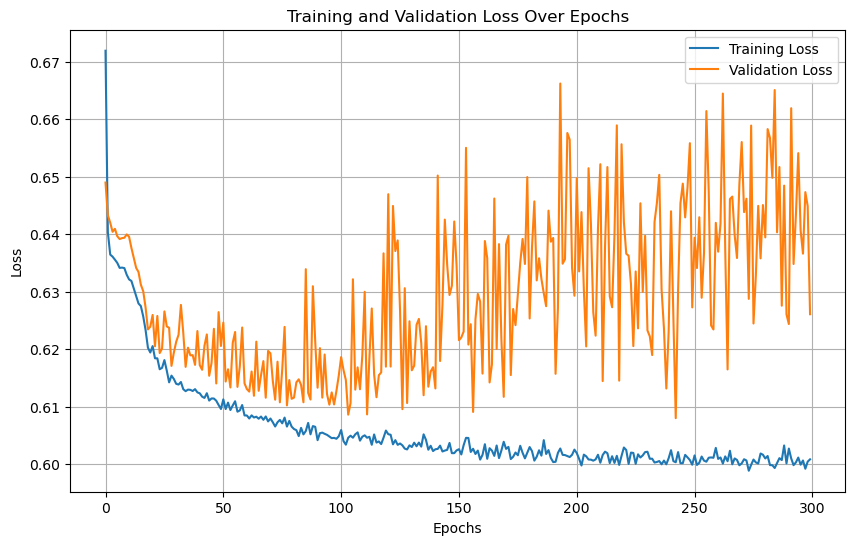

In [28]:
# Ensure that the length of gat_train_loss_list and gat_val_loss_list is equal to the number of epochs processed
assert len(gat_train_loss_list) == len(gat_val_loss_list)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(gat_train_loss_list, label='Training Loss')
plt.plot(gat_val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

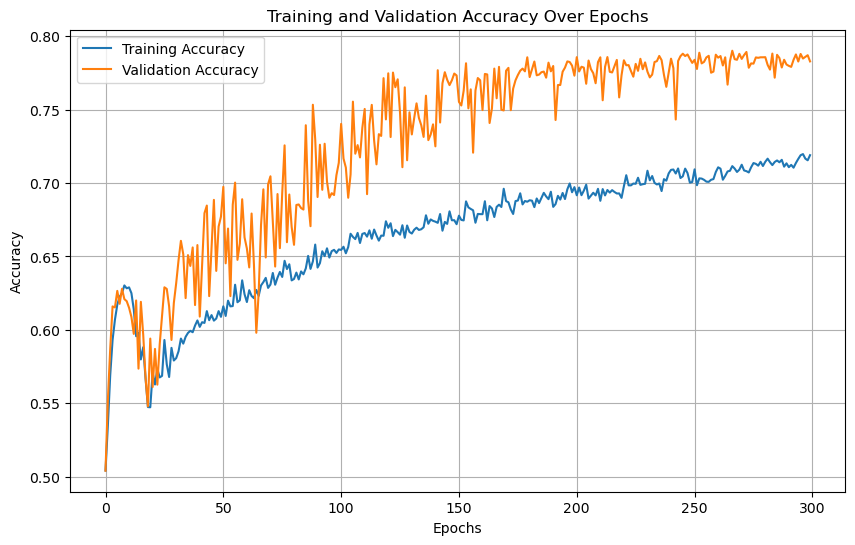

In [29]:
# plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(gat_train_accuracy_list, label='Training Accuracy')
plt.plot(gat_val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Train on merged train and val sets


In [29]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    for batch_graphs, batch_labels in data_loader:
        batch_graphs = batch_graphs.to(device)
        batch_labels = batch_labels.to(device)
        batch_features = batch_graphs.ndata['h']

        outputs = model(batch_graphs, batch_features)
        outputs = outputs.squeeze()  # Adjust for binary classification if necessary

        loss = criterion(outputs, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Assuming binary classification and outputs are logits
        # For multi-class classification, use torch.max(outputs, 1) and adjust the threshold if needed
        predicted = (torch.sigmoid(outputs) > 0.5).long()  # Convert logits to binary predictions
        total_correct += (predicted == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


## Reset weights before training again with all data


In [30]:
in_feats = train_graphs[0].ndata['h'].shape[1]
model = GATClassifier(in_feats, hidden_size=140, num_heads=16).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003180083105277109)

# Best trial: {'num_heads': 16, 'hidden_size': 140, 'lr': 0.003180083105277109}

In [31]:
def reset_weights(m):
    """
    This function will reset the weights of a given module.
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# Example usage with your model
model.apply(reset_weights)

GATClassifier(
  (layer): GATConv(
    (fc): Linear(in_features=74, out_features=2240, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (fc): Linear(in_features=2240, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [26]:
# Initialize list to store loss values
final_train_losses = []
final_train_accuracies = []  # Add a list to store accuracy values

# If num_epochs_early_stopped is not defined, train for 300 epochs
if 'num_epochs_early_stopped' not in locals():
    num_epochs_early = 1000

for epoch in range(num_epochs_early):
    # Training
    train_loss, train_accuracy = train(model, train_loader_all, criterion, optimizer, device)  # Unpack the returned tuple
    final_train_losses.append(train_loss)  # Store train loss
    final_train_accuracies.append(train_accuracy)  # Store train accuracy

    # Print train loss and accuracy
    print(f"Epoch {epoch+1}/{num_epochs_early}, Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")


Epoch 1/1000, Train Loss: 0.6577, Accuracy: 0.5095
Epoch 2/1000, Train Loss: 0.6388, Accuracy: 0.5586
Epoch 3/1000, Train Loss: 0.6368, Accuracy: 0.5859
Epoch 4/1000, Train Loss: 0.6359, Accuracy: 0.6000
Epoch 5/1000, Train Loss: 0.6352, Accuracy: 0.6063
Epoch 6/1000, Train Loss: 0.6341, Accuracy: 0.6059
Epoch 7/1000, Train Loss: 0.6336, Accuracy: 0.6033
Epoch 8/1000, Train Loss: 0.6315, Accuracy: 0.6041
Epoch 9/1000, Train Loss: 0.6309, Accuracy: 0.5899
Epoch 10/1000, Train Loss: 0.6281, Accuracy: 0.5827
Epoch 11/1000, Train Loss: 0.6260, Accuracy: 0.5694
Epoch 12/1000, Train Loss: 0.6242, Accuracy: 0.5639
Epoch 13/1000, Train Loss: 0.6226, Accuracy: 0.5610
Epoch 14/1000, Train Loss: 0.6214, Accuracy: 0.5689
Epoch 15/1000, Train Loss: 0.6200, Accuracy: 0.5670
Epoch 16/1000, Train Loss: 0.6196, Accuracy: 0.5749
Epoch 17/1000, Train Loss: 0.6179, Accuracy: 0.5793
Epoch 18/1000, Train Loss: 0.6175, Accuracy: 0.5803
Epoch 19/1000, Train Loss: 0.6164, Accuracy: 0.5815
Epoch 20/1000, Train 

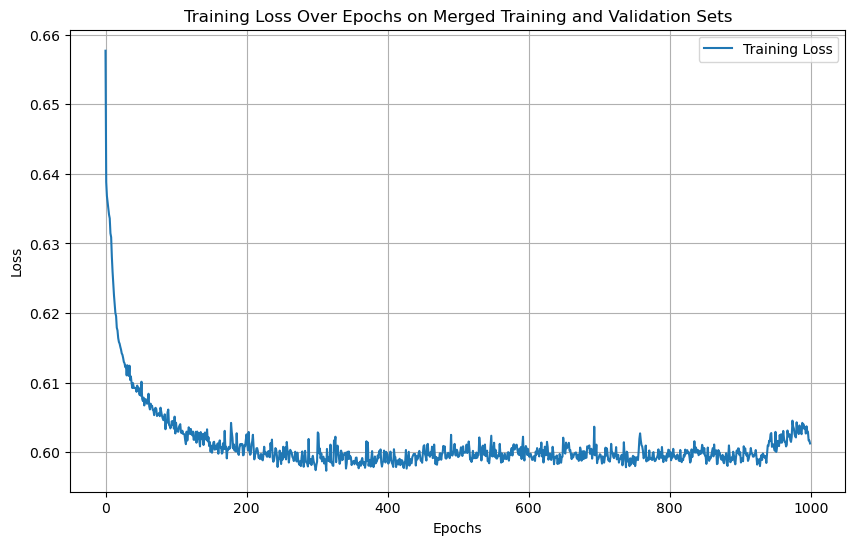

In [27]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(final_train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs on Merged Training and Validation Sets')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


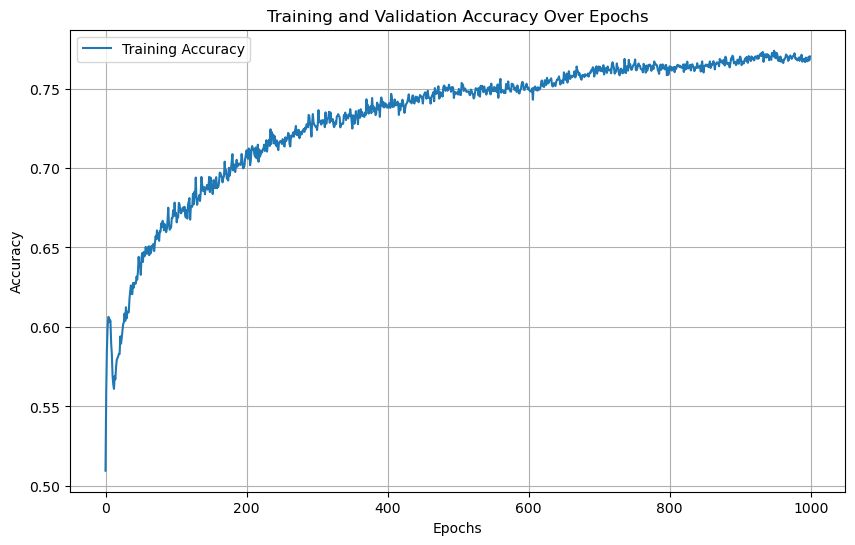

In [30]:
# plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(final_train_accuracies, label='Training Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Save the model

In [113]:
# if there is not a folder named 'model' create one
if not os.path.exists('model_experiment'):
    os.mkdir('model_experiment')

# save the model
torch.save(model.state_dict(), 'model_experiment/gat_model_experiment.pth')

In [32]:
# load the model
in_feats = train_graphs[0].ndata['h'].shape[1]
model = GATClassifier(in_feats, hidden_size=140, num_heads=16)
model.load_state_dict(torch.load('model_experiment/gat_model_experiment.pth', map_location=device))
model.to(device)
model.eval()

with torch.no_grad():
    for batched_graph, labels in test_loader:
        batched_graph = batched_graph.to(device)  # Move the graph to the same device as the model
        features = batched_graph.ndata['h'].to(device)  # Ensure features are on the same device
        outputs, attn_weights = model(batched_graph, features, get_attention=True)
        # Now you can process the attention weights as needed


## Test the model

## Predict probabilities

In [34]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def test(model, data_loader, device, get_attention=False):
    model.eval()
    y_true = []
    y_pred = []
    y_pred_proba = []
    attn_weights_list = []  # To store attention weights for each sample
    with torch.no_grad():
        for graphs, labels in data_loader:
            graphs = graphs.to(device)
            features = graphs.ndata['h'].to(device)
            labels = labels.to(device)
            outputs = model(graphs, features, get_attention=get_attention)
            
            # Handle models that return attention weights differently
            if get_attention:
                # If attention weights are returned, extend attn_weights_list accordingly
                output_logits, attn_weights = outputs
                for aw in attn_weights[-1]:  # Assuming the last layer's attention weights are of interest
                    attn_weights_list.append(aw.detach().cpu())
            else:
                # If no attention weights are returned, use output directly
                output_logits = outputs
            
            # Assuming outputs are logits; apply sigmoid for probabilities
            probas = sigmoid(output_logits.squeeze().cpu().numpy())
            preds = (probas > 0.5).astype(int)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)
            y_pred_proba.extend(probas)
            
            # If attention is not collected for some reason, use placeholders
            if get_attention and len(attn_weights_list) < len(y_pred):
                # Assuming attention weights are tensors; adjust the placeholder as needed
                placeholder = torch.zeros_like(attn_weights[-1][0]).detach().cpu()  # Example placeholder
                attn_weights_list.extend([placeholder] * (len(y_pred) - len(attn_weights_list)))
    
    return y_true, y_pred, y_pred_proba, attn_weights_list


In [97]:
y_true, y_pred, y_pred_proba, attn_weights_list = test(model, test_loader, device, get_attention=True)


In [98]:
len(attn_weights_list)


14773

In [140]:

def find_optimal_threshold(y_true, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_idx = np.nanargmax(f1_scores)  # Using nanargmax to ignore NaN values
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

optimal_threshold = find_optimal_threshold(y_true, y_pred_proba)
print(f"Optimal Threshold: {optimal_threshold}")

# Adjust predictions based on the optimal threshold
adjusted_preds = (np.array(y_pred_proba) > optimal_threshold).astype(int)

# Evaluation metrics after adjustment
print(f'Adjusted Accuracy: {accuracy_score(y_true, adjusted_preds)}')
print(f'Adjusted Precision: {precision_score(y_true, adjusted_preds, zero_division=1)}')
print(f'Adjusted Recall: {recall_score(y_true, adjusted_preds)}')
print(f'Adjusted F1: {f1_score(y_true, adjusted_preds)}')
print(f'Adjusted AUC: {roc_auc_score(y_true, y_pred_proba)}')

confidence_percentages = [prob * 100 for prob in y_pred_proba]


Optimal Threshold: 0.5000221133232117
Adjusted Accuracy: 0.7698504027617952
Adjusted Precision: 0.7308315960157516
Adjusted Recall: 0.8543189818575684
Adjusted F1: 0.787765293383271
Adjusted AUC: 0.844633584127032


## Results

In [38]:
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')
print(f'AUC: {roc_auc_score(y_true, y_pred_proba)}')

Accuracy: 0.7467000609219522
Precision: 0.6902673350041771
Recall: 0.8949363660980233
F1: 0.7793892229689895
AUC: 0.844633584127032


In [42]:
# create a folder for the images
if not os.path.exists('images'):
    os.mkdir('images')
    
if not os.path.exists('images/top_1'):
    os.mkdir('images/top_1')
    
if not os.path.exists('images/top_0'):
    os.mkdir('images/top_0')
    

In [43]:
# Convert attention weights list to a suitable format (e.g., list of lists, if not already)
# This step may vary depending on the structure of attn_weights_list
attention_weights_formatted = [aw.tolist() for aw in attn_weights_list]

# Ensuring test_indices is a list and has the correct length
test_indices_list = test_indices.tolist()  # Convert to list if it's not already


In [44]:
print(len(test_indices))
print(len(y_pred))
print(len(y_pred_proba))
print(len(attention_weights_formatted))


14773
14773
14773
14773


In [45]:


# Recreate the DataFrame with the corrected lists
results_df = pd.DataFrame({
    'original_index': test_indices_list,
    'prediction': y_pred,
    'predicted_proba': y_pred_proba,
    'attention_weights': attention_weights_formatted
})



In [46]:
results_df


,original_index,prediction,predicted_proba,attention_weights
0,66708,1,0.730148,[0.00263858400285244]
1,17474,1,0.500059,[1.0]
2,67679,0,0.500000,[6.804620422684593e-09]
3,14073,1,0.731059,[9.743617556523532e-05]
4,60453,0,0.500000,[0.9646674394607544]
...,...,...,...,...
14768,26293,1,0.731059,[0.0]
14769,50098,1,0.500000,[0.0]
14770,24803,1,0.731059,[0.0]
14771,14015,1,0.730969,[0.0]


In [47]:
def get_rdkit_molecule_from_index(index):
    # Retrieve the SMILES string using the original index
    smiles_string = df_small.loc[df_small['original_index'] == index, 'SMILES'].iloc[0]
    return Chem.MolFromSmiles(smiles_string)

# Generate RDKit molecules from indices in the test set, ensuring indices match those in df_small
molecules = [get_rdkit_molecule_from_index(i) for i in test_indices]
# Assuming you have a list of RDKit molecule objects corresponding to your test dataset


In [58]:

# Create directories for images if they do not exist
os.makedirs('images/top_1', exist_ok=True)
os.makedirs('images/top_0', exist_ok=True)

# Load json data from data_mvi folder
chemdiv = pd.read_json('data_mvi/chemdiv_df.json')
enamine = pd.read_json('data_mvi/enamine_df.json')
enamine_protein = pd.read_json('data_mvi/enamine_protein_df.json')
life_chemicals = pd.read_json('data_mvi/life_chemicals_df.json')
robin = pd.read_json('data_mvi/robin_df.json')

# Add 'source' column to each DataFrame
chemdiv['source'] = 'chemdiv'
enamine['source'] = 'enamine'
enamine_protein['source'] = 'enamine_protein'
life_chemicals['source'] = 'life_chemicals'
robin['source'] = 'robin'

# Combine all dataframes into one
df = pd.concat([chemdiv, enamine, enamine_protein, life_chemicals, robin], ignore_index=True)

# Create 'mol' column using the 'SMILES' column to create RDKit mol objects
df['mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

# Assign labels: if 'source' is 'enamine_protein', label as 0, else label as 1
df['rna'] = df['source'].apply(lambda x: 0 if x == 'enamine_protein' else 1)

# Assuming you have attention weights and predictions already calculated
# Here you would load your model, run predictions and get attention weights
y_true, y_pred, y_pred_proba, attn_weights_list = test(model, test_loader, device, get_attention=True)

test_indices = results_df['original_index']

In [99]:
# Function to retrieve an RDKit molecule object from an index
def get_rdkit_molecule_from_index(index, df):
    return df.loc[index, 'mol']

# Generate RDKit molecules from indices in the test set
molecules = [get_rdkit_molecule_from_index(i, df) for i in test_indices]

# Function to visualize attention for a molecule
def visualize_attention_for_molecule(mol, attn_weights, threshold=0.1):
    # Convert attn_weights to a numpy array if it's not already one
    attn_weights = np.atleast_1d(np.array(attn_weights))

    # Identify indices of the edges (bonds) with attention above the threshold
    high_attention_edges = [i for i, weight in enumerate(attn_weights) if weight > threshold]

    # Retrieve the bond indices to highlight
    bonds_to_highlight = [mol.GetBondWithIdx(i).GetIdx() for i in high_attention_edges]

    # Generate the molecule image with highlighted bonds
    return Draw.MolToImage(mol, highlightBonds=bonds_to_highlight)

# Pair each molecule with its predicted probability and attention weights
molecule_info = list(zip(molecules, y_pred_proba, attn_weights_list))

# Sort based on predicted probability for class 1 (descending)
sorted_molecule_info = sorted(molecule_info, key=lambda x: x[1], reverse=True)

# Select the top N molecules for class 1 and bottom N for class 0
N = 5  # Number of molecules to visualize for each class
top_molecules_class_1 = sorted_molecule_info[:N]
bottom_molecules_class_0 = sorted_molecule_info[-N:]

# Visualize and save images for top molecules for class 1
for idx, (mol, prob, attn_weights) in enumerate(top_molecules_class_1):
    img = visualize_attention_for_molecule(mol, attn_weights, threshold=0.1)
    if img:
        img_path = f'images/top_1/top_molecule_class_1_{idx}.png'
        img.save(img_path)
        print(f"Image saved to {img_path}")
    else:
        print(f"Skipping molecule at index {idx} due to invalid mol object")

# Repeat for bottom molecules for class 0 with appropriate adjustments
for idx, (mol, prob, attn_weights) in enumerate(bottom_molecules_class_0):
    img = visualize_attention_for_molecule(mol, attn_weights, threshold=0.1)
    if img:
        img_path = f'images/top_0/bottom_molecule_class_0_{idx}.png'
        img.save(img_path)
        print(f"Image saved to {img_path}")
    else:
        print(f"Skipping molecule at index {idx} due to invalid mol object")
        

Image saved to images/top_1/top_molecule_class_1_0.png
Image saved to images/top_1/top_molecule_class_1_1.png
Image saved to images/top_1/top_molecule_class_1_2.png
Image saved to images/top_1/top_molecule_class_1_3.png
Image saved to images/top_1/top_molecule_class_1_4.png
Image saved to images/top_0/bottom_molecule_class_0_0.png
Image saved to images/top_0/bottom_molecule_class_0_1.png
Image saved to images/top_0/bottom_molecule_class_0_2.png
Image saved to images/top_0/bottom_molecule_class_0_3.png
Image saved to images/top_0/bottom_molecule_class_0_4.png


In [61]:
# Example assuming top_molecules_class_1 and bottom_molecules_class_0 are prepared correctly
for idx, (mol, prob, attn_weights) in enumerate(top_molecules_class_1):
    img = visualize_attention_for_molecule(mol, attn_weights, threshold=0.1)
    if img is not None:
        img_path = f'images/top_1/top_molecule_class_1_{idx}.png'
        img.save(img_path)
        print(f"Image saved to {img_path}")
    else:
        print(f"Skipping molecule at index {idx} due to invalid mol object")

# Repeat for bottom molecules for class 0 with appropriate adjustments
for idx, (mol, prob, attn_weights) in enumerate(bottom_molecules_class_0):
    img = visualize_attention_for_molecule(mol, attn_weights, threshold=0.1)
    if img is not None:
        img_path = f'images/top_0/bottom_molecule_class_0_{idx}.png'
        img.save(img_path)
        print(f"Image saved to {img_path}")
    else:
        print(f"Skipping molecule at index {idx} due to invalid mol object")

Image saved to images/top_1/top_molecule_class_1_0.png
Image saved to images/top_1/top_molecule_class_1_1.png
Image saved to images/top_1/top_molecule_class_1_2.png
Image saved to images/top_1/top_molecule_class_1_3.png
Image saved to images/top_1/top_molecule_class_1_4.png
Image saved to images/top_0/bottom_molecule_class_0_0.png
Image saved to images/top_0/bottom_molecule_class_0_1.png
Image saved to images/top_0/bottom_molecule_class_0_2.png
Image saved to images/top_0/bottom_molecule_class_0_3.png
Image saved to images/top_0/bottom_molecule_class_0_4.png


In [62]:
# save all visualized molecules with attention and create a folder for them
if not os.path.exists('visualized_molecules'):
    os.mkdir('visualized_molecules')
  


In [94]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display
import numpy as np

# Ensure RDKit Depictions work well
rdDepictor.SetPreferCoordGen(True)

def extract_and_visualize_attention_subgraphs(molecule, attention_weights, threshold=0.1):
    """
    Extracts subgraphs from a molecule based on attention weights and visualizes them.

    Parameters:
    - molecule: RDKit Mol object.
    - attention_weights: List of attention weights for edges in the molecule.
    - threshold: Attention weight threshold to consider for extracting subgraphs.
    
    Returns:
    - A list of SVG images of the high-attention subgraphs.
    """
    # Initialize an empty list to store SVG images
    svg_images = []
    
    # Ensure attention_weights is a numpy array for easier handling
    attention_weights = np.array(attention_weights)
    
    # Identify edges with attention weights above the threshold
    high_attention_edges = np.where(attention_weights > threshold)[0]
    
    for edge_idx in high_attention_edges:
        # Convert edge_idx to int to match the expected signature
        edge_idx = int(edge_idx)  # Convert from numpy.int64 to int
        
        # Get the bond from the molecule
        bond = molecule.GetBondWithIdx(edge_idx)
        # Get atom indices involved in the bond
        start_atom_idx = bond.GetBeginAtomIdx()
        end_atom_idx = bond.GetEndAtomIdx()
        
        # Extract the sub-molecule containing just this bond
        # Note: Adjust this as needed to extract larger subgraphs
        submol = Chem.PathToSubmol(molecule, [start_atom_idx, end_atom_idx])
        
        # Draw the sub-molecule
        drawer = rdMolDraw2D.MolDraw2DSVG(250, 250)  # Specify the image size
        rdMolDraw2D.PrepareAndDrawMolecule(drawer, submol)
        drawer.FinishDrawing()
        svg = drawer.GetDrawingText().replace('svg:', '')
        
        # Append the SVG image to the list
        svg_images.append(svg)
    
    return svg_images


def display_svgs(svgs):
    """Display SVG images stored as strings."""
    for svg in svgs:
        display(SVG(svg))


In [95]:
# Convert SMILES to RDKit Mol objects for visualization
df_small['mol'] = df_small['SMILES'].apply(Chem.MolFromSmiles)
test_mols = [df_small.iloc[idx]['mol'] for idx in test_indices]


In [107]:
# count the number of weights > 0.5 in attn_weights_list
count = 0
for i in attn_weights_list:
    for j in i:
        if j > 0.9:
            count += 1
print(count)
print(len(attn_weights_list))

142
14773


In [ ]:
for i, mol in enumerate(test_mols):
    if mol is not None:  # Ensure the molecule is valid
        attn_weights = attn_weights_list[i]  # Attention weights for the current molecule
        svgs = extract_and_visualize_attention_subgraphs(mol, attn_weights, threshold=0.5)
        display_svgs(svgs)


In [120]:
def extract_larger_subgraphs(molecule, attention_weights, threshold=0.1, radius=1):
    """
    Extracts larger subgraphs from a molecule based on attention weights,
    including atoms within a specified radius from high-attention bonds.
    
    Parameters:
    - molecule: RDKit Mol object.
    - attention_weights: List of attention weights for edges in the molecule.
    - threshold: Attention weight threshold to consider for extracting subgraphs.
    - radius: The radius around high-attention bonds within which to include atoms.
    
    Returns:
    - A list of SMILES strings for the extracted subgraphs.
    """
    submols_smiles = []
    attention_weights = np.array(attention_weights)
    high_attention_bonds = np.where(attention_weights > threshold)[0]

    for bond_idx in high_attention_bonds:
        bond = molecule.GetBondWithIdx(int(bond_idx))
        start_atom_idx, end_atom_idx = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()

        # Convert outputs to sets before combining
        env1 = set(rdmolops.FindAtomEnvironmentOfRadiusN(molecule, radius, start_atom_idx))
        env2 = set(rdmolops.FindAtomEnvironmentOfRadiusN(molecule, radius, end_atom_idx))
        env = env1 | env2  # Now this combines two sets correctly

        # Convert to a list of unique atom indices
        atoms_idx = set()
        for bond_idx in env:
            bond = molecule.GetBondWithIdx(bond_idx)
            atoms_idx.add(bond.GetBeginAtomIdx())
            atoms_idx.add(bond.GetEndAtomIdx())

        # Create a subgraph (submolecule) containing the atoms in the environment
        submol = Chem.PathToSubmol(molecule, list(atoms_idx))

        # Convert the subgraph to a SMILES string and add it to the list
        smiles = Chem.MolToSmiles(submol, isomericSmiles=True)
        submols_smiles.append(smiles)

    return submols_smiles


In [121]:
for i, mol in enumerate(test_mols):
    if mol is not None:  # Ensure the molecule is valid
        attn_weights = attn_weights_list[i]  # Use attention weights for the current molecule
        submols_smiles = extract_larger_subgraphs(mol, attn_weights, threshold=0.5, radius=1)  # Adjust `radius` as needed
        print(f"Molecule {i} subgraphs: {submols_smiles}")


Molecule 0 subgraphs: []
Molecule 1 subgraphs: ['CNC(C)=O']
Molecule 2 subgraphs: []
Molecule 3 subgraphs: []
Molecule 4 subgraphs: ['C=O.CCNc']
Molecule 5 subgraphs: []
Molecule 6 subgraphs: []
Molecule 7 subgraphs: ['CCOC']
Molecule 8 subgraphs: []
Molecule 9 subgraphs: []
Molecule 10 subgraphs: []
Molecule 11 subgraphs: []
Molecule 12 subgraphs: []
Molecule 13 subgraphs: []
Molecule 14 subgraphs: ['CCcn']
Molecule 15 subgraphs: ['Cc(n)ns']
Molecule 16 subgraphs: []
Molecule 17 subgraphs: []
Molecule 18 subgraphs: []
Molecule 19 subgraphs: []
Molecule 20 subgraphs: []
Molecule 21 subgraphs: []
Molecule 22 subgraphs: []
Molecule 23 subgraphs: []
Molecule 24 subgraphs: []
Molecule 25 subgraphs: []
Molecule 26 subgraphs: []
Molecule 27 subgraphs: []
Molecule 28 subgraphs: []
Molecule 29 subgraphs: []
Molecule 30 subgraphs: []
Molecule 31 subgraphs: []
Molecule 32 subgraphs: []
Molecule 33 subgraphs: []
Molecule 34 subgraphs: []
Molecule 35 subgraphs: []
Molecule 36 subgraphs: []
Molecul

In [124]:
from collections import Counter

# Initialize an empty list to hold all extracted SMILES strings
all_extracted_smiles = []

# Iterate over the test molecules and their corresponding attention weights
for i, mol in enumerate(test_mols):
    if mol is not None:  # Ensure the molecule is valid
        attn_weights = attn_weights_list[i]  # Attention weights for the current molecule
        # Extract larger subgraphs as SMILES strings
        submols_smiles = extract_larger_subgraphs(mol, attn_weights, threshold=0.5, radius=1)
        # Extend the list with the extracted SMILES strings
        all_extracted_smiles.extend(submols_smiles)

# Count the frequency of each unique SMILES string in the extracted fragments
fragment_frequency = Counter(all_extracted_smiles)

# Display the most common fragments
for smiles, count in fragment_frequency.most_common(20):
    print(f"Fragment: {smiles}, Frequency: {count}")


Fragment: ccOC, Frequency: 16
Fragment: ccc(c)C, Frequency: 9
Fragment: CCOC, Frequency: 6
Fragment: CNC=O.cc, Frequency: 5
Fragment: ccCC, Frequency: 5
Fragment: CCCC, Frequency: 5
Fragment: Cnc=O.c=O, Frequency: 4
Fragment: CNC(C)=O, Frequency: 3
Fragment: CCC=O.CN, Frequency: 3
Fragment: ccc(C)n, Frequency: 3
Fragment: cC.cncC, Frequency: 3
Fragment: CCOc, Frequency: 3
Fragment: COC=O, Frequency: 3
Fragment: CNC=O.cn, Frequency: 3
Fragment: CN.cCC=O, Frequency: 3
Fragment: cNC=O.cc, Frequency: 2
Fragment: ccC(C)=O, Frequency: 2
Fragment: cnCC, Frequency: 2
Fragment: CCNC, Frequency: 2
Fragment: cF.cccC, Frequency: 2


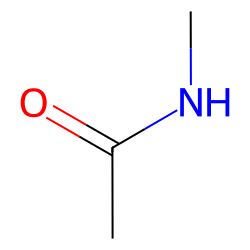

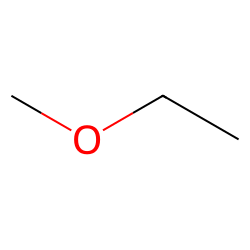

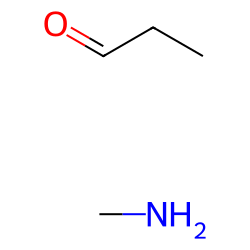

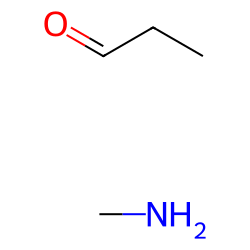

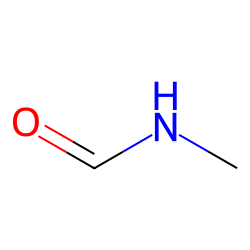

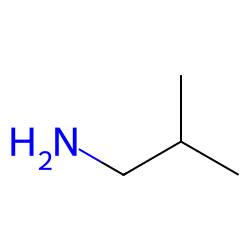

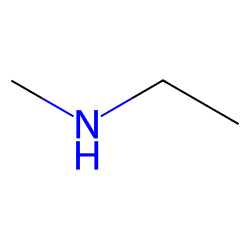

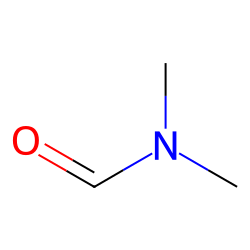

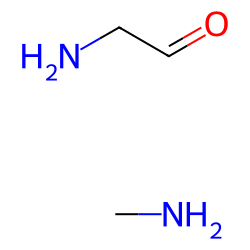

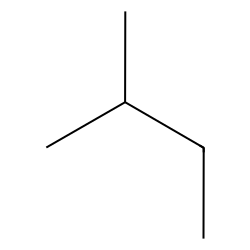

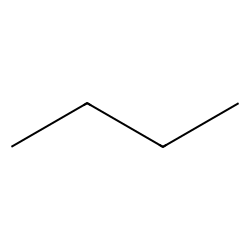

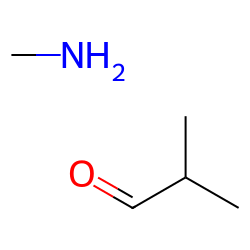

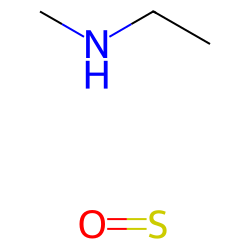

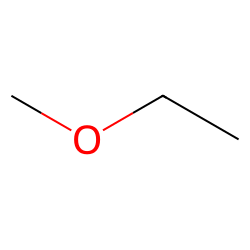

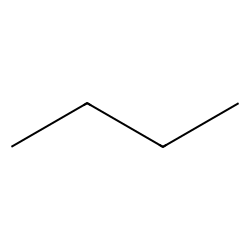

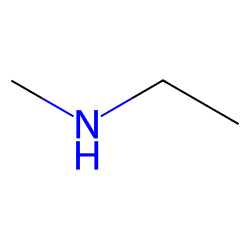

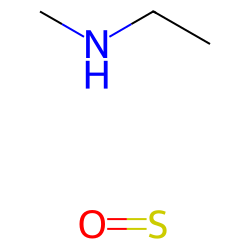

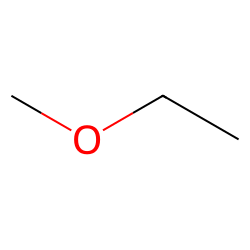

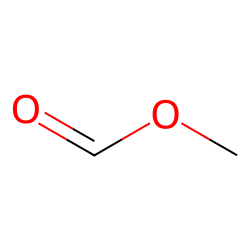

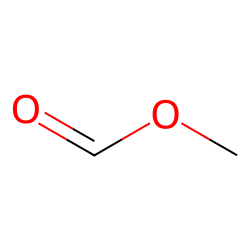

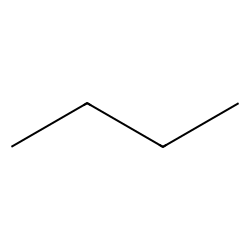

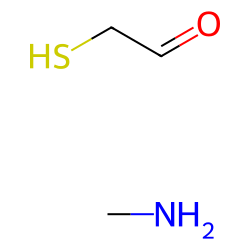

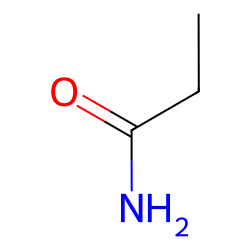

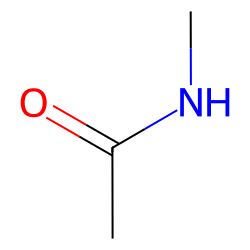

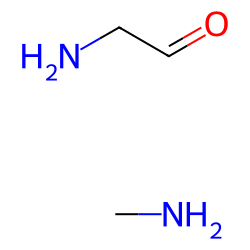

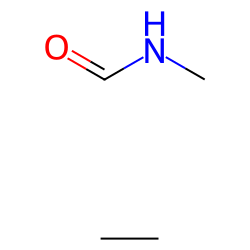

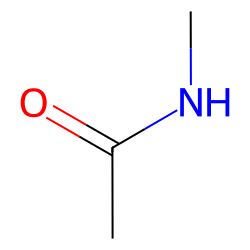

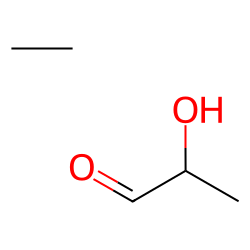

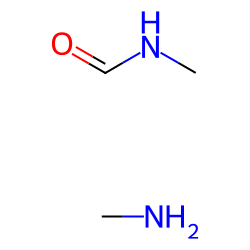

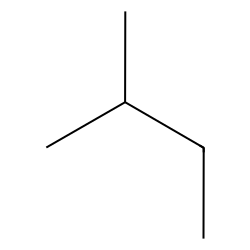

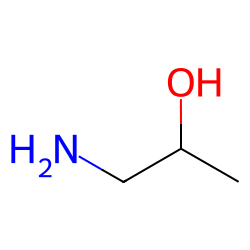

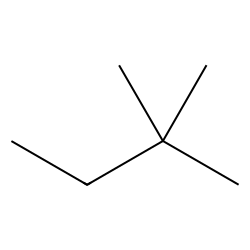

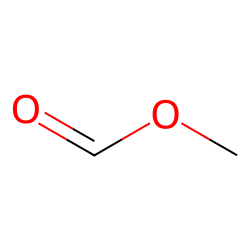

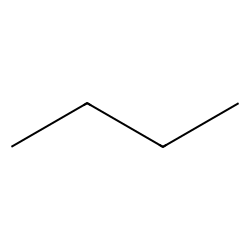

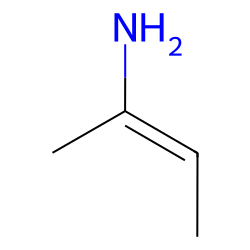

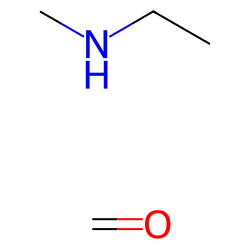

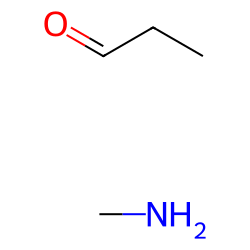

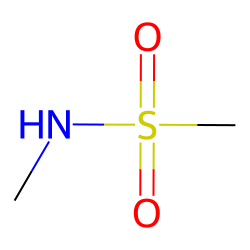

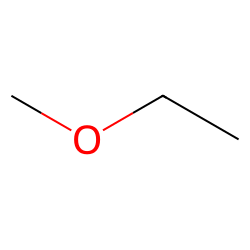

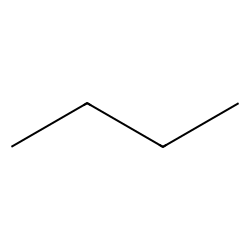

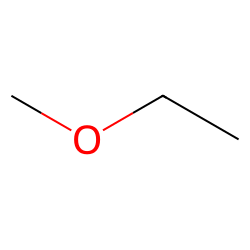

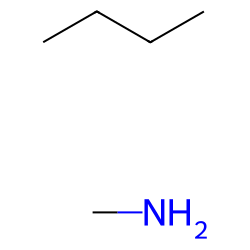

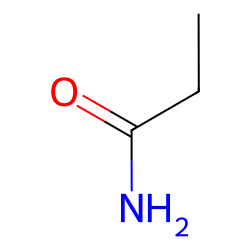

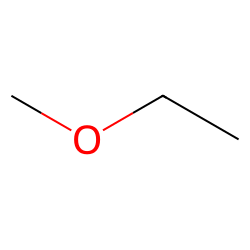

In [129]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D  # Corrected import path
from IPython.display import SVG, display
import numpy as np

# Ensure RDKit Depictions work well
rdDepictor.SetPreferCoordGen(True)

def visualize_smiles_as_svg(smiles_list):
    """
    Visualizes a list of SMILES strings as SVG images.

    Parameters:
    - smiles_list: List of SMILES strings.
    
    Returns:
    - A list of SVG images.
    """
    svg_images = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            drawer = rdMolDraw2D.MolDraw2DSVG(250, 250)
            rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol)
            drawer.FinishDrawing()
            svg = drawer.GetDrawingText().replace('svg:', '')
            svg_images.append(svg)
    return svg_images

def display_svgs(svgs):
    """Display SVG images stored as strings."""
    for svg in svgs:
        display(SVG(svg))

# Assuming extract_larger_subgraphs is defined elsewhere and working as expected
for i, mol in enumerate(test_mols):
    if mol is not None:  # Ensure the molecule is valid
        attn_weights = attn_weights_list[i]  # Use attention weights for the current molecule
        subgraphs_smiles = extract_larger_subgraphs(mol, attn_weights, threshold=0.5, radius=1)
        svgs = visualize_smiles_as_svg(subgraphs_smiles)  # Visualize the SMILES as SVG
        display_svgs(svgs)  # Display the SVG images


## Confusion matrix

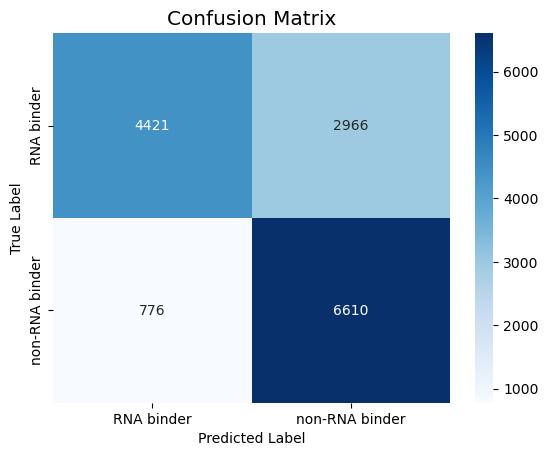

In [130]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=['RNA binder', 'non-RNA binder'], columns=['RNA binder', 'non-RNA binder'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
sns.set(context='paper', style='white', font_scale=1.5)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('visuals/confusion_matrix_gat_experiment.png', dpi=300)
plt.show()



## Classification report

In [131]:
# classification report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.60      0.70      7387
           1       0.69      0.89      0.78      7386

    accuracy                           0.75     14773
   macro avg       0.77      0.75      0.74     14773
weighted avg       0.77      0.75      0.74     14773



## ROC AUC

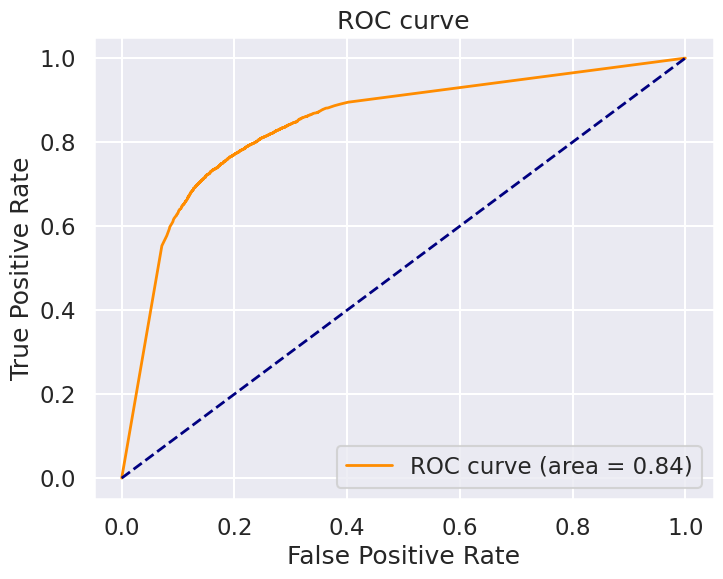

In [139]:
# visualize ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('visuals/roc_curve_gat_experiment.png', dpi=300)
plt.show()


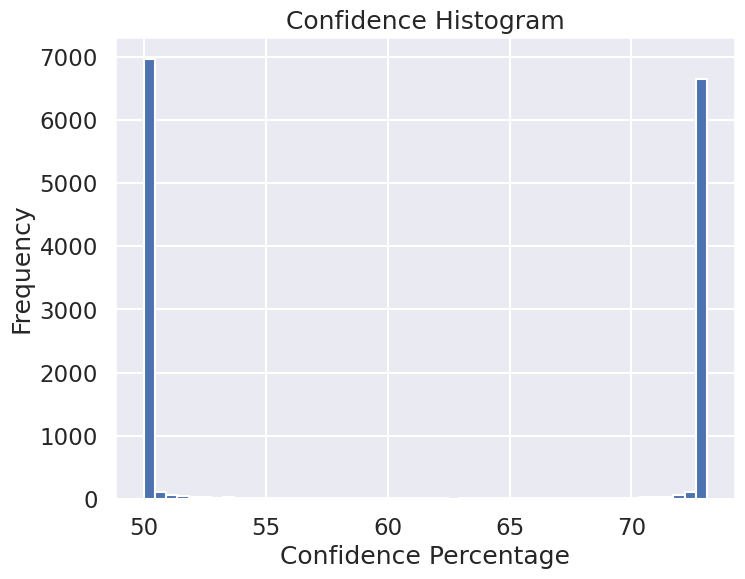

In [141]:
# visualize confidence_percentages in plot
plt.figure(figsize=(8, 6))
plt.hist(confidence_percentages, bins=50)
plt.title('Confidence Histogram')
plt.xlabel('Confidence Percentage')
plt.ylabel('Frequency')
plt.savefig('visuals/confidence_histogram_gat_experiment.png', dpi=300)
plt.show()


In [134]:
# Sort test predictions by confidence and get top 10 indices
sorted_pairs = sorted(enumerate(confidence_percentages), key=lambda x: x[1], reverse=True)
top_molecules_test_indices = [index for index, _ in sorted_pairs[:20]]

# The indices in test_graphs correspond to their positions in the original loaded_graphs_orig
# Find the original indices in loaded_graphs_orig
original_indices = [loaded_graphs_orig.index(test_graphs[i]) for i in top_molecules_test_indices]

# Use the original indices to look up the corresponding rows in reconstructed_df
top_molecule_row_indices = reconstructed_df.index[original_indices]

# Now, top_molecule_row_indices contains the DataFrame indices of the top 10 RNA-binding molecules


In [135]:
# create folder 'top_molecules' if it does not exist
if not os.path.exists('top_molecules_gat_experiment'):
    os.mkdir('top_molecules_gat_experiment')
    

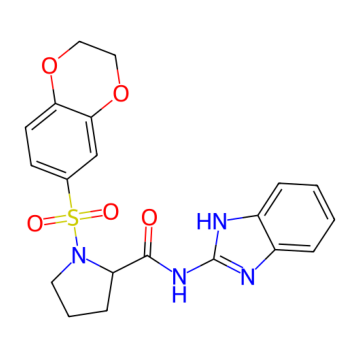

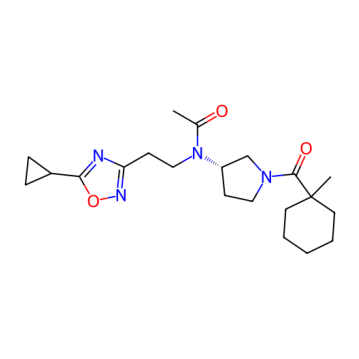

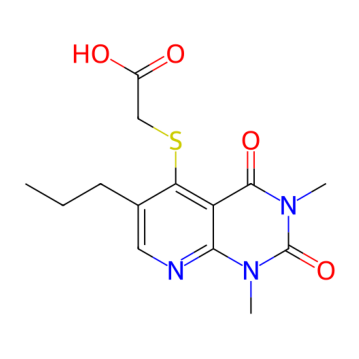

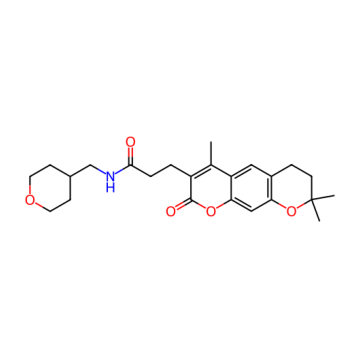

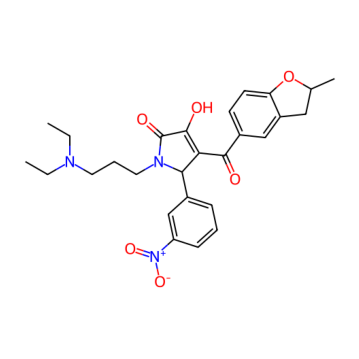

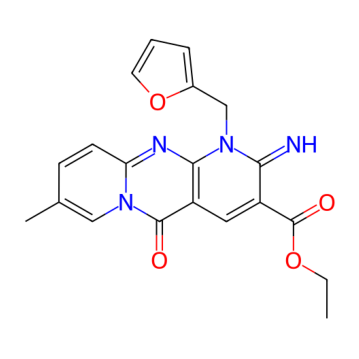

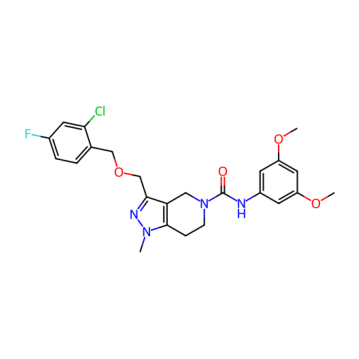

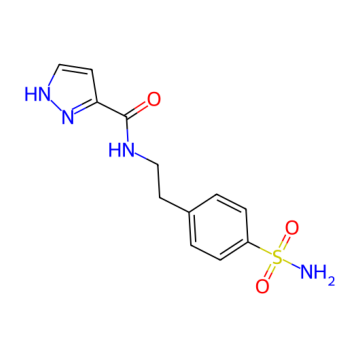

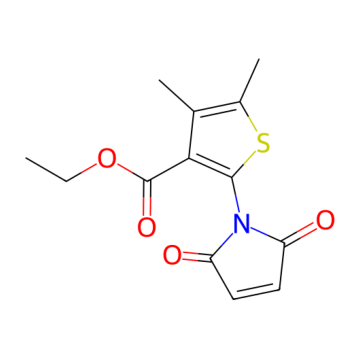

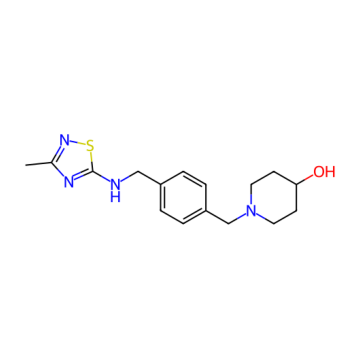

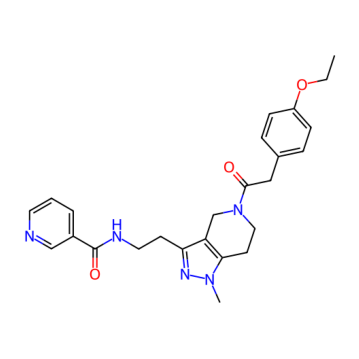

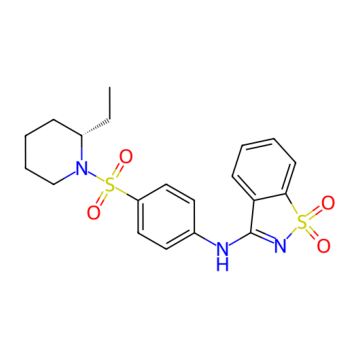

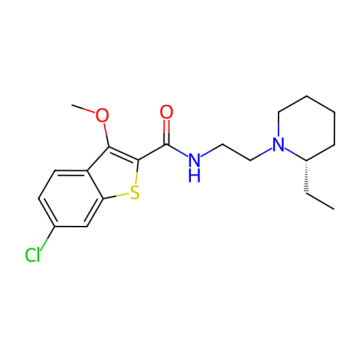

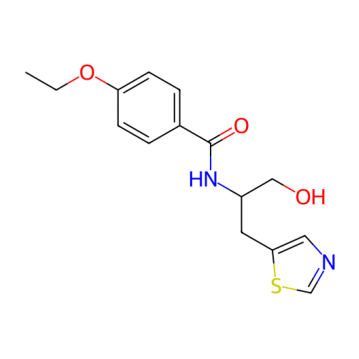

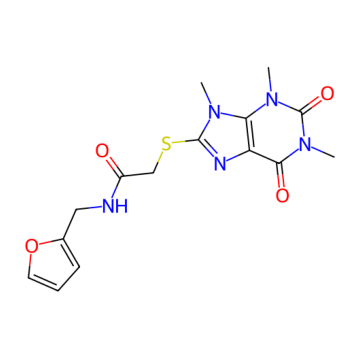

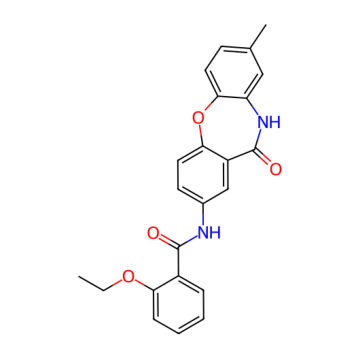

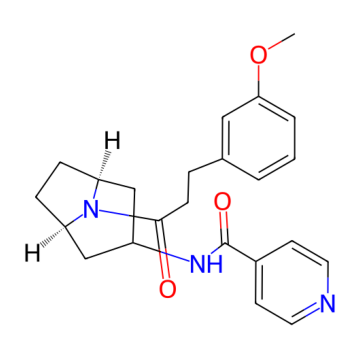

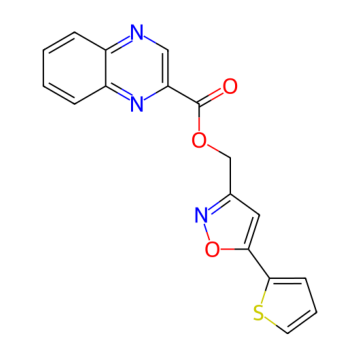

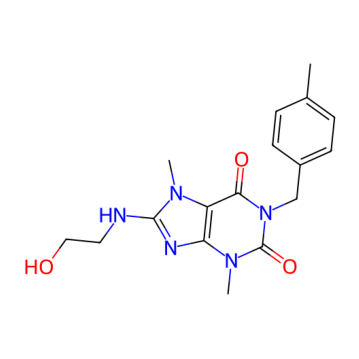

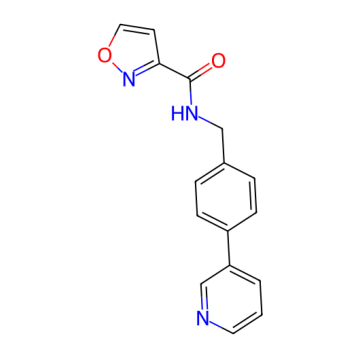

In [136]:
# Retrieve the SMILES codes and source information for the top 10 molecules
top_smiles = df_small.iloc[top_molecule_row_indices]['SMILES'].tolist()
top_sources = df_small.iloc[top_molecule_row_indices]['source'].tolist()

# Retrieve the confidence scores using the indices relative to the test dataset
top_confidences = [confidence_percentages[i] for i in top_molecules_test_indices]

# Convert SMILES to RDKit Mol objects
mols = [Chem.MolFromSmiles(smile) for smile in top_smiles]

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(500, 500))
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    # title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    # plt.title(title)
    plt.subplots_adjust(bottom=0.20)  # Adjust the position of the title
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_gat_experiment/molecule_{i+1}_{top_sources[i]}_a.png", dpi=300)
    plt.show()


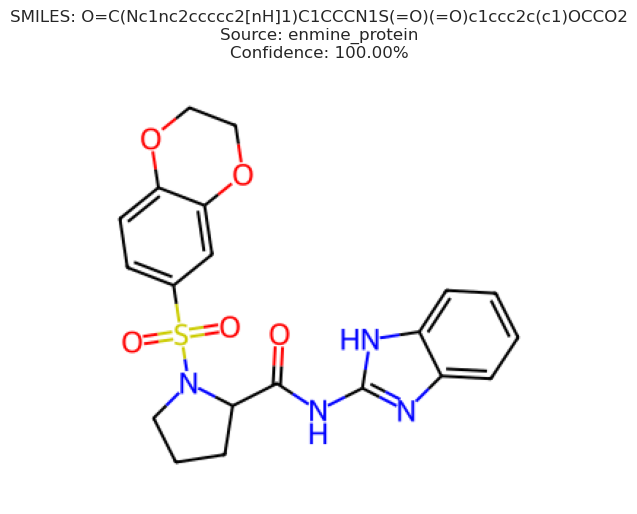

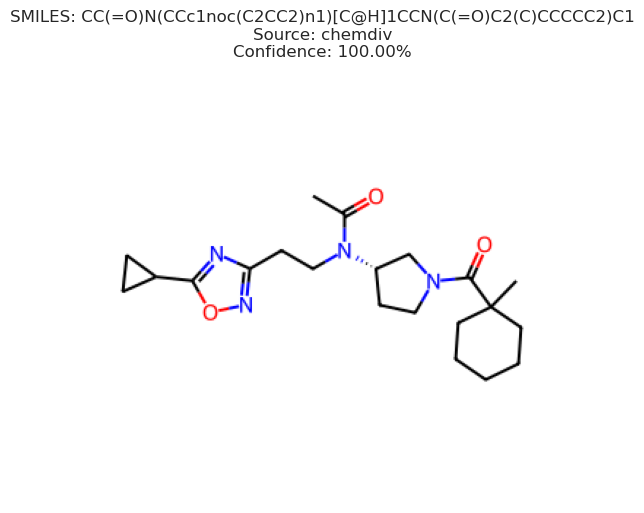

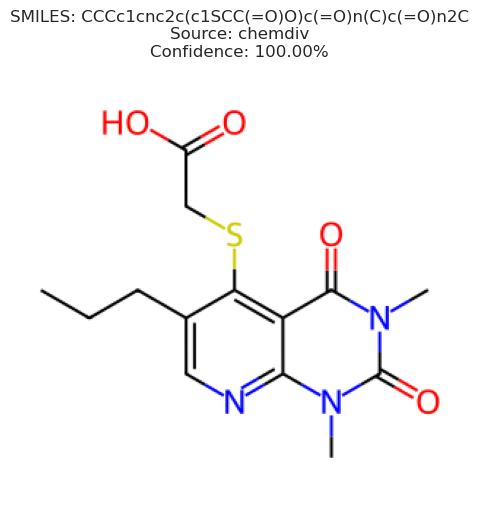

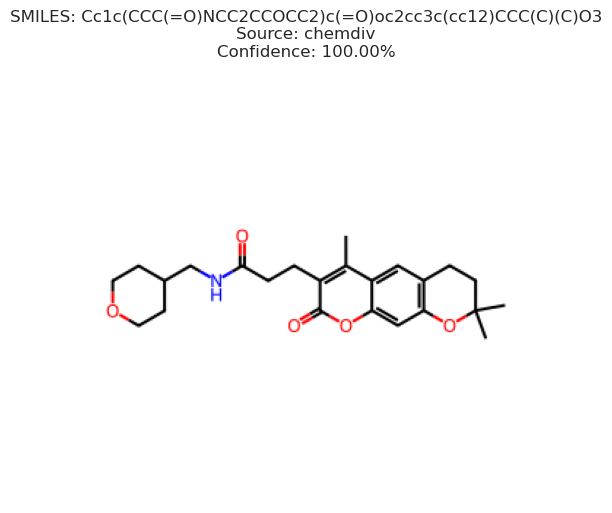

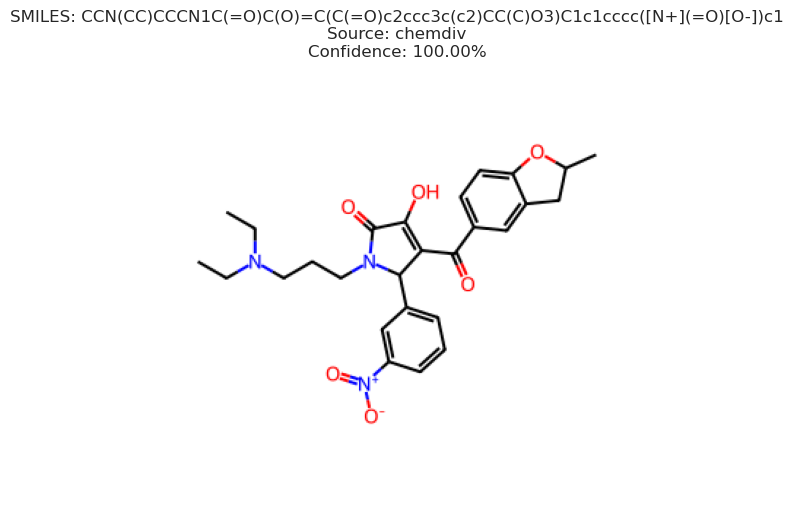

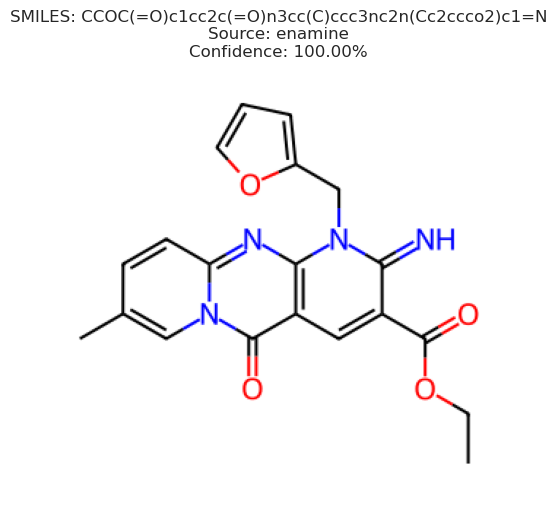

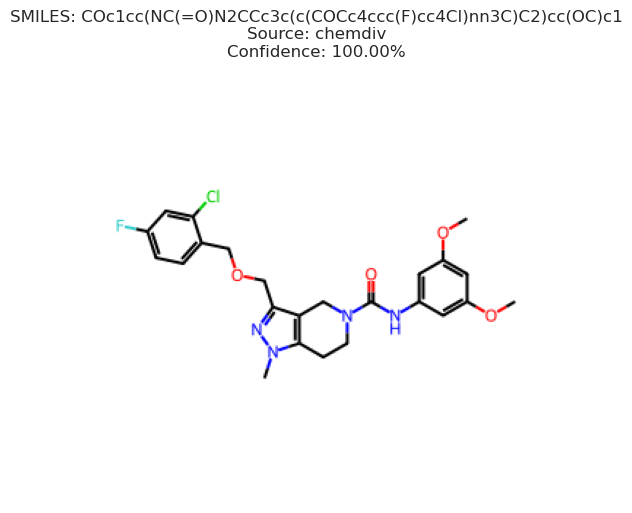

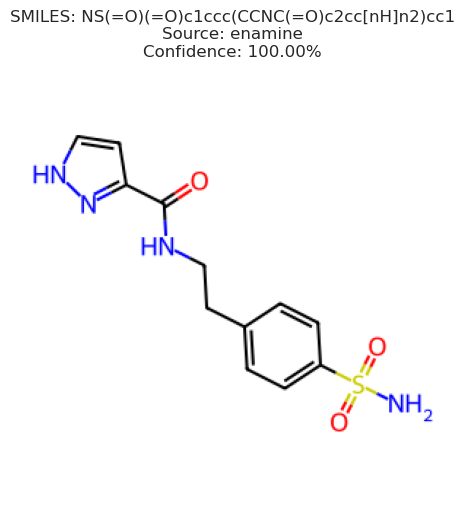

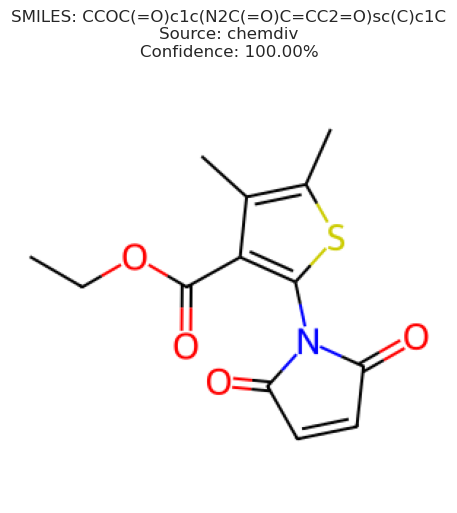

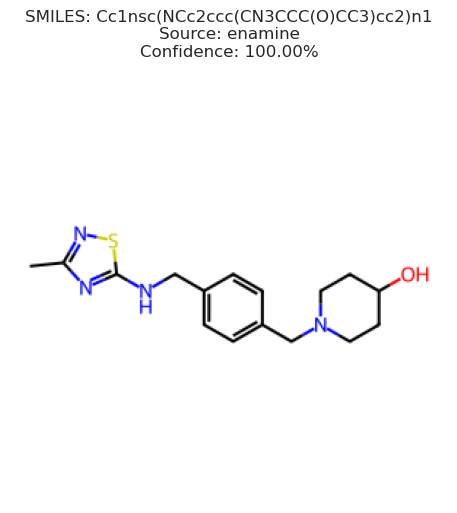

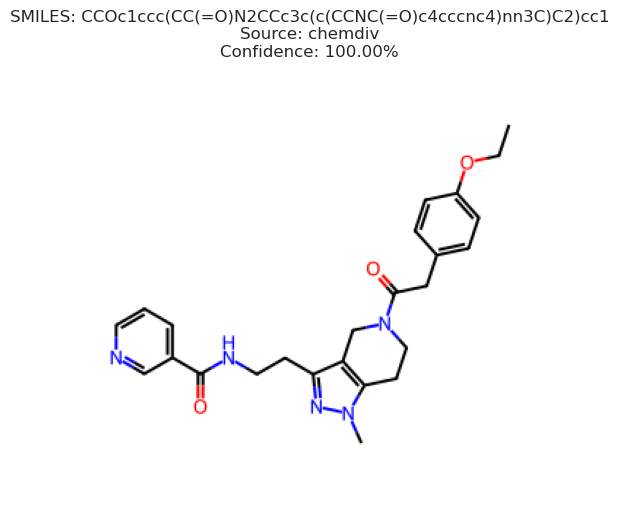

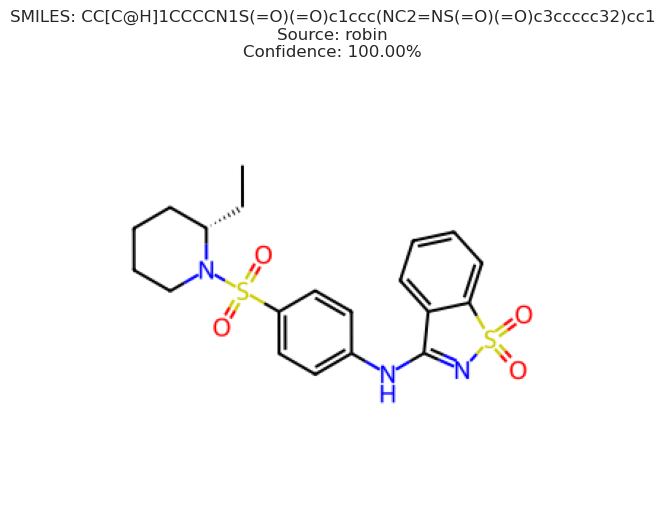

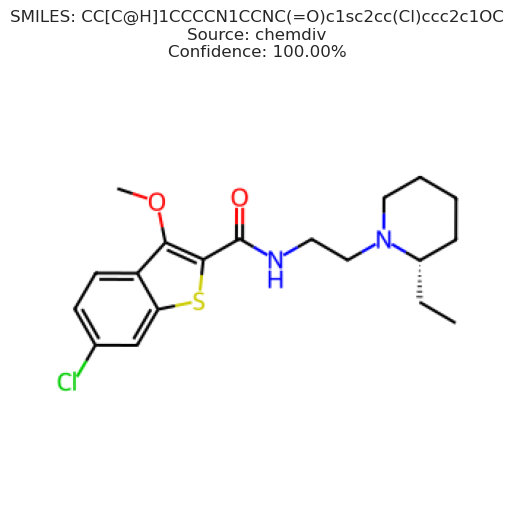

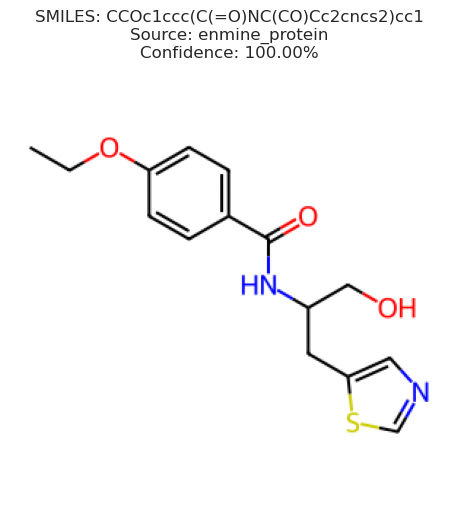

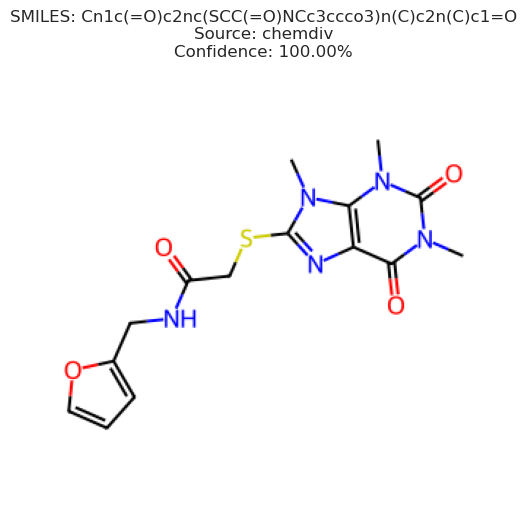

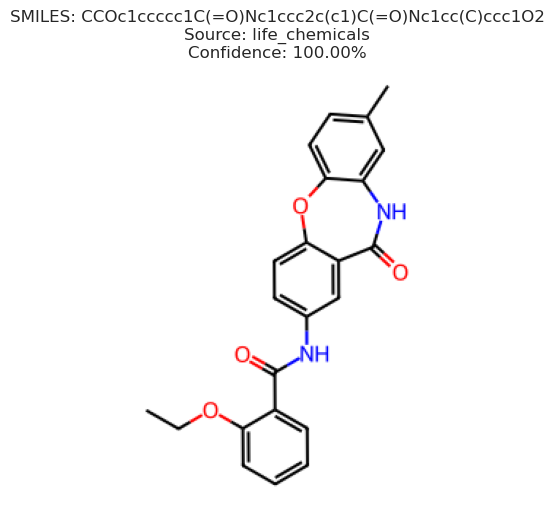

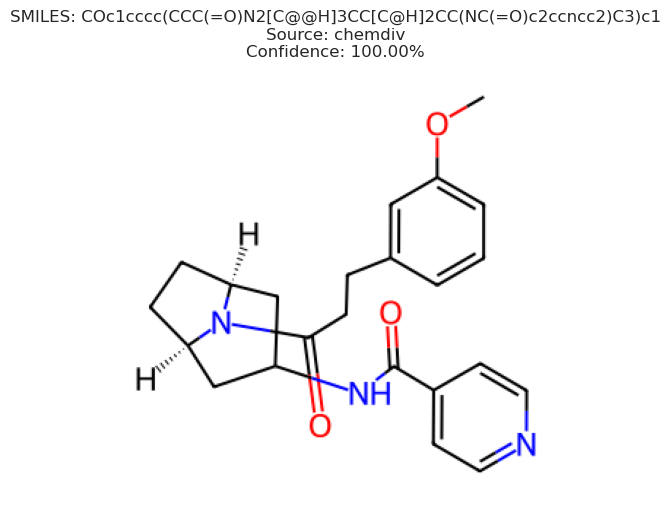

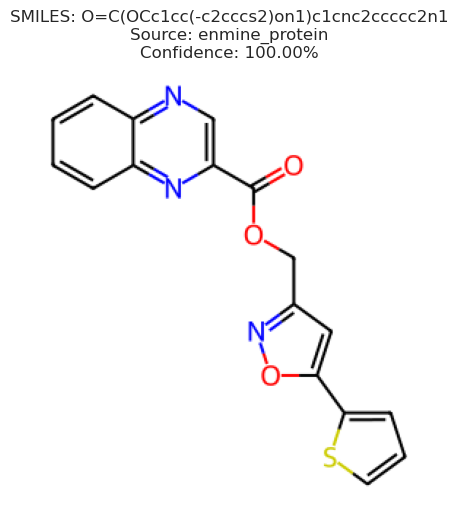

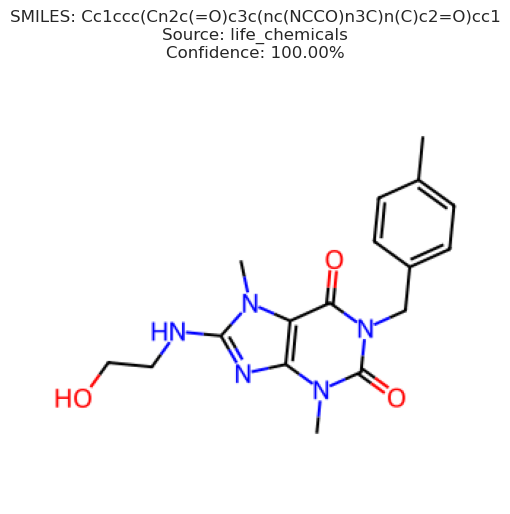

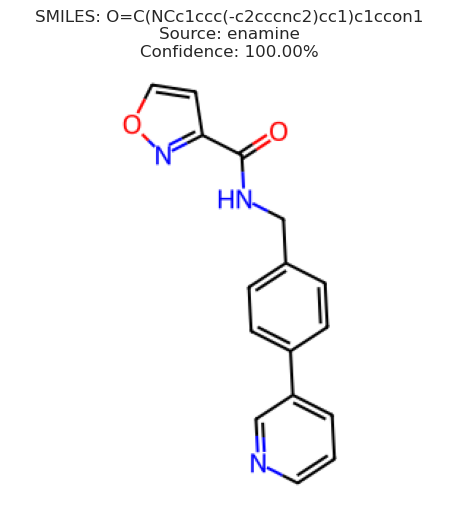

In [137]:
# Define the figure size and font size for titles
fig_size = (6, 6)
title_font_size = 12

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(300, 300))
    
    # Create a figure with adjusted size
    plt.figure(figsize=fig_size)
    plt.imshow(img)
    
    # Adjust the position of the text within the image
    title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    plt.title(title, fontsize=title_font_size)
    plt.subplots_adjust(bottom=0.15)  # Adjust the position of the title
    
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_gat_experiment/molecule_{i+1}_{top_sources[i]}_b.png", dpi=300)
    plt.show()
